## Lg헬로비전 해지스코어링 데이터 전처리 - 2
### ✳️ 타겟 변수 churn 생성

### 1. LGHV에서 타겟 변수 (해지 여부)데이터를 제공하기로 했으나 좀 지연됨.
- 원래 LGHV측에서 고객 해지 여부를 포함한 데이터를 제공해주기로 함.
- 그런데 해지 여부가 보안 문제에 엮어 있어서 계속적으로 LGHV 내부에서 이야기 중이라고 함.
- 하지만 데이터 제공이 너무 늦어질 가능성이 있어서, 타겟 변수를 직접 만들기로 팀 회의에서 결정함.

### 2. 직접 타겟 변수 생성하기로 결정
- 팀 내부에서 직접 churn 데이터를 생성하여 예측 모델을 준비.
- churn 데이터 생성후 원활한 분석과 모델링 작업 수행

### 타겟 변수는 꼭 필요했음!
- 타겟 변수는 예측하고자 하는 대상을 명확히 정의하는 데이터
- 이를 통해서 프로젝트의 방향성을 설정하고, 해지 여부에 대한 데이터 분석과 모델링 작업을 진행할 수 있음!
- 특히, 모델 훈련의 필수요소임. 타겟 변수가 없다면 모델이 학습할 '정답'이 없어서 예측이나 분류 작업을 수행할 수 없음!
- 그리고 타겟 변수와 다른 컬럼들간의 관계를 분석할 수 있음.

#### 기업에서 제공할 예정인 실제 churn 데이터와 팀이 생성한 churn 변수를 비교하여 정확도를 검증하는 행위도 유의미할 것 같음.
- 만약 LGHV에서 churn 데이터를 준다면, 단순히 모델링 결과만 나열하는 대신에 데이터 생성, 가설 검증, 실제 데이터 비교라는 과정을 모두 포함하여 우리의 포트폴리오에 나타낼 수 있음.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import operator
import math
import warnings
import openpyxl
import random
warnings.filterwarnings('ignore')

In [2]:
# 한글 글꼴체 변경
plt.rcParams['font.family'] ='Malgun Gothic'
# df.head() 이런거 했을 때, 컬럼이 생략되지 않고, 모든 컬럼 뜨게
pd.set_option('display.max_columns', None)
# 지수 표기법 대신에 소수점으로 표시하는코드
pd.options.display.float_format = '{:.2f}'.format
# 값 길이 제한 X
pd.set_option('display.max_colwidth', None) # 값 길이 제한 없음

In [4]:
# 필자는 src가 jupyternotebook 경로이다.
# 그래서, src -> data -> full_data -> TPS_cancel_data_preprocessing1.csv 가 파일 경로이다.

df = pd.read_csv("data/full_data/TPS_cancel_data_preprocessing1.csv")

In [5]:
df['churn'] = None

### churn(타겟 변수)컬럼 생성 방식

sha2_hash가 11번 겹친 유저들은 해지가 아닐 것이다.<br>
왜냐하면, 해당 데이터는 2월부터 12월까지인데 ID가 11번 겹친다는 것은 2월부터 12월까지 쭉 사용을 해왔다는 것을 의미한다.

2월 ~ 12월까지 겹친 유저들

In [6]:
# sha2_hash의 value_counts == 11 , 즉 sha2_hash가 11개인 사람들은 몇 명?
id_counts_11 = df['sha2_hash'].value_counts()[df['sha2_hash'].value_counts() == 11].index
duplicated_11_rows = df[df['sha2_hash'].isin(id_counts_11)]
duplicated_11_rows

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
0,51175d7ce1286145a8b27e1c9788a2cb607913d8f93dac9e023462cbb7c9ed1d,36개월 이상,HD,이코노미,N,N,재약정,N,0건,0건,일반상담,40.0,약정만료전 12개월이상,20251206,3512,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,Y,N,70대,수신,수신,8.17,2.18,2.18,JTBC,0.00,N,N,202302,None
1,ce25661b90c0d8075330d8c047322d18216a19be0296b95e6e731ecf6353102f,6개월미만,HD,이코노미,N,Y,신규,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260212,3205,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,Y,N,50대,미응답,수신,2.41,1.18,1.18,JTBC,0.00,N,N,202302,None
2,aad009544e7dc30f2330020c4807762de52d0a5088d6027fbb5e7e491438f4a6,36개월 이상,HD,프리미엄,N,N,약정승계,N,0건,0건,O/B,0.0,약정만료후 12개월이상,20150902,2667,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일전,N,N,80대,수신,수신,0.85,0.00,0.00,기타,0.00,N,N,202302,None
3,330f70ca9214537fd4e908c548fe36b5ad4b927e45cb81388c8f40689e7e5249,6개월~12개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,10.0,약정만료전 12개월이상,20250301,3704,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,60대,수신,수신,2.92,4.62,4.62,tvN,1.00,N,N,202302,None
4,501b04447cdb8fd36db50bba0b5338bca230b455a653cd8d557ce0ea9e25c1d0,36개월 이상,UHD,프리미엄,N,Y,약정승계,N,0건,0건,O/B,0.0,약정만료후 12개월이상,20200828,3609,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3주일전,N,N,80대,수신,수신,1.37,0.00,0.00,기타,0.00,N,N,202302,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22476020,e7a628be2a0a9e8ccb0c1d89de83087a3c86b536fa09b2a119ca7cbccc1fcadf,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,현장경로,0.0,약정만료 1개월,20231122,2617,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일전,N,N,80대,수신,수신,1.12,0.02,0.02,기타,0.00,N,N,202311,None
22476021,9b68812caa75dfe2617013a62f197b31bf9e96e0e25d08e348f1e0b2b804f0c0,24개월~ 36개월미만,HD,이코노미,N,N,신규,N,0건,0건,현장경로,10.0,약정만료전 6~9개월,20240826,3440,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,60대,전체거부,수신,2.65,0.00,0.00,tvN,0.00,N,N,202311,None
22476022,52341a22285b377dc084d334ed6a324732ce5c2d10c0d0762b5b8ddae156fa52,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,현장경로,20.0,약정만료후 12개월이상,20200518,2831,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,50대,수신,수신,4.72,1.81,1.81,기타,0.00,N,N,202311,None
22476023,b44e54b63e7bb348282e0b17299b827908bb5abffc4296a8fd854adef378c3d5,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,현장경로,40.0,약정만료전 9~12개월,20241020,2714,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,70대,수신,수신,8.82,0.07,0.07,KBS1,2.00,N,N,202311,None


In [7]:
df[df['sha2_hash'] == '0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600'][['sha2_hash','p_mt']].sort_values(by=['p_mt'])

,sha2_hash,p_mt
463933,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,202302
6030331,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,202303
1365865,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,202304
10367037,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,202305
8804023,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,202306
9606555,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,202307
18069789,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,202308
14600353,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,202309
13277293,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,202310
21129223,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,202311


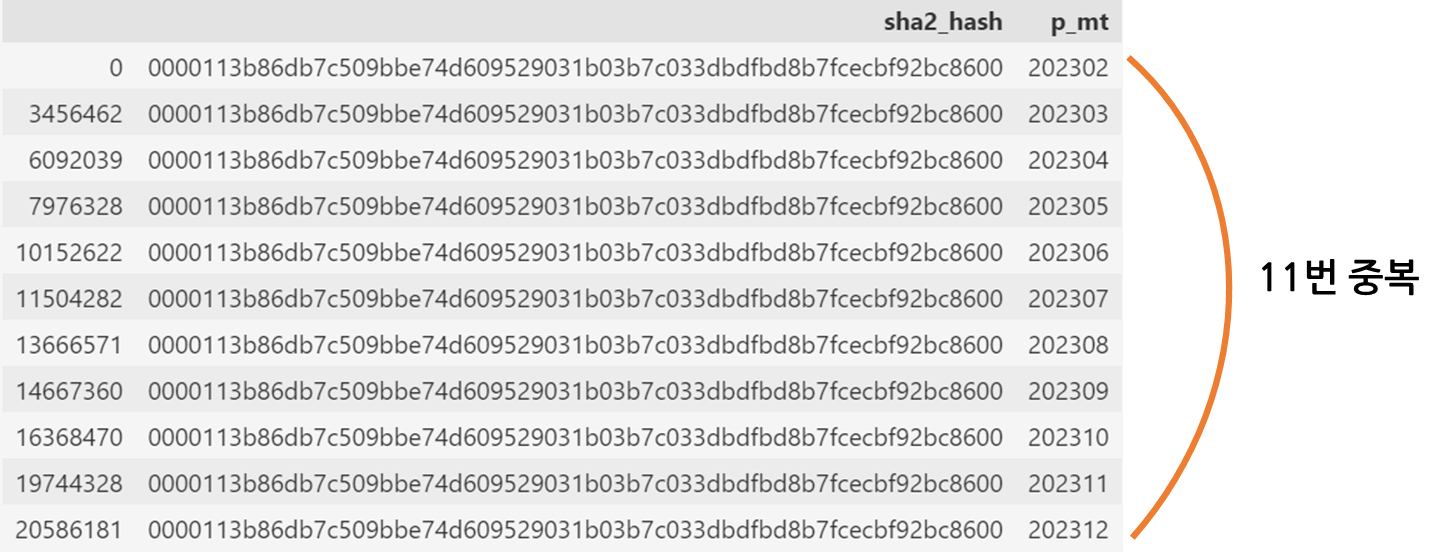

#### 약 93.65%의 유저가 sha2_hash가 11번으로 겹침. <br>해당 데이터에서는 대다수의 고객들이 서비스를 유지하고 있다고 판단됨.

In [8]:
print(len(df))
print(len(duplicated_11_rows))
print(f"11번 중복되지 않은 sha2_hash는 => {len(df) - len(duplicated_11_rows)}")

22476025
21047774
11번 중복되지 않은 sha2_hash는 => 1428251


sha2_hash가 11번 중복된 데이터를 제거하면 총 1,428,251개임!<br>
그러므로 11번 중복된 데이터를 제거한 데이터로 churn 여부를 판단하면 될 것 같음.

In [9]:
not_duplicated_11 = df['sha2_hash'].value_counts()[df['sha2_hash'].value_counts() != 11].index
not_duplicated_11_rows = df[df['sha2_hash'].isin(not_duplicated_11)]
not_duplicated_11_rows

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
24,f5a827ee455be834a79938f77fc1b6657c7b63374c0a8d91c00af24e502155ca,36개월 이상,HD,베이직,N,N,재약정,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20240730,3567,86.00,0.00,86.00,24.00,0.00,Y,N,N,110.00,3개월내없음,Y,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202302,None
87,ffaec8dcfe6e0f1f79a3cd3887105cc92615d6561a00ce551d84de2a6e9020e2,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,O/B,알수없음,약정만료전 12개월이상,20241026,2822,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,80대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202302,None
104,d99aa6d17d5100f7f31cbb6509f627bde0254de8a14464e4e2680b06a6c0782b,36개월 이상,HD,이코노미,N,Y,재약정,N,0건,0건,I/B,20.0,약정만료후 6~9개월,20220825,2379,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,50대,수신,수신,7.17,1.88,1.88,기타,0.00,N,N,202302,None
134,448982709bcdca1ad3a97e3fe690482617cf681fd0d48e42d6ef847d06248cc0,36개월 이상,HD,프리미엄,N,Y,약정승계,N,0건,0건,O/B,40.0,약정만료후 12개월이상,20170425,3702,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,50대,수신,수신,10.78,1.04,1.04,YTN,0.00,N,N,202302,None
162,732f222337bba6910635dcb753dd8d55cdac1840af733e245b712d1f090ae6da,36개월 이상,HD,이코노미,N,Y,재약정,Y,0건,0건,I/B,알수없음,약정만료전 3~6개월,20230618,3796,3.00,0.00,3.00,2.00,0.00,Y,N,N,5.00,3개월내없음,N,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202302,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22475840,4f69f5674af5e3f3efad6eacfe68241e88183da2d588fac9f5ec43f3add806f0,6개월~12개월미만,HD,이코노미,N,Y,신규,N,0건,0건,일반상담,0.0,약정만료전 12개월이상,20260509,2574,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,Y,Y,80대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,None
22475849,56eea513f06c5abc375f8fcefc36b8f0d7eaae2f2444b59bcf6a20021bab90d5,6개월미만,HD,이코노미,N,Y,신규,Y,0건,0건,I/B,알수없음,약정만료전 12개월이상,20260922,2872,4.00,0.00,4.00,1.00,0.00,Y,N,N,5.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,None
22475866,9a4f58110300a34268fe08207d34e7c5add558b627328ba0cd60ee121435ef4a,6개월미만,HD,베이직,N,Y,약정승계,N,0건,0건,I/B,20.0,약정만료전 12개월이상,20260427,3188,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,70대,전체거부,전체거부,3.29,4.63,4.63,KBS1,0.00,N,N,202311,None
22475913,61443c1b8c8efddd913525e8b22536a749d7411818c5efccc9746d886270394a,6개월미만,HD,이코노미,N,Y,신규,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20260704,357,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,일주일내,N,N,60대,전체거부,수신,0.87,0.00,0.00,기타,0.00,N,N,202311,None


In [ ]:
# 예상대로 1,428,251명이 존재한다

In [10]:
# 11번 겹친 유저가 있나 확인
not_duplicated_11_rows['sha2_hash'].value_counts()[not_duplicated_11_rows['sha2_hash'].value_counts() == 11].index

Index([], dtype='object', name='sha2_hash')

sha2_hash가 11번 중복되지 않은 유저들 위주로 csv를 새로 만들어서 진행

In [ ]:
not_duplicated_11_rows.to_csv('data/full_data/df_not_duplicated_11.csv', index=False)

In [11]:
# 데이터 불러오기
df_not_11 = pd.read_csv('data/full_data/df_not_duplicated_11.csv')

In [12]:
# 1,428,251명이 존재해야한다.

df_not_11

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
0,f5a827ee455be834a79938f77fc1b6657c7b63374c0a8d91c00af24e502155ca,36개월 이상,HD,베이직,N,N,재약정,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20240730,3567,86.00,0.00,86.00,24.00,0.00,Y,N,N,110.00,3개월내없음,Y,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202302,NaN
1,ffaec8dcfe6e0f1f79a3cd3887105cc92615d6561a00ce551d84de2a6e9020e2,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,O/B,알수없음,약정만료전 12개월이상,20241026,2822,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,80대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202302,NaN
2,d99aa6d17d5100f7f31cbb6509f627bde0254de8a14464e4e2680b06a6c0782b,36개월 이상,HD,이코노미,N,Y,재약정,N,0건,0건,I/B,20.0,약정만료후 6~9개월,20220825,2379,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,50대,수신,수신,7.17,1.88,1.88,기타,0.00,N,N,202302,NaN
3,448982709bcdca1ad3a97e3fe690482617cf681fd0d48e42d6ef847d06248cc0,36개월 이상,HD,프리미엄,N,Y,약정승계,N,0건,0건,O/B,40.0,약정만료후 12개월이상,20170425,3702,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,50대,수신,수신,10.78,1.04,1.04,YTN,0.00,N,N,202302,NaN
4,732f222337bba6910635dcb753dd8d55cdac1840af733e245b712d1f090ae6da,36개월 이상,HD,이코노미,N,Y,재약정,Y,0건,0건,I/B,알수없음,약정만료전 3~6개월,20230618,3796,3.00,0.00,3.00,2.00,0.00,Y,N,N,5.00,3개월내없음,N,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202302,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428246,4f69f5674af5e3f3efad6eacfe68241e88183da2d588fac9f5ec43f3add806f0,6개월~12개월미만,HD,이코노미,N,Y,신규,N,0건,0건,일반상담,0.0,약정만료전 12개월이상,20260509,2574,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,Y,Y,80대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,NaN
1428247,56eea513f06c5abc375f8fcefc36b8f0d7eaae2f2444b59bcf6a20021bab90d5,6개월미만,HD,이코노미,N,Y,신규,Y,0건,0건,I/B,알수없음,약정만료전 12개월이상,20260922,2872,4.00,0.00,4.00,1.00,0.00,Y,N,N,5.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,NaN
1428248,9a4f58110300a34268fe08207d34e7c5add558b627328ba0cd60ee121435ef4a,6개월미만,HD,베이직,N,Y,약정승계,N,0건,0건,I/B,20.0,약정만료전 12개월이상,20260427,3188,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,70대,전체거부,전체거부,3.29,4.63,4.63,KBS1,0.00,N,N,202311,NaN
1428249,61443c1b8c8efddd913525e8b22536a749d7411818c5efccc9746d886270394a,6개월미만,HD,이코노미,N,Y,신규,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20260704,357,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,일주일내,N,N,60대,전체거부,수신,0.87,0.00,0.00,기타,0.00,N,N,202311,NaN


---

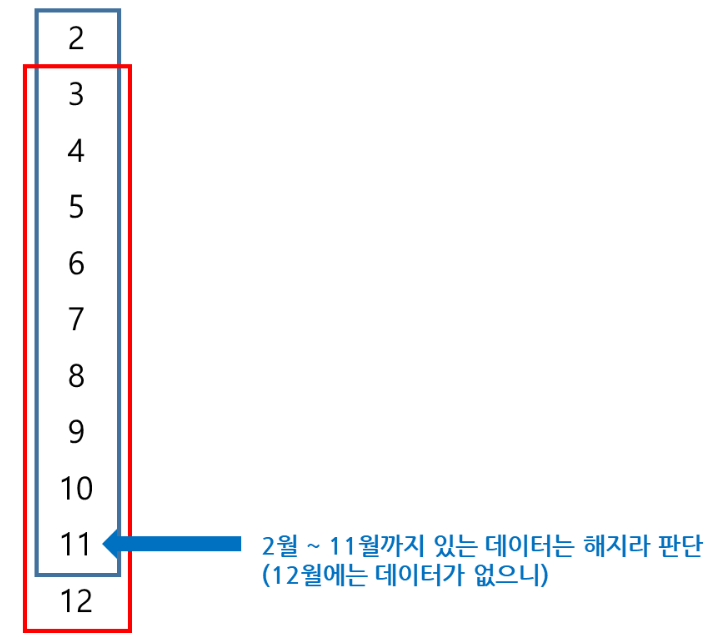

#### 11월 해지인 유저 찾은 뒤, churn 데이터에 Y 대입<br>
10번 중복된 유저들
- 2월 ~ 11월 / 3월 ~ 12월

In [13]:
id_counts = df_not_11['sha2_hash'].value_counts()
id_counts

sha2_hash
205bb54ce6d411652a8b44045a9e96a0921a0e1c5f5a0901d015f773db5fe9be    10
a972ca59c333f7f0896b5397dac6fae24ef9b5929a2d1f089488e94a60049a71    10
f1f2ca7970c03e009781411f975edadc43d4e84e7aae7193c6f0940d998c764d    10
a7ff264e76606613281e8739b34cbe4665893d0f2880b778cd4a5aa86a0b2cb2    10
cdd5a8fc1c0060b43be9a897b05157964d9f0f4bb5da09927e2a0644d4b824fc    10
                                                                    ..
5a65f8dbfdeae43637e42ef6068a927b5e633cf8ee140e6c8bebcadaf77a842f     1
e0a263fbb9f1fce0304d4d866bd9854c9b5b83befcbf54bea8b65a0ad783280a     1
9822ec0f57f18a0c386fa66be45db1ec475aa78eabd32b63236d93151fe9e6bb     1
877a21e4ce357448793b9b7b89bcc030ec180c2ad0a7d9751317da78a07a6b83     1
90e29d444a5d4b9870453e36173948fcb32f022e36dbf526b4f90f2e4d28d0a8     1
Name: count, Length: 262709, dtype: int64

In [14]:
# sha2_hash가 10번 중복된 유저들의 sha2_hash 빼내기
id_10 = id_counts[id_counts == 10].index
id_10

Index(['205bb54ce6d411652a8b44045a9e96a0921a0e1c5f5a0901d015f773db5fe9be',
       'a972ca59c333f7f0896b5397dac6fae24ef9b5929a2d1f089488e94a60049a71',
       'f1f2ca7970c03e009781411f975edadc43d4e84e7aae7193c6f0940d998c764d',
       'a7ff264e76606613281e8739b34cbe4665893d0f2880b778cd4a5aa86a0b2cb2',
       'cdd5a8fc1c0060b43be9a897b05157964d9f0f4bb5da09927e2a0644d4b824fc',
       '9a166fd04704626bd0d965655b2e8d4e3146761b9750fab5a85a2adb6a8f8f90',
       '50588473ba6c58bfc519a090967204707746ea3cef04b3a531bb2cc99e1854e4',
       '17ece08af0df400c6b299d9717c8b778b72e14064d191fb81712e2934ab676c3',
       '57245144537c26f6d93490787569b30e05218998021487da4237243e2e702a44',
       '5494b62b3c8b90af4bc113b05292b3790a5f9f34fcfc5b4202ad22d6c235334c',
       ...
       '04f2160d726cdfa0228ad2a690c15a6931d0f4759b89afa2d0fa5a565be8c2c3',
       '323c565ae2e4dae7537c44936f3970b3bbec9d4c2ca54f89bef94a6c2ec84655',
       '648932650aa0aaa209801e89fe09db9cf1e4f860d0ed660f8695b5323882bdbe',
       '10a55f

In [15]:
# df_not_11 데이터에서 확인

df_10_counts = df_not_11[df_not_11['sha2_hash'].isin(id_10)].sort_values(by = ['sha2_hash','p_mt'], ascending=[True, True])
df_10_counts

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
225842,0001e7fbf7b042d5859da08a8168b8c355e0b572c16134263d82168f6598b5dc,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200723,3698,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202302,NaN
43243,0001e7fbf7b042d5859da08a8168b8c355e0b572c16134263d82168f6598b5dc,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200723,3729,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202303,NaN
109587,0001e7fbf7b042d5859da08a8168b8c355e0b572c16134263d82168f6598b5dc,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200723,3759,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202304,NaN
719240,0001e7fbf7b042d5859da08a8168b8c355e0b572c16134263d82168f6598b5dc,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200723,3790,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202305,NaN
569716,0001e7fbf7b042d5859da08a8168b8c355e0b572c16134263d82168f6598b5dc,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200723,3820,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202306,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789791,fffe69a15fe995659e8be4de8c8b6dc72910ee05c7ab5e0a5bc7aeafb7ce8268,36개월 이상,HD,프리미엄,N,Y,재약정,N,0건,0건,O/B,40.0,약정만료후 12개월이상,20220103,2826,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,80대,수신,수신,6.59,2.30,2.30,기타,0.00,N,N,202307,NaN
1102625,fffe69a15fe995659e8be4de8c8b6dc72910ee05c7ab5e0a5bc7aeafb7ce8268,36개월 이상,HD,프리미엄,N,Y,재약정,N,0건,0건,O/B,40.0,약정만료후 12개월이상,20220103,2857,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,80대,수신,수신,8.50,1.17,1.17,기타,0.00,N,N,202308,NaN
1047659,fffe69a15fe995659e8be4de8c8b6dc72910ee05c7ab5e0a5bc7aeafb7ce8268,36개월 이상,HD,프리미엄,N,Y,재약정,N,0건,0건,O/B,40.0,약정만료후 12개월이상,20220103,2887,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,80대,수신,수신,9.11,1.33,1.33,SBS,0.00,N,N,202309,NaN
891930,fffe69a15fe995659e8be4de8c8b6dc72910ee05c7ab5e0a5bc7aeafb7ce8268,36개월 이상,HD,프리미엄,N,Y,재약정,N,0건,0건,O/B,40.0,약정만료후 12개월이상,20220103,2918,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,80대,수신,수신,8.05,0.24,0.24,기타,0.00,N,N,202310,NaN


In [16]:
# 각 유저들의 sha2_hash 중복을 없애고, p_mt가 max인 행을 남김

df_highest_month = df_10_counts.loc[df_10_counts.groupby('sha2_hash')['p_mt'].idxmax()]
df_highest_month

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
1405633,0001e7fbf7b042d5859da08a8168b8c355e0b572c16134263d82168f6598b5dc,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200723,3973,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,Y,Y,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,NaN
1377052,000b1297a13b9218591bbe32e32ca5ae18bed2b0aebdc7969b9efeef2fda5da6,6개월~12개월미만,UHD,베이직,N,N,신규,N,2건,0건,직영몰,50.0,약정만료전 12개월이상,20260306,299,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,30대,전체거부,전체거부,8.84,3.47,3.47,기타,0.00,N,Y,202312,NaN
1384733,000b8160f082c9a45bff0eaf266bb1516967e534c95135993038ecfaea7ef1d3,6개월~12개월미만,UHD,베이직,N,N,약정승계,N,0건,1건,현장경로,20.0,약정만료전 12개월이상,20260323,282,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,30대,전체거부,전체거부,4.79,2.33,2.33,기타,0.00,N,N,202312,NaN
1222000,000d37d221fde24ac6e422dbf5ed3045e90c24c54261e47c6eba79e246a30e29,6개월~12개월미만,HD,베이직,N,Y,신규,N,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260330,3198,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,일주일내,N,N,60대,전체거부,전체거부,1.93,0.00,0.00,기타,0.00,N,N,202312,NaN
1347207,000fb0fcc61e6334916deb45a9d96a423005865298ab23044ae7218c92f2a477,36개월 이상,HD,베이직,N,Y,재약정,N,0건,0건,현장경로,10.0,약정만료전 3~6개월,20240511,4364,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,일주일내,Y,Y,60대,수신,수신,3.08,4.99,4.99,기타,0.00,N,N,202311,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384497,ffef0af0590f7b148cc9d668b4e74ff075b8b0feb4033e2b08cb52cad7829633,6개월~12개월미만,HD,이코노미,N,Y,신규,N,0건,0건,일반상담,0.0,약정만료전 12개월이상,20260328,4230,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,3개월내없음,N,N,50대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202312,NaN
1258822,fff249172d16e9038fdc9afec9dfebd78cffa7e2ab9ae7cd1b5d2921055c3b70,6개월~12개월미만,UHD,이코노미,N,N,신규,N,0건,0건,일반상담,10.0,약정만료전 12개월이상,20260319,293,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,30대,전체거부,전체거부,2.43,2.28,2.28,기타,0.00,Y,Y,202312,NaN
1245892,fff793cf6e4d049bcf8f1fea3a98608eb61888747c48f95d09580fb0f2695e68,6개월~12개월미만,HD,이코노미,N,Y,신규,Y,0건,0건,일반상담,알수없음,약정만료전 12개월이상,20260302,2551,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,70대,전체거부,광고거부,0.00,0.00,0.00,기타,0.00,N,N,202312,NaN
1261827,fff83b6392c4ac6f4ade21237f851213a3f82b21d75ae59afd638da9fed4742b,36개월 이상,HD,이코노미,N,N,신규,N,0건,0건,현장경로,10.0,약정만료후 12개월이상,20221027,1525,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,50대,전체거부,전체거부,6.39,9.36,9.36,기타,0.00,N,N,202312,NaN


In [17]:
# p_mt의 최대값이 202311, 202312가 아닌 애들 확인 (없음)

df_highest_month[~df_highest_month['p_mt'].isin([202311, 202312])]

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn


In [18]:
# p_mt가 202311이 최댓값인 것은 해지데이터

terminated_accounts = df_highest_month[df_highest_month['p_mt'] == 202311]
terminated_accounts

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
1405633,0001e7fbf7b042d5859da08a8168b8c355e0b572c16134263d82168f6598b5dc,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200723,3973,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,Y,Y,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,NaN
1347207,000fb0fcc61e6334916deb45a9d96a423005865298ab23044ae7218c92f2a477,36개월 이상,HD,베이직,N,Y,재약정,N,0건,0건,현장경로,10.0,약정만료전 3~6개월,20240511,4364,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,일주일내,Y,Y,60대,수신,수신,3.08,4.99,4.99,기타,0.00,N,N,202311,NaN
1318094,001aeee68e389074a0e58e45b35380c0b18db669191d2faa66e2a6f0186dcce2,36개월 이상,HD,베이직,N,Y,약정승계,N,0건,0건,일반상담,20.0,약정만료후 12개월이상,20181122,2981,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,80대,전체거부,수신,3.44,0.01,0.01,연합뉴스TV,2.00,N,N,202311,NaN
1410170,001df44d417c70b96b1a38e4ac30d31eb98a8f5c981d299a83da59ff6588d27c,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료 1개월,20231123,1101,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,Y,50대,수신,수신,2.11,17.80,17.80,기타,0.00,N,N,202311,NaN
1194340,001e39717724e709e77c2b7729181c489795028057d5dce65ec8525c91557667,36개월 이상,HD,프리미엄,N,Y,약정승계,N,0건,0건,O/B,0.0,약정만료후 12개월이상,20180514,4089,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,2주일전,Y,Y,70대,수신,수신,2.34,0.00,0.00,기타,0.00,N,N,202311,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312431,ffe9855021008f6d6c238246c37e10878f39712550c4d3359e8116a53d9c9fb3,36개월 이상,HD,프리미엄,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20171116,3300,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,40대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,NaN
1304013,ffe9f8996cb31a616dfc7fb77e54c95ea9e6504acdb5973d023c3335890542e2,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,현장경로,20.0,약정만료후 3~6개월,20230825,1191,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,40대,전체거부,수신,4.17,1.62,1.62,기타,0.00,N,Y,202311,NaN
1403850,ffeaee04d5d0ae1b190a7a1a76f95e1bf75555dab50f6437608e262f4494c855,36개월 이상,HD,프리미엄,N,Y,약정승계,N,0건,1건,O/B,40.0,약정만료후 12개월이상,20221029,1492,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,50대,수신,수신,5.61,1.11,1.11,기타,0.00,N,N,202311,NaN
1192496,ffee555b4bd9d0f42bff6f0619f31a7a78421d21a40ebb130fffcb5bf9219cec,6개월~12개월미만,UHD,베이직,N,N,재약정,Y,0건,0건,O/B,알수없음,약정만료전 12개월이상,20260130,3152,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,3개월내없음,N,N,70대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,NaN


In [19]:
# df_not_11 데이터에 넣어서 확인

df_not_11[df_not_11['sha2_hash'].isin(terminated_accounts['sha2_hash'])].sort_values(by = ['sha2_hash','p_mt'], ascending=[True, True])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
225842,0001e7fbf7b042d5859da08a8168b8c355e0b572c16134263d82168f6598b5dc,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200723,3698,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202302,NaN
43243,0001e7fbf7b042d5859da08a8168b8c355e0b572c16134263d82168f6598b5dc,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200723,3729,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202303,NaN
109587,0001e7fbf7b042d5859da08a8168b8c355e0b572c16134263d82168f6598b5dc,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200723,3759,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202304,NaN
719240,0001e7fbf7b042d5859da08a8168b8c355e0b572c16134263d82168f6598b5dc,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200723,3790,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202305,NaN
569716,0001e7fbf7b042d5859da08a8168b8c355e0b572c16134263d82168f6598b5dc,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200723,3820,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202306,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789791,fffe69a15fe995659e8be4de8c8b6dc72910ee05c7ab5e0a5bc7aeafb7ce8268,36개월 이상,HD,프리미엄,N,Y,재약정,N,0건,0건,O/B,40.0,약정만료후 12개월이상,20220103,2826,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,80대,수신,수신,6.59,2.30,2.30,기타,0.00,N,N,202307,NaN
1102625,fffe69a15fe995659e8be4de8c8b6dc72910ee05c7ab5e0a5bc7aeafb7ce8268,36개월 이상,HD,프리미엄,N,Y,재약정,N,0건,0건,O/B,40.0,약정만료후 12개월이상,20220103,2857,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,80대,수신,수신,8.50,1.17,1.17,기타,0.00,N,N,202308,NaN
1047659,fffe69a15fe995659e8be4de8c8b6dc72910ee05c7ab5e0a5bc7aeafb7ce8268,36개월 이상,HD,프리미엄,N,Y,재약정,N,0건,0건,O/B,40.0,약정만료후 12개월이상,20220103,2887,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,80대,수신,수신,9.11,1.33,1.33,SBS,0.00,N,N,202309,NaN
891930,fffe69a15fe995659e8be4de8c8b6dc72910ee05c7ab5e0a5bc7aeafb7ce8268,36개월 이상,HD,프리미엄,N,Y,재약정,N,0건,0건,O/B,40.0,약정만료후 12개월이상,20220103,2918,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,80대,수신,수신,8.05,0.24,0.24,기타,0.00,N,N,202310,NaN


In [21]:
# 원래 데이터에서 확인

df[df['sha2_hash'] == '1fbd6552a041b646830e110ab5660b3048a6649df3d134f9aecb404a8a415bd1'].sort_values(by=['p_mt'])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
3460585,1fbd6552a041b646830e110ab5660b3048a6649df3d134f9aecb404a8a415bd1,6개월~12개월미만,UHD,베이직,N,N,신규,N,0건,0건,직영몰,20.0,약정만료전 12개월이상,20250325,339,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,5.60,5.16,5.16,KBS2,0.00,N,N,202302,None
4438127,1fbd6552a041b646830e110ab5660b3048a6649df3d134f9aecb404a8a415bd1,12개월~24개월미만,UHD,베이직,N,N,신규,N,0건,0건,직영몰,20.0,약정만료전 12개월이상,20250325,370,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,4.11,4.54,4.54,MBC,0.00,N,N,202303,None
5121267,1fbd6552a041b646830e110ab5660b3048a6649df3d134f9aecb404a8a415bd1,12개월~24개월미만,UHD,베이직,N,N,신규,N,0건,0건,직영몰,30.0,약정만료전 12개월이상,20250325,400,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,5.19,4.66,4.66,tvN,2.00,N,N,202304,None
7964757,1fbd6552a041b646830e110ab5660b3048a6649df3d134f9aecb404a8a415bd1,12개월~24개월미만,UHD,베이직,N,N,신규,N,0건,0건,직영몰,20.0,약정만료전 12개월이상,20250325,431,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,3.53,1.47,1.47,기타,0.00,N,N,202305,None
6976375,1fbd6552a041b646830e110ab5660b3048a6649df3d134f9aecb404a8a415bd1,12개월~24개월미만,UHD,베이직,N,N,신규,N,0건,0건,직영몰,20.0,약정만료전 12개월이상,20250325,461,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,1.67,4.82,4.82,tvN,1.00,N,N,202306,None
11698347,1fbd6552a041b646830e110ab5660b3048a6649df3d134f9aecb404a8a415bd1,12개월~24개월미만,UHD,베이직,N,N,신규,N,0건,0건,직영몰,10.0,약정만료전 12개월이상,20250325,492,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,2.18,9.81,9.81,기타,0.00,N,N,202307,None
18377102,1fbd6552a041b646830e110ab5660b3048a6649df3d134f9aecb404a8a415bd1,12개월~24개월미만,UHD,베이직,N,N,신규,N,0건,0건,직영몰,10.0,약정만료전 12개월이상,20250325,523,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,50대,수신,수신,2.92,5.29,5.29,기타,0.00,N,N,202308,None
16519319,1fbd6552a041b646830e110ab5660b3048a6649df3d134f9aecb404a8a415bd1,12개월~24개월미만,UHD,베이직,N,N,신규,N,0건,0건,직영몰,10.0,약정만료전 12개월이상,20250325,553,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,50대,수신,수신,2.42,1.71,1.71,기타,2.00,Y,N,202309,None
17490536,1fbd6552a041b646830e110ab5660b3048a6649df3d134f9aecb404a8a415bd1,12개월~24개월미만,UHD,베이직,N,N,신규,N,0건,0건,직영몰,10.0,약정만료전 12개월이상,20250325,584,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,0.74,0.06,0.06,기타,1.00,Y,N,202310,None
20657490,1fbd6552a041b646830e110ab5660b3048a6649df3d134f9aecb404a8a415bd1,12개월~24개월미만,UHD,베이직,N,N,신규,N,0건,0건,직영몰,10.0,약정만료전 12개월이상,20250325,614,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,4.11,5.44,5.44,기타,0.00,Y,N,202311,None


In [22]:
# 202311이 최대인 값들은 df churn 값에 Y, 아니면 N

df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'])) & (df['p_mt'] == 202311), 'churn'] = 'Y'

In [23]:
df[df['churn'] == 'Y']

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
18405741,4ba399ec5dd9453ec1e1f0be57aca8326cfb39f86055ddb8a48c341e2203c70b,24개월~ 36개월미만,UHD,프리미엄,N,N,신규,Y,0건,0건,현장경로,0.0,약정만료전 1개월,20231218,1076,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
18405968,a957b657632fc2c8b3dd14c1239b914aedff2c36d676c795f15da75df79961d6,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,현장경로,알수없음,약정만료 1개월,20231116,1108,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,60대,미응답,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
18406233,63817220b5cff6da9d993b5e43ef250e6732ac24992a12f76254c6d03fe69649,36개월 이상,HD,프리미엄,N,N,약정승계,N,0건,0건,O/B,10.0,약정만료후 12개월이상,20191122,2563,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,50대,전체거부,전체거부,5.58,0.00,0.00,MBC,0.00,N,N,202311,Y
18406670,a752ee45daf4b14538fb90f91e25fbc44c82788214b4819f1095292015593ebd,36개월 이상,HD,이코노미,N,N,약정승계,N,0건,0건,I/B,10.0,약정만료후 12개월이상,20160505,2658,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일전,Y,Y,70대,전체거부,수신,1.46,41.93,41.93,기타,0.00,N,N,202311,Y
18406695,437d36bfb3cef6ae49d7b37090f3a25d932aea1512bae29592237544a4c781b2,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20210322,3757,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,3개월내없음,N,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22474326,eff881138e842d13cb1e8fc2b35882e086fa7220a646334fd4a5929a85f37ac0,36개월 이상,HD,베이직,N,Y,신규,N,1건,0건,일반상담,10.0,약정만료후 12개월이상,20191005,2611,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일전,Y,N,50대,수신,수신,2.34,8.44,8.44,기타,0.00,N,N,202311,Y
22474652,f660b2ca3af8daf1f8adc1f9de6be5f3992ccdd1703e1f6ab338a88d299d3411,24개월~ 36개월미만,HD,베이직,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20141114,4398,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22474692,b25b6eaac676cc81966066e6f7f34f3e4492c1da49c62604c05f90fccf151a6d,36개월 이상,HD,이코노미,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20211205,3082,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,Y,80대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22475520,f43f2916dce3d59a455d3c3598021a93144e8a3a556aa2ec3837cc8f4b45963c,36개월 이상,HD,스탠다드,N,N,약정승계,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20160616,5211,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,30대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y


---

### 위와 같은 방식으로 10번 중복된 데이터, 9번 중복된 데이터, 8번, 7번 ... 쭉 확인해본다.

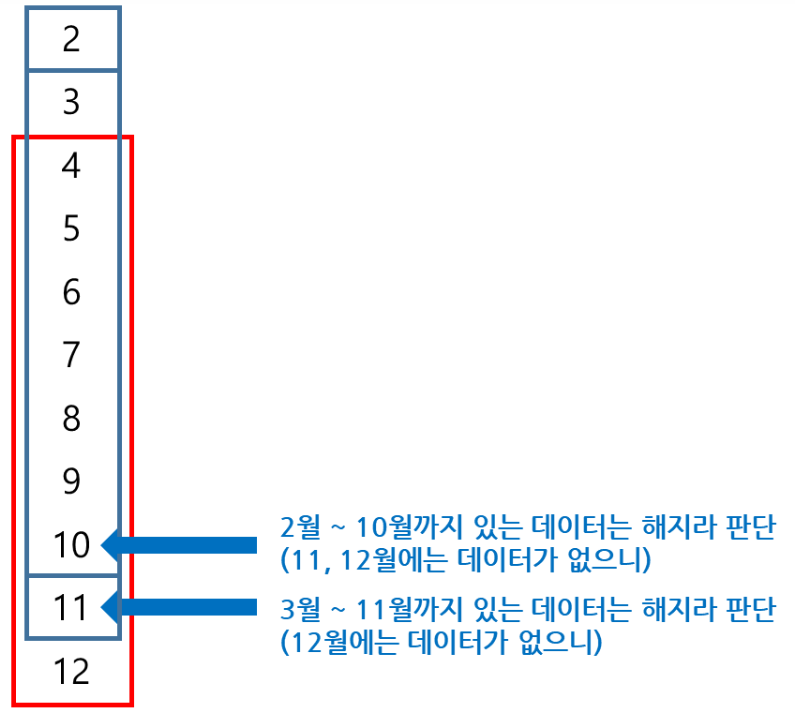

#### 10월 해지, 11월 해지 인 유저 찾은 뒤, churn 데이터에 Y 대입 <br>
9번 중복된 유저들
- 2월 ~ 10월 / 3월 ~ 11월 / 4월 ~ 12월

In [24]:
id_counts = df_not_11['sha2_hash'].value_counts()
id_counts

sha2_hash
205bb54ce6d411652a8b44045a9e96a0921a0e1c5f5a0901d015f773db5fe9be    10
a972ca59c333f7f0896b5397dac6fae24ef9b5929a2d1f089488e94a60049a71    10
f1f2ca7970c03e009781411f975edadc43d4e84e7aae7193c6f0940d998c764d    10
a7ff264e76606613281e8739b34cbe4665893d0f2880b778cd4a5aa86a0b2cb2    10
cdd5a8fc1c0060b43be9a897b05157964d9f0f4bb5da09927e2a0644d4b824fc    10
                                                                    ..
5a65f8dbfdeae43637e42ef6068a927b5e633cf8ee140e6c8bebcadaf77a842f     1
e0a263fbb9f1fce0304d4d866bd9854c9b5b83befcbf54bea8b65a0ad783280a     1
9822ec0f57f18a0c386fa66be45db1ec475aa78eabd32b63236d93151fe9e6bb     1
877a21e4ce357448793b9b7b89bcc030ec180c2ad0a7d9751317da78a07a6b83     1
90e29d444a5d4b9870453e36173948fcb32f022e36dbf526b4f90f2e4d28d0a8     1
Name: count, Length: 262709, dtype: int64

In [25]:
# sha2_hash가 9번 중복된 유저들의 sha2_hash 빼내기

id_09 = id_counts[id_counts == 9].index
id_09

Index(['1b9bd8e08022a4c8f7ac553561df66c74c6a4b0d9d8f4e5e2adc625dd6ab45d0',
       'b6883b3c24020db948fd5871684ae3fcdfde53f1b4e89dceb450fbf8af016947',
       '5d31bdf119fb0fc41f85f1a398a58541a3ad47f29bef448a5b00ac49fe21582e',
       '82a318544bd4ec42953a04293e7887580b847d28e9e38b49c019fc27ef92d573',
       'a55fe7095c13dc9f9231f5ecc0f4caf99d6ebfefec9aa51511d98a63e522432b',
       '22c69f03837931d78c42fe44f6510cedc12b926562ab168d4ee75dc85a36f543',
       '2738e3d03e3fd87c7023774fcc82c632fc44d3b9e8897c64f14f9ee0d5108655',
       '6f8388e28893e7f323650481bacf0a1fcb994c5def6ac86ed3a0721a15148c7e',
       '5ed7b07bd42780f641b41db9666a8b3790600c6b1dd3de5d9a1bd786d3908acc',
       '9c4cb4f8c33ee08121300a9a6451ad55f6cfe314aa6187bee2ce39cfad1b0f74',
       ...
       '8d7bb8911e9e5f95964c03918cc553eeaae8698c1e7958d09274be5d2aade7b1',
       '3619788a48908366932d1628cfb45376e5a83a33f09f15d2dd4866a765c4eed4',
       'b657628f8de7c083510233c457b5963856f6196668e9d2bfc5883c3d5680335f',
       '6b6148

In [26]:
# df_not_11 데이터에서 확인

df_09_counts = df_not_11[df_not_11['sha2_hash'].isin(id_09)].sort_values(by = ['sha2_hash','p_mt'], ascending=[True, True])
df_09_counts

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
16965,00039a3592a2093196a591a7919e585df168aa3457f51e3fdbb1e2287043b587,36개월 이상,HD,베이직,N,Y,신규,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200523,2106,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202302,NaN
387866,00039a3592a2093196a591a7919e585df168aa3457f51e3fdbb1e2287043b587,36개월 이상,HD,베이직,N,Y,신규,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200523,2137,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202303,NaN
217966,00039a3592a2093196a591a7919e585df168aa3457f51e3fdbb1e2287043b587,36개월 이상,HD,베이직,N,Y,신규,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200523,2167,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202304,NaN
682231,00039a3592a2093196a591a7919e585df168aa3457f51e3fdbb1e2287043b587,36개월 이상,HD,베이직,N,Y,신규,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200523,2198,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202305,NaN
484887,00039a3592a2093196a591a7919e585df168aa3457f51e3fdbb1e2287043b587,36개월 이상,HD,베이직,N,Y,신규,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200523,2228,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202306,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606201,fff894ced878a9c4f498b22cb0d736f0a09d6e18e131aaddeb09871c81029051,6개월~12개월미만,UHD,이코노미,N,N,신규,Y,0건,2건,현장경로,0.0,약정만료전 12개월이상,20260904,298,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,3개월내없음,N,N,50대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202306,NaN
749661,fff894ced878a9c4f498b22cb0d736f0a09d6e18e131aaddeb09871c81029051,6개월~12개월미만,UHD,이코노미,N,N,신규,Y,0건,2건,현장경로,알수없음,약정만료전 12개월이상,20260904,329,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,3개월내없음,N,N,50대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202307,NaN
984533,fff894ced878a9c4f498b22cb0d736f0a09d6e18e131aaddeb09871c81029051,6개월~12개월미만,UHD,이코노미,N,N,신규,Y,0건,2건,현장경로,알수없음,약정만료전 12개월이상,20260904,360,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,3개월내없음,Y,Y,50대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202308,NaN
851850,fff894ced878a9c4f498b22cb0d736f0a09d6e18e131aaddeb09871c81029051,12개월~24개월미만,UHD,이코노미,N,N,신규,Y,0건,2건,현장경로,알수없음,약정만료전 12개월이상,20260904,390,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,3개월내없음,N,N,50대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202309,NaN


In [27]:
# 각 유저들의 sha2_hash 중복을 없애고, p_mt가 max인 행을 남김

df_highest_month = df_09_counts.loc[df_09_counts.groupby('sha2_hash')['p_mt'].idxmax()]
df_highest_month

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
911737,00039a3592a2093196a591a7919e585df168aa3457f51e3fdbb1e2287043b587,36개월 이상,HD,베이직,N,Y,신규,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200523,2351,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202310,NaN
1225688,00061218b20c975f7089587abc4c315923d22ac37bcfe65e19dcdae923c7c49b,6개월~12개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,10.0,약정만료전 12개월이상,20260426,1698,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,70대,전체거부,전체거부,2.01,0.55,0.55,MBN,0.00,N,N,202312,NaN
1372837,0009e31cc4add3482cb2d3af929b941dc3f687bf2f3d1278259f9926f745f1f1,6개월~12개월미만,HD,이코노미,N,Y,신규,N,0건,0건,O/B,10.0,약정만료전 12개월이상,20260420,2375,3.00,0.00,3.00,1.00,1.00,Y,Y,N,4.00,일주일내,Y,N,40대,수신,수신,4.36,3.17,3.17,EBS,0.00,N,N,202312,NaN
1238529,000aadb382d60fa765976b291faf9806f25e94904fa4d7f002edf0e888a0315f,6개월~12개월미만,UHD,이코노미,N,N,신규,N,0건,0건,O/B,0.0,약정만료전 12개월이상,20260412,262,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,30대,전체거부,수신,2.94,0.00,0.00,MBC,0.00,Y,Y,202312,NaN
882023,000f594334ea6fa9fab1b98a41810fa22b3a2c0a6c5c5fa3f9c113e1d8c538a4,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,I/B,10.0,약정만료전 12개월이상,20260910,3528,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,Y,60대,수신,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202310,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292510,ffef4f3f7490d32eda22fada8dd9ab293d0bd25cf64e410652f9cd138cf3f6ae,36개월 이상,HD,베이직,N,N,신규,N,0건,1건,현장경로,0.0,약정만료후 3~6개월,20230727,1618,19.00,0.00,19.00,4.00,0.00,Y,N,N,23.00,일주일내,Y,Y,60대,전체거부,전체거부,1.59,0.06,0.06,KBS1,0.00,N,N,202312,NaN
1249760,fff43e404e20060d85601c56d1f116bccf5a528f072fca37600b326e33ab5377,6개월~12개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20260411,263,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,30대,전체거부,전체거부,1.85,5.66,5.66,SBS,2.00,Y,Y,202312,NaN
1273883,fff4d3d17b5f4233c4426db3547fc8727f2f03d279df850feeb7f1134bdecee0,6개월~12개월미만,UHD,베이직,N,N,신규,N,0건,0건,O/B,0.0,약정만료전 12개월이상,20260421,253,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,N,N,30대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202312,NaN
1126193,fff861477ab6818b7cea8f631d5a7ab5dbc15a251e69a8ff16770038b6d37dca,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,현장경로,0.0,약정만료전 12개월이상,20241108,2193,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,2주일전,N,N,30대,수신,수신,2.02,17.96,17.96,기타,0.00,N,N,202310,NaN


In [28]:
# p_mt의 최대값이 202310, 202311, 202312가 아닌 애들 확인 (없음)

df_highest_month[~df_highest_month['p_mt'].isin([202310, 202311, 202312])]

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn


In [29]:
# p_mt가 202310, 202311이 최댓값인 것은 해지데이터

terminated_accounts = df_highest_month[df_highest_month['p_mt'].isin([202310, 202311])]
terminated_accounts

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
911737,00039a3592a2093196a591a7919e585df168aa3457f51e3fdbb1e2287043b587,36개월 이상,HD,베이직,N,Y,신규,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200523,2351,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202310,NaN
882023,000f594334ea6fa9fab1b98a41810fa22b3a2c0a6c5c5fa3f9c113e1d8c538a4,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,I/B,10.0,약정만료전 12개월이상,20260910,3528,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,Y,60대,수신,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202310,NaN
1008199,0012fa3972f2a331aaa9c325514c41b3de91701b60fb1c2548a61bdd70dc32da,36개월 이상,HD,베이직,N,Y,재약정,N,0건,0건,O/B,30.0,약정만료전 12개월이상,20260328,1225,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,50대,수신,수신,5.56,3.69,3.69,MBN,0.00,N,N,202310,NaN
1001722,001440858ae6492d831264ade90c927e13aa2610e740d561c9d1857439f1868a,36개월 이상,HD,이코노미,N,N,신규,Y,0건,0건,I/B,알수없음,약정만료후 12개월이상,20170525,3445,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,N,70대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202310,NaN
870254,001dd39eedfccd697476a3e7ee159144e191962e4372f5be635d7bfef021e664,36개월 이상,HD,프리미엄,N,N,약정승계,N,0건,0건,일반상담,40.0,약정만료후 12개월이상,20171225,3231,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,60대,전체거부,광고거부,8.32,0.65,0.65,KBS1,0.00,N,N,202310,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914739,ffe4d0ff51fb0ab6587938eeed217241d34cf87570a9ba98a66a538ac7156f29,36개월 이상,HD,베이직,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20170921,3326,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,60대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202310,NaN
1001797,ffe6282ff56347f25244114c8fc1635d8d03afc60a435c6a1832bf68dc425d14,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,I/B,알수없음,약정만료전 1개월,20231112,3345,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,3개월내없음,N,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202310,NaN
1140044,ffea65adb9dfd1c3cdd45acd92a53cc2fc1f7c9796b50cce63fed2e49051fdff,24개월~ 36개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,일반상담,30.0,약정만료후 12개월이상,20220123,1741,2.00,1.00,1.00,1.00,1.00,Y,Y,Y,3.00,일주일내,N,N,60대,수신,수신,6.52,4.25,4.25,KBS2,0.00,Y,Y,202310,NaN
1126193,fff861477ab6818b7cea8f631d5a7ab5dbc15a251e69a8ff16770038b6d37dca,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,현장경로,0.0,약정만료전 12개월이상,20241108,2193,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,2주일전,N,N,30대,수신,수신,2.02,17.96,17.96,기타,0.00,N,N,202310,NaN


In [30]:
display(terminated_accounts[terminated_accounts['p_mt'] == 202310])
display(terminated_accounts[terminated_accounts['p_mt'] == 202311])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
911737,00039a3592a2093196a591a7919e585df168aa3457f51e3fdbb1e2287043b587,36개월 이상,HD,베이직,N,Y,신규,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200523,2351,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202310,NaN
882023,000f594334ea6fa9fab1b98a41810fa22b3a2c0a6c5c5fa3f9c113e1d8c538a4,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,I/B,10.0,약정만료전 12개월이상,20260910,3528,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,Y,60대,수신,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202310,NaN
1008199,0012fa3972f2a331aaa9c325514c41b3de91701b60fb1c2548a61bdd70dc32da,36개월 이상,HD,베이직,N,Y,재약정,N,0건,0건,O/B,30.0,약정만료전 12개월이상,20260328,1225,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,50대,수신,수신,5.56,3.69,3.69,MBN,0.00,N,N,202310,NaN
1001722,001440858ae6492d831264ade90c927e13aa2610e740d561c9d1857439f1868a,36개월 이상,HD,이코노미,N,N,신규,Y,0건,0건,I/B,알수없음,약정만료후 12개월이상,20170525,3445,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,N,70대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202310,NaN
870254,001dd39eedfccd697476a3e7ee159144e191962e4372f5be635d7bfef021e664,36개월 이상,HD,프리미엄,N,N,약정승계,N,0건,0건,일반상담,40.0,약정만료후 12개월이상,20171225,3231,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,60대,전체거부,광고거부,8.32,0.65,0.65,KBS1,0.00,N,N,202310,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914739,ffe4d0ff51fb0ab6587938eeed217241d34cf87570a9ba98a66a538ac7156f29,36개월 이상,HD,베이직,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20170921,3326,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,60대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202310,NaN
1001797,ffe6282ff56347f25244114c8fc1635d8d03afc60a435c6a1832bf68dc425d14,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,I/B,알수없음,약정만료전 1개월,20231112,3345,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,3개월내없음,N,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202310,NaN
1140044,ffea65adb9dfd1c3cdd45acd92a53cc2fc1f7c9796b50cce63fed2e49051fdff,24개월~ 36개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,일반상담,30.0,약정만료후 12개월이상,20220123,1741,2.00,1.00,1.00,1.00,1.00,Y,Y,Y,3.00,일주일내,N,N,60대,수신,수신,6.52,4.25,4.25,KBS2,0.00,Y,Y,202310,NaN
1126193,fff861477ab6818b7cea8f631d5a7ab5dbc15a251e69a8ff16770038b6d37dca,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,현장경로,0.0,약정만료전 12개월이상,20241108,2193,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,2주일전,N,N,30대,수신,수신,2.02,17.96,17.96,기타,0.00,N,N,202310,NaN


,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
1213077,00cda56807e26ef75e3941ca978284c681eae23c429e2604799643b8b93dac33,6개월~12개월미만,UHD,프리미엄,N,N,신규,N,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20260326,513,2.00,0.00,2.00,2.00,2.00,Y,Y,N,4.00,3개월내없음,Y,N,20대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,NaN
1202647,031ef343c97fc085f8b1c99cf08062d4fb51990e2b6587e412b8d51b24895649,6개월~12개월미만,UHD,이코노미,N,N,신규,Y,0건,0건,I/B,알수없음,약정만료전 12개월이상,20260306,268,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,50대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,NaN
1326130,04b24fc21996b0542003cfdbf81937b59c533d2cb8f844f5af3524225f37d6aa,36개월 이상,HD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료후 12개월이상,20210730,2317,10.00,0.00,10.00,4.00,0.00,Y,N,N,14.00,일주일내,Y,N,60대,수신,수신,4.48,0.03,0.03,기타,0.00,N,N,202311,NaN
1202648,05386206a0c12b8572ed9830266e73bddc3a6dcdfcf2fef2b55b306e85423cc6,6개월~12개월미만,UHD,베이직,N,Y,신규,N,0건,0건,현장경로,30.0,약정만료전 12개월이상,20260307,267,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,60대,전체거부,전체거부,6.98,3.10,3.10,기타,0.00,N,Y,202311,NaN
1301586,05c5ef3865f09520028999702905720715904305394e65cfef2218c6416f2a0f,6개월~12개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,I/B,20.0,약정만료전 12개월이상,20260324,250,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일전,N,N,60대,전체거부,전체거부,5.01,2.47,2.47,기타,0.00,N,N,202311,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391828,fc73ab8069a96d98df20a9dc9e68c313cb7382ba2b96d0864fc8b41127e590d2,36개월 이상,HD,프리미엄,N,N,약정승계,Y,1건,0건,현장경로,알수없음,약정만료후 12개월이상,20210730,2317,10.00,0.00,10.00,4.00,0.00,Y,N,N,14.00,3개월내없음,Y,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,NaN
1313233,fd01f0d294b0881a649216e11269daa2b8d9d3864cf3ce1e59d4b6892a70a21e,6개월~12개월미만,UHD,프리미엄,N,N,신규,N,0건,0건,현장경로,20.0,약정만료전 12개월이상,20260319,255,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,전체거부,전체거부,4.88,4.19,4.19,기타,0.00,Y,Y,202311,NaN
1353556,fe9b129f66062cf31e8956c730156dc7cc3208cb8c9be031c4b1177afe39bc1f,6개월~12개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,30.0,약정만료전 12개월이상,20260310,264,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,40대,전체거부,전체거부,7.75,1.42,1.42,기타,0.00,N,N,202311,NaN
1400054,ff4a5a2b23a424c2fe1bfc51f0420146c2b9410da24650a502b40dc9d15fc88f,6개월~12개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20260301,273,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,70대,전체거부,전체거부,0.66,0.74,0.74,기타,0.00,N,Y,202311,NaN


In [31]:
df[df['sha2_hash'] == 'fe9b129f66062cf31e8956c730156dc7cc3208cb8c9be031c4b1177afe39bc1f']

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
1265751,fe9b129f66062cf31e8956c730156dc7cc3208cb8c9be031c4b1177afe39bc1f,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20260310,50,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,40대,전체거부,전체거부,5.53,1.70,1.70,연합뉴스TV,1.00,N,Y,202304,None
4045468,fe9b129f66062cf31e8956c730156dc7cc3208cb8c9be031c4b1177afe39bc1f,6개월미만,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260310,20,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,40대,전체거부,전체거부,4.70,1.21,1.21,YTN,1.00,N,N,202303,None
8192856,fe9b129f66062cf31e8956c730156dc7cc3208cb8c9be031c4b1177afe39bc1f,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20260310,142,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,40대,전체거부,전체거부,7.14,6.14,6.14,YTN,0.00,N,Y,202307,None
10183197,fe9b129f66062cf31e8956c730156dc7cc3208cb8c9be031c4b1177afe39bc1f,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20260310,111,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,40대,전체거부,전체거부,4.24,2.57,2.57,기타,0.00,N,N,202306,None
10957320,fe9b129f66062cf31e8956c730156dc7cc3208cb8c9be031c4b1177afe39bc1f,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20260310,81,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,40대,전체거부,전체거부,5.39,2.39,2.39,YTN,0.00,N,N,202305,None
13199086,fe9b129f66062cf31e8956c730156dc7cc3208cb8c9be031c4b1177afe39bc1f,6개월~12개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20260310,203,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,40대,전체거부,전체거부,6.17,4.49,4.49,연합뉴스TV,0.00,N,N,202309,None
13916699,fe9b129f66062cf31e8956c730156dc7cc3208cb8c9be031c4b1177afe39bc1f,6개월~12개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,20.0,약정만료전 12개월이상,20260310,234,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,40대,전체거부,전체거부,8.01,1.98,1.98,YTN,0.00,N,N,202310,None
14992520,fe9b129f66062cf31e8956c730156dc7cc3208cb8c9be031c4b1177afe39bc1f,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20260310,173,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,40대,전체거부,전체거부,6.40,1.81,1.81,기타,0.00,N,N,202308,None
21232292,fe9b129f66062cf31e8956c730156dc7cc3208cb8c9be031c4b1177afe39bc1f,6개월~12개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,30.0,약정만료전 12개월이상,20260310,264,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,40대,전체거부,전체거부,7.75,1.42,1.42,기타,0.00,N,N,202311,None


In [32]:
# 202310, 202311이 최대인 값들은 df churn 값에 Y, 아니면 N

df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'])) & (df['p_mt'] == 202311),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'])) & (df['p_mt'] == 202310),'churn'] = 'Y'

In [33]:
df[(df['churn'] == 'Y') & (df['p_mt'] == 202311)]

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
18405741,4ba399ec5dd9453ec1e1f0be57aca8326cfb39f86055ddb8a48c341e2203c70b,24개월~ 36개월미만,UHD,프리미엄,N,N,신규,Y,0건,0건,현장경로,0.0,약정만료전 1개월,20231218,1076,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
18405968,a957b657632fc2c8b3dd14c1239b914aedff2c36d676c795f15da75df79961d6,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,현장경로,알수없음,약정만료 1개월,20231116,1108,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,60대,미응답,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
18406233,63817220b5cff6da9d993b5e43ef250e6732ac24992a12f76254c6d03fe69649,36개월 이상,HD,프리미엄,N,N,약정승계,N,0건,0건,O/B,10.0,약정만료후 12개월이상,20191122,2563,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,50대,전체거부,전체거부,5.58,0.00,0.00,MBC,0.00,N,N,202311,Y
18406670,a752ee45daf4b14538fb90f91e25fbc44c82788214b4819f1095292015593ebd,36개월 이상,HD,이코노미,N,N,약정승계,N,0건,0건,I/B,10.0,약정만료후 12개월이상,20160505,2658,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일전,Y,Y,70대,전체거부,수신,1.46,41.93,41.93,기타,0.00,N,N,202311,Y
18406695,437d36bfb3cef6ae49d7b37090f3a25d932aea1512bae29592237544a4c781b2,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20210322,3757,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,3개월내없음,N,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22474326,eff881138e842d13cb1e8fc2b35882e086fa7220a646334fd4a5929a85f37ac0,36개월 이상,HD,베이직,N,Y,신규,N,1건,0건,일반상담,10.0,약정만료후 12개월이상,20191005,2611,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일전,Y,N,50대,수신,수신,2.34,8.44,8.44,기타,0.00,N,N,202311,Y
22474652,f660b2ca3af8daf1f8adc1f9de6be5f3992ccdd1703e1f6ab338a88d299d3411,24개월~ 36개월미만,HD,베이직,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20141114,4398,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22474692,b25b6eaac676cc81966066e6f7f34f3e4492c1da49c62604c05f90fccf151a6d,36개월 이상,HD,이코노미,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20211205,3082,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,Y,80대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22475520,f43f2916dce3d59a455d3c3598021a93144e8a3a556aa2ec3837cc8f4b45963c,36개월 이상,HD,스탠다드,N,N,약정승계,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20160616,5211,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,30대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y


In [34]:
df[df['churn'] == 'Y']

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
13244659,64fed237494f237bfae17770cb0155f0558a33ddc4c0cb3a6f6f5587099072e5,36개월 이상,UHD,프리미엄,N,N,약정승계,Y,0건,0건,O/B,알수없음,약정만료후 9~12개월,20221106,1454,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,30대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202310,Y
13244685,827ebd9b8a8836801dd841c58d2ff1401b94a49efec42cda1e76c7d9d6656bde,6개월~12개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,현장경로,30.0,약정만료후 12개월이상,20200622,2321,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,Y,80대,수신,수신,5.36,3.60,3.60,연합뉴스TV,2.00,Y,Y,202310,Y
13245127,ecaed571db5dd4ed88f6b8f93be87b489a8b1b38aece2d1892cfb359684c64d5,36개월 이상,HD,베이직,N,N,신규,N,0건,0건,현장경로,20.0,약정만료후 12개월이상,20210319,2051,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,Y,30대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202310,Y
13245183,c1c3ddf7d9f3cbb276cce312e02ec50766451304ca94eb4df1e622a5c42913f0,36개월 이상,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20210419,2020,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,3개월내없음,N,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202310,Y
13245212,e77f497a02f3c75bd942e06344eb8e4e6217ed2567e7b097de309e6a61da72a7,12개월~24개월미만,HD,베이직,N,N,약정승계,Y,0건,0건,I/B,0.0,약정만료후 12개월이상,20211220,1999,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,70대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202310,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22474326,eff881138e842d13cb1e8fc2b35882e086fa7220a646334fd4a5929a85f37ac0,36개월 이상,HD,베이직,N,Y,신규,N,1건,0건,일반상담,10.0,약정만료후 12개월이상,20191005,2611,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일전,Y,N,50대,수신,수신,2.34,8.44,8.44,기타,0.00,N,N,202311,Y
22474652,f660b2ca3af8daf1f8adc1f9de6be5f3992ccdd1703e1f6ab338a88d299d3411,24개월~ 36개월미만,HD,베이직,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20141114,4398,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22474692,b25b6eaac676cc81966066e6f7f34f3e4492c1da49c62604c05f90fccf151a6d,36개월 이상,HD,이코노미,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20211205,3082,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,Y,80대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22475520,f43f2916dce3d59a455d3c3598021a93144e8a3a556aa2ec3837cc8f4b45963c,36개월 이상,HD,스탠다드,N,N,약정승계,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20160616,5211,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,30대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y


In [48]:
df[df['sha2_hash'] == 'c1c3ddf7d9f3cbb276cce312e02ec50766451304ca94eb4df1e622a5c42913f0'].sort_values(by=['p_mt'])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
5342915,c1c3ddf7d9f3cbb276cce312e02ec50766451304ca94eb4df1e622a5c42913f0,36개월 이상,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20210419,1775,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,3개월내없음,N,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202302,None
4354431,c1c3ddf7d9f3cbb276cce312e02ec50766451304ca94eb4df1e622a5c42913f0,36개월 이상,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20210419,1806,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,3개월내없음,N,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202303,None
988854,c1c3ddf7d9f3cbb276cce312e02ec50766451304ca94eb4df1e622a5c42913f0,36개월 이상,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20210419,1836,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,3개월내없음,N,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202304,None
7766813,c1c3ddf7d9f3cbb276cce312e02ec50766451304ca94eb4df1e622a5c42913f0,36개월 이상,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20210419,1867,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,3개월내없음,N,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202305,None
8802622,c1c3ddf7d9f3cbb276cce312e02ec50766451304ca94eb4df1e622a5c42913f0,36개월 이상,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20210419,1897,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,3개월내없음,N,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202306,None
11987143,c1c3ddf7d9f3cbb276cce312e02ec50766451304ca94eb4df1e622a5c42913f0,36개월 이상,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20210419,1928,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,3개월내없음,N,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202307,None
15385620,c1c3ddf7d9f3cbb276cce312e02ec50766451304ca94eb4df1e622a5c42913f0,36개월 이상,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20210419,1959,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,3개월내없음,N,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202308,None
16171119,c1c3ddf7d9f3cbb276cce312e02ec50766451304ca94eb4df1e622a5c42913f0,36개월 이상,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20210419,1989,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,3개월내없음,N,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202309,None
13245183,c1c3ddf7d9f3cbb276cce312e02ec50766451304ca94eb4df1e622a5c42913f0,36개월 이상,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20210419,2020,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,3개월내없음,N,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202310,Y


---

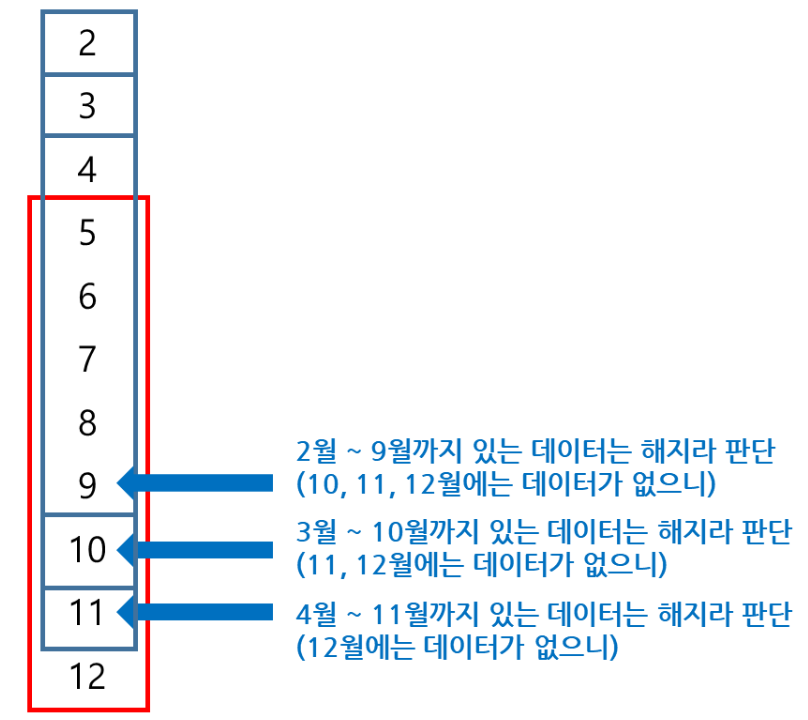

#### 9월 해지, 10월 해지, 11월 해지인 유저 찾은 뒤, churn 데이터에 Y 대입 <br>
8번 중복된 유저들
- 2월 ~ 9월 / 3월 ~ 10월 / 4월 ~ 11월 / 5월 ~ 12월

In [35]:
id_counts = df_not_11['sha2_hash'].value_counts()
id_counts

sha2_hash
205bb54ce6d411652a8b44045a9e96a0921a0e1c5f5a0901d015f773db5fe9be    10
a972ca59c333f7f0896b5397dac6fae24ef9b5929a2d1f089488e94a60049a71    10
f1f2ca7970c03e009781411f975edadc43d4e84e7aae7193c6f0940d998c764d    10
a7ff264e76606613281e8739b34cbe4665893d0f2880b778cd4a5aa86a0b2cb2    10
cdd5a8fc1c0060b43be9a897b05157964d9f0f4bb5da09927e2a0644d4b824fc    10
                                                                    ..
5a65f8dbfdeae43637e42ef6068a927b5e633cf8ee140e6c8bebcadaf77a842f     1
e0a263fbb9f1fce0304d4d866bd9854c9b5b83befcbf54bea8b65a0ad783280a     1
9822ec0f57f18a0c386fa66be45db1ec475aa78eabd32b63236d93151fe9e6bb     1
877a21e4ce357448793b9b7b89bcc030ec180c2ad0a7d9751317da78a07a6b83     1
90e29d444a5d4b9870453e36173948fcb32f022e36dbf526b4f90f2e4d28d0a8     1
Name: count, Length: 262709, dtype: int64

In [36]:
# sha2_hash가 8번 중복된 유저들의 sha2_hash 빼내기

id_08 = id_counts[id_counts == 8].index
id_08

Index(['cd0523b9218996a6d71036e5061bb8368f18f4e77093393c92e615c19f12b1a1',
       'f14300d513bad58829c0f99a7d48eae00ea86fc3e16703df8e6dcf50d13efec9',
       '75952b5b6777c3797dc8b82c9ea712b42285104a834c1589a880f69f6d17c298',
       '702f83260f1666121300f28318acecf451e46850ed8ccb7fb8d7ebe8c508b273',
       '6bfc69be441aa0ad340c4b15defffbaf00c261ea1718317b471f4ad40d8e2e4e',
       'f9783df0cabddd8aace415e9a86b17915785fbe5f09683b467315467097aa47b',
       '29ca32cc7c9201dacf683ccec7e23e437a1ec8f54bde3437b03bc5f282fbc770',
       'c424834686daf5ce5bc28c92b80600eb0a5eaae3bf61e6f7db69ce51bf6a9308',
       'f03b4a45819ba44e3b958d1fc14685ffe31aa2609640df2ae6b0960bba3fa329',
       '140d7df9740aa68973283ae91e228aff308918dde004f936f0bf46dd295fc57c',
       ...
       'eeff666cfbdf4eb71b05fc809065f2418641cb0574bf62c513c16a140a589919',
       '74a4fe6cbe2623a84dd95241b69c626e5b602a9ee42e3eddf6c94dc8b85191a7',
       '9fb9a12a85cdea71af0ab1c1e1aaeb6c2c832193018485d097c971f422c007a3',
       '6e2bae

In [37]:
# df_not_11 데이터에서 확인

df_08_counts = df_not_11[df_not_11['sha2_hash'].isin(id_08)].sort_values(by = ['sha2_hash','p_mt'], ascending=[True, True])
df_08_counts

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
721188,0001ab8ff26ffa9d1904b8e1b02e1deee273b46aa5be8704f6123f6055aaa1fe,6개월미만,HD,베이직,N,Y,신규,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260515,2672,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,Y,N,60대,전체거부,전체거부,1.48,0.28,0.28,JTBC,0.00,N,N,202305,NaN
574001,0001ab8ff26ffa9d1904b8e1b02e1deee273b46aa5be8704f6123f6055aaa1fe,6개월미만,HD,베이직,N,Y,신규,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20260515,2702,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,60대,전체거부,전체거부,2.12,1.08,1.08,기타,1.00,N,N,202306,NaN
760762,0001ab8ff26ffa9d1904b8e1b02e1deee273b46aa5be8704f6123f6055aaa1fe,6개월미만,HD,베이직,N,Y,신규,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20260515,2733,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,60대,전체거부,전체거부,2.19,2.34,2.34,MBC,1.00,N,N,202307,NaN
1179053,0001ab8ff26ffa9d1904b8e1b02e1deee273b46aa5be8704f6123f6055aaa1fe,6개월미만,HD,베이직,N,Y,신규,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20260515,2764,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,60대,전체거부,전체거부,2.52,2.15,2.15,기타,0.00,N,N,202308,NaN
1038013,0001ab8ff26ffa9d1904b8e1b02e1deee273b46aa5be8704f6123f6055aaa1fe,6개월미만,HD,베이직,N,Y,신규,N,0건,0건,현장경로,20.0,약정만료전 12개월이상,20260515,2794,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,60대,전체거부,전체거부,3.89,2.85,2.85,기타,1.00,N,N,202309,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522714,fffc590159552b391424c35d5360fe8625d9b9be93555c64f73d545f03bf643b,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,50.0,약정만료전 12개월이상,20240912,1619,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,50대,수신,수신,8.70,0.09,0.09,기타,0.00,N,N,202305,NaN
466503,fffc590159552b391424c35d5360fe8625d9b9be93555c64f73d545f03bf643b,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,40.0,약정만료전 12개월이상,20240912,1649,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,N,50대,수신,수신,7.63,1.23,1.23,기타,0.00,N,N,202306,NaN
792007,fffc590159552b391424c35d5360fe8625d9b9be93555c64f73d545f03bf643b,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,50.0,약정만료전 12개월이상,20240912,1680,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,N,50대,수신,수신,11.63,0.60,0.60,기타,0.00,N,N,202307,NaN
1183273,fffc590159552b391424c35d5360fe8625d9b9be93555c64f73d545f03bf643b,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,50.0,약정만료전 12개월이상,20240912,1711,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,N,50대,수신,수신,10.97,0.44,0.44,기타,0.00,N,N,202308,NaN


In [38]:
# 각 유저들의 sha2_hash 중복을 없애고, p_mt가 max인 행을 남김

df_highest_month = df_08_counts.loc[df_08_counts.groupby('sha2_hash')['p_mt'].idxmax()]
df_highest_month

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
1378648,0001ab8ff26ffa9d1904b8e1b02e1deee273b46aa5be8704f6123f6055aaa1fe,6개월~12개월미만,HD,베이직,N,Y,신규,N,0건,0건,현장경로,20.0,약정만료전 12개월이상,20260515,2886,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,60대,전체거부,전체거부,4.47,0.81,0.81,KBS2,0.00,N,N,202312,NaN
1375947,0002a102f968653d111bef88d347fa0e60397ffd47505adfaf1062bb0ea58718,6개월~12개월미만,UHD,이코노미,N,N,신규,N,0건,0건,현장경로,30.0,약정만료전 12개월이상,20260511,233,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,50대,전체거부,전체거부,5.71,6.74,6.74,기타,56.00,N,Y,202312,NaN
857025,0007cdc961eacf88af56af09112cd99ca71662ca4041a77319495be9ab9fc29e,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,현장경로,80.0,약정만료전 9~12개월,20240729,3575,2.00,1.00,1.00,1.00,1.00,Y,Y,Y,3.00,일주일내,N,N,30대,수신,수신,17.10,1.34,1.34,SBS,0.00,N,N,202309,NaN
1037695,000a2f7e5b3041dcb6d16c2934893e40ad3ce21cb29b8edfcf9acabae9be80b8,12개월~24개월미만,HD,이코노미,N,N,신규,N,0건,0건,I/B,0.0,약정만료전 12개월이상,20241205,663,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일전,Y,Y,40대,전체거부,전체거부,0.18,0.00,0.00,기타,0.00,N,N,202309,NaN
1066856,000c19828537e54556f5ed50d4b7860abf2e65078a42a00748c2114960441113,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,현장경로,0.0,약정만료 1개월,20230910,1114,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,60대,수신,수신,1.41,3.46,3.46,기타,0.00,N,Y,202309,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1076287,fff469dde0f78ac094380c9d8f7e3c0da80f0e171e5d9fd1eb8e16cc14ac1087,36개월 이상,HD,이코노미,N,N,신규,N,0건,0건,현장경로,30.0,약정만료후 12개월이상,20211012,2562,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일전,N,N,80대,전체거부,전체거부,6.25,3.11,3.11,기타,0.00,N,N,202309,NaN
933610,fff4e889695cfe50e1198906961a79863079adff6a70004f2211b69d42637dbb,36개월 이상,HD,이코노미,N,Y,재약정,N,0건,0건,O/B,60.0,약정만료후 9~12개월,20221219,4064,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,일주일내,N,N,60대,수신,수신,12.44,4.16,4.16,기타,2.00,N,N,202309,NaN
1245945,fff5039818f4be1c460362bd4a34860a307e1a93e5ade72f1367fef15fbdf170,6개월~12개월미만,UHD,베이직,N,N,신규,N,0건,0건,직영몰,0.0,약정만료전 12개월이상,20260509,235,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,40대,전체거부,수신,2.47,2.34,2.34,기타,0.00,N,Y,202312,NaN
1054833,fffa02d42953306d31d82a804d1a4baeb81182721a3107c1932706feca5692d3,6개월~12개월미만,UHD,베이직,N,N,약정승계,N,0건,1건,일반상담,10.0,약정만료전 12개월이상,20241124,2028,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,30대,수신,수신,2.07,8.61,8.61,기타,0.00,Y,Y,202309,NaN


In [39]:
# p_mt의 최대값이 202309, 202310, 202311, 202312가 아닌 애들 확인 (없음)

df_highest_month[~df_highest_month['p_mt'].isin([202309, 202310, 202311, 202312])]

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn


In [40]:
# p_mt가 202309, 202310, 202311이 최댓값인 것은 해지데이터

terminated_accounts = df_highest_month[df_highest_month['p_mt'].isin([202309, 202310, 202311])]
terminated_accounts

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
857025,0007cdc961eacf88af56af09112cd99ca71662ca4041a77319495be9ab9fc29e,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,현장경로,80.0,약정만료전 9~12개월,20240729,3575,2.00,1.00,1.00,1.00,1.00,Y,Y,Y,3.00,일주일내,N,N,30대,수신,수신,17.10,1.34,1.34,SBS,0.00,N,N,202309,NaN
1037695,000a2f7e5b3041dcb6d16c2934893e40ad3ce21cb29b8edfcf9acabae9be80b8,12개월~24개월미만,HD,이코노미,N,N,신규,N,0건,0건,I/B,0.0,약정만료전 12개월이상,20241205,663,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일전,Y,Y,40대,전체거부,전체거부,0.18,0.00,0.00,기타,0.00,N,N,202309,NaN
1066856,000c19828537e54556f5ed50d4b7860abf2e65078a42a00748c2114960441113,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,현장경로,0.0,약정만료 1개월,20230910,1114,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,60대,수신,수신,1.41,3.46,3.46,기타,0.00,N,Y,202309,NaN
855014,000c370fb84c920fccc9f47b7a4743eb81da86b21f81f705c2a342162da661d5,36개월 이상,HD,베이직,N,N,신규,N,0건,0건,현장경로,30.0,약정만료후 12개월이상,20200711,2271,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,70대,수신,수신,4.89,8.80,8.80,연합뉴스TV,1.00,N,N,202309,NaN
1070538,000e6efa2f7ab851524329c175a8d80b198a48a8a4faaa9b5e465750e377f2dc,24개월~ 36개월미만,HD,베이직,N,Y,신규,Y,0건,0건,현장경로,알수없음,약정만료전 1개월,20231016,4432,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202309,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060859,ffdfb2453217228e8374448b1f3c9cf7e1ad5170d180c1bff0a2fffc30b56d69,6개월미만,UHD,베이직,N,Y,약정승계,N,0건,0건,O/B,40.0,약정만료전 12개월이상,20250102,3853,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,70대,수신,수신,9.15,0.42,0.42,기타,0.00,Y,N,202309,NaN
1076287,fff469dde0f78ac094380c9d8f7e3c0da80f0e171e5d9fd1eb8e16cc14ac1087,36개월 이상,HD,이코노미,N,N,신규,N,0건,0건,현장경로,30.0,약정만료후 12개월이상,20211012,2562,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일전,N,N,80대,전체거부,전체거부,6.25,3.11,3.11,기타,0.00,N,N,202309,NaN
933610,fff4e889695cfe50e1198906961a79863079adff6a70004f2211b69d42637dbb,36개월 이상,HD,이코노미,N,Y,재약정,N,0건,0건,O/B,60.0,약정만료후 9~12개월,20221219,4064,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,일주일내,N,N,60대,수신,수신,12.44,4.16,4.16,기타,2.00,N,N,202309,NaN
1054833,fffa02d42953306d31d82a804d1a4baeb81182721a3107c1932706feca5692d3,6개월~12개월미만,UHD,베이직,N,N,약정승계,N,0건,1건,일반상담,10.0,약정만료전 12개월이상,20241124,2028,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,30대,수신,수신,2.07,8.61,8.61,기타,0.00,Y,Y,202309,NaN


In [41]:
# df_not_11 데이터에 넣어서 확인

df_not_11[df_not_11['sha2_hash'].isin(terminated_accounts['sha2_hash'])].sort_values(by = ['sha2_hash','p_mt'], ascending=[True, True])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
140452,0007cdc961eacf88af56af09112cd99ca71662ca4041a77319495be9ab9fc29e,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,현장경로,70.0,약정만료전 12개월이상,20240729,3361,2.00,1.00,1.00,1.00,1.00,Y,Y,Y,3.00,일주일내,N,N,30대,수신,수신,13.18,2.01,2.01,KBS1,0.00,N,N,202302,NaN
402662,0007cdc961eacf88af56af09112cd99ca71662ca4041a77319495be9ab9fc29e,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,현장경로,60.0,약정만료전 12개월이상,20240729,3392,2.00,1.00,1.00,1.00,1.00,Y,Y,Y,3.00,일주일내,N,N,30대,수신,수신,13.92,0.81,0.81,연합뉴스TV,0.00,N,N,202303,NaN
99488,0007cdc961eacf88af56af09112cd99ca71662ca4041a77319495be9ab9fc29e,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,현장경로,70.0,약정만료전 12개월이상,20240729,3422,2.00,1.00,1.00,1.00,1.00,Y,Y,Y,3.00,일주일내,N,N,30대,수신,수신,16.06,0.52,0.52,YTN,0.00,N,N,202304,NaN
508268,0007cdc961eacf88af56af09112cd99ca71662ca4041a77319495be9ab9fc29e,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,현장경로,70.0,약정만료전 12개월이상,20240729,3453,2.00,1.00,1.00,1.00,1.00,Y,Y,Y,3.00,일주일내,N,N,30대,수신,수신,18.25,1.11,1.11,KBS1,0.00,N,N,202305,NaN
591359,0007cdc961eacf88af56af09112cd99ca71662ca4041a77319495be9ab9fc29e,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,현장경로,80.0,약정만료전 12개월이상,20240729,3483,2.00,1.00,1.00,1.00,1.00,Y,Y,Y,3.00,일주일내,Y,N,30대,수신,수신,17.35,0.53,0.53,KBS1,0.00,N,N,202306,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522714,fffc590159552b391424c35d5360fe8625d9b9be93555c64f73d545f03bf643b,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,50.0,약정만료전 12개월이상,20240912,1619,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,50대,수신,수신,8.70,0.09,0.09,기타,0.00,N,N,202305,NaN
466503,fffc590159552b391424c35d5360fe8625d9b9be93555c64f73d545f03bf643b,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,40.0,약정만료전 12개월이상,20240912,1649,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,N,50대,수신,수신,7.63,1.23,1.23,기타,0.00,N,N,202306,NaN
792007,fffc590159552b391424c35d5360fe8625d9b9be93555c64f73d545f03bf643b,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,50.0,약정만료전 12개월이상,20240912,1680,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,N,50대,수신,수신,11.63,0.60,0.60,기타,0.00,N,N,202307,NaN
1183273,fffc590159552b391424c35d5360fe8625d9b9be93555c64f73d545f03bf643b,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,50.0,약정만료전 12개월이상,20240912,1711,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,N,50대,수신,수신,10.97,0.44,0.44,기타,0.00,N,N,202308,NaN


In [43]:
df[(df['sha2_hash'] == 'fffc590159552b391424c35d5360fe8625d9b9be93555c64f73d545f03bf643b')].sort_values(by=['p_mt'])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
474696,fffc590159552b391424c35d5360fe8625d9b9be93555c64f73d545f03bf643b,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,50.0,약정만료전 12개월이상,20240912,1527,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,50대,수신,수신,8.28,1.60,1.60,기타,0.00,N,N,202302,None
488627,fffc590159552b391424c35d5360fe8625d9b9be93555c64f73d545f03bf643b,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,50.0,약정만료전 12개월이상,20240912,1558,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,50대,수신,수신,10.23,0.72,0.72,기타,0.00,N,N,202303,None
2831082,fffc590159552b391424c35d5360fe8625d9b9be93555c64f73d545f03bf643b,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,50.0,약정만료전 12개월이상,20240912,1588,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,50대,수신,수신,8.34,0.25,0.25,기타,0.00,N,N,202304,None
7944022,fffc590159552b391424c35d5360fe8625d9b9be93555c64f73d545f03bf643b,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,50.0,약정만료전 12개월이상,20240912,1619,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,50대,수신,수신,8.70,0.09,0.09,기타,0.00,N,N,202305,None
7078197,fffc590159552b391424c35d5360fe8625d9b9be93555c64f73d545f03bf643b,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,40.0,약정만료전 12개월이상,20240912,1649,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,N,50대,수신,수신,7.63,1.23,1.23,기타,0.00,N,N,202306,None
12121807,fffc590159552b391424c35d5360fe8625d9b9be93555c64f73d545f03bf643b,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,50.0,약정만료전 12개월이상,20240912,1680,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,N,50대,수신,수신,11.63,0.60,0.60,기타,0.00,N,N,202307,None
18386973,fffc590159552b391424c35d5360fe8625d9b9be93555c64f73d545f03bf643b,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,50.0,약정만료전 12개월이상,20240912,1711,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,N,50대,수신,수신,10.97,0.44,0.44,기타,0.00,N,N,202308,None
15982217,fffc590159552b391424c35d5360fe8625d9b9be93555c64f73d545f03bf643b,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,50.0,약정만료전 9~12개월,20240912,1741,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,50대,수신,수신,8.71,0.09,0.09,기타,0.00,N,N,202309,None


In [44]:
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202311),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202310),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202309),'churn'] = 'Y'

In [45]:
df[df['churn'] == 'Y']

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
12763671,201109a5d44388d88a1c81e7d29a6469b20adc2bb851997a6cc8531ae275d132,36개월 이상,HD,베이직,N,Y,신규,N,0건,0건,I/B,10.0,약정만료후 6~9개월,20230323,3678,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일전,Y,Y,60대,전체거부,수신,3.48,0.00,0.00,기타,0.00,N,N,202309,Y
12763743,5b65731667ed5dd85250b0392ddd27e0a04920e468120e9d983de8aaff035e96,36개월 이상,HD,이코노미,N,Y,신규,N,0건,0건,I/B,0.0,약정만료후 3~6개월,20230428,2637,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,3개월내없음,N,N,50대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202309,Y
12764057,b809c8c9a3225b8f1b397ea646b3dcd5b444a807c050bd3450ed3c18937627d5,36개월 이상,UHD,베이직,N,N,약정승계,N,0건,0건,O/B,20.0,약정만료전 12개월이상,20251114,4021,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,60대,수신,수신,12.71,2.52,2.52,기타,0.00,N,N,202309,Y
12764079,fdbe0c505b344a26e72f9d4723c0d3c3c6147c1cc35254cabf3ac15b1203c549,36개월 이상,HD,이코노미,N,Y,신규,N,0건,1건,I/B,10.0,약정만료후 12개월이상,20181101,3356,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,Y,N,70대,수신,수신,2.53,0.02,0.02,YTN,0.00,N,N,202309,Y
12764134,991838040587e71a64cd45287f5d46a0fb4612ce9137866cc3712d5ab06d043e,36개월 이상,HD,이코노미,N,N,재약정,Y,0건,0건,일반상담,알수없음,약정만료전 12개월이상,20250505,3839,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,80대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202309,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22474326,eff881138e842d13cb1e8fc2b35882e086fa7220a646334fd4a5929a85f37ac0,36개월 이상,HD,베이직,N,Y,신규,N,1건,0건,일반상담,10.0,약정만료후 12개월이상,20191005,2611,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일전,Y,N,50대,수신,수신,2.34,8.44,8.44,기타,0.00,N,N,202311,Y
22474652,f660b2ca3af8daf1f8adc1f9de6be5f3992ccdd1703e1f6ab338a88d299d3411,24개월~ 36개월미만,HD,베이직,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20141114,4398,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22474692,b25b6eaac676cc81966066e6f7f34f3e4492c1da49c62604c05f90fccf151a6d,36개월 이상,HD,이코노미,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20211205,3082,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,Y,80대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22475520,f43f2916dce3d59a455d3c3598021a93144e8a3a556aa2ec3837cc8f4b45963c,36개월 이상,HD,스탠다드,N,N,약정승계,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20160616,5211,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,30대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y


In [47]:
df[df['sha2_hash'] == '201109a5d44388d88a1c81e7d29a6469b20adc2bb851997a6cc8531ae275d132'].sort_values(by=['p_mt'])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
4970579,201109a5d44388d88a1c81e7d29a6469b20adc2bb851997a6cc8531ae275d132,24개월~ 36개월미만,HD,베이직,N,Y,신규,N,0건,0건,I/B,10.0,약정만료전 1개월,20230323,3464,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,60대,전체거부,수신,3.20,0.00,0.00,tvN,0.00,N,N,202302,None
6056166,201109a5d44388d88a1c81e7d29a6469b20adc2bb851997a6cc8531ae275d132,36개월 이상,HD,베이직,N,Y,신규,N,0건,0건,I/B,10.0,약정만료 1개월,20230323,3495,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,60대,전체거부,수신,3.15,0.02,0.02,tvN,0.00,N,N,202303,None
3081194,201109a5d44388d88a1c81e7d29a6469b20adc2bb851997a6cc8531ae275d132,36개월 이상,HD,베이직,N,Y,신규,N,0건,0건,I/B,10.0,약정만료후 1개월~2개월,20230323,3525,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,60대,전체거부,수신,4.26,0.00,0.00,tvN,0.00,N,N,202304,None
10453717,201109a5d44388d88a1c81e7d29a6469b20adc2bb851997a6cc8531ae275d132,36개월 이상,HD,베이직,N,Y,신규,N,0건,0건,I/B,10.0,약정만료후 2개월~3개월,20230323,3556,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,60대,전체거부,수신,5.10,0.05,0.05,tvN,0.00,N,N,202305,None
6836375,201109a5d44388d88a1c81e7d29a6469b20adc2bb851997a6cc8531ae275d132,36개월 이상,HD,베이직,N,Y,신규,N,0건,0건,I/B,20.0,약정만료후 3~6개월,20230323,3586,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,60대,전체거부,수신,5.72,0.05,0.05,기타,0.00,N,N,202306,None
8537630,201109a5d44388d88a1c81e7d29a6469b20adc2bb851997a6cc8531ae275d132,36개월 이상,HD,베이직,N,Y,신규,N,0건,0건,I/B,20.0,약정만료후 3~6개월,20230323,3617,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,60대,전체거부,수신,4.72,0.00,0.00,기타,0.00,N,N,202307,None
15351487,201109a5d44388d88a1c81e7d29a6469b20adc2bb851997a6cc8531ae275d132,36개월 이상,HD,베이직,N,Y,신규,N,0건,0건,I/B,20.0,약정만료후 3~6개월,20230323,3648,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,60대,전체거부,수신,3.76,0.00,0.00,기타,0.00,N,N,202308,None
12763671,201109a5d44388d88a1c81e7d29a6469b20adc2bb851997a6cc8531ae275d132,36개월 이상,HD,베이직,N,Y,신규,N,0건,0건,I/B,10.0,약정만료후 6~9개월,20230323,3678,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일전,Y,Y,60대,전체거부,수신,3.48,0.00,0.00,기타,0.00,N,N,202309,Y


---

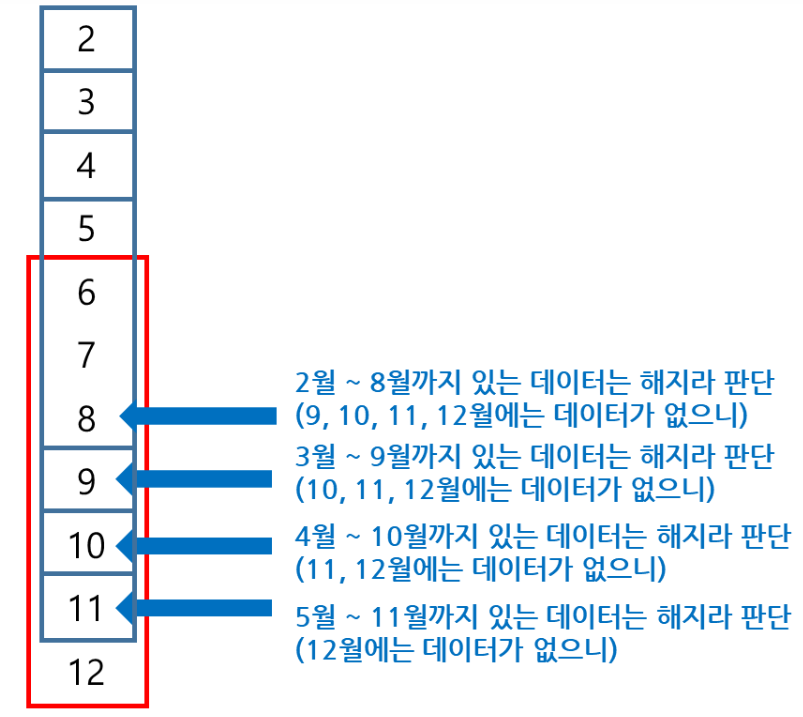

#### 8월 해지, 9월 해지, 10월 해지, 11월 해지 인 유저 찾은 뒤, churn 데이터에 Y 대입 <br>
7번 중복된 유저들
- 2월 ~ 8월 / 3월 ~ 9월 / 4월 ~ 10월 / 5월 ~ 11월 / 6월 ~ 12월

In [50]:
id_counts = df_not_11['sha2_hash'].value_counts()
id_counts

sha2_hash
205bb54ce6d411652a8b44045a9e96a0921a0e1c5f5a0901d015f773db5fe9be    10
a972ca59c333f7f0896b5397dac6fae24ef9b5929a2d1f089488e94a60049a71    10
f1f2ca7970c03e009781411f975edadc43d4e84e7aae7193c6f0940d998c764d    10
a7ff264e76606613281e8739b34cbe4665893d0f2880b778cd4a5aa86a0b2cb2    10
cdd5a8fc1c0060b43be9a897b05157964d9f0f4bb5da09927e2a0644d4b824fc    10
                                                                    ..
5a65f8dbfdeae43637e42ef6068a927b5e633cf8ee140e6c8bebcadaf77a842f     1
e0a263fbb9f1fce0304d4d866bd9854c9b5b83befcbf54bea8b65a0ad783280a     1
9822ec0f57f18a0c386fa66be45db1ec475aa78eabd32b63236d93151fe9e6bb     1
877a21e4ce357448793b9b7b89bcc030ec180c2ad0a7d9751317da78a07a6b83     1
90e29d444a5d4b9870453e36173948fcb32f022e36dbf526b4f90f2e4d28d0a8     1
Name: count, Length: 262709, dtype: int64

In [51]:
id_07 = id_counts[id_counts == 7].index
id_07

Index(['c2ced6f066cf546139f2f1bdfec2d46c15e306d1862f20796077a6a691b03ded',
       '396621c4f9235f0b35a807e2a241a5571ff6d2d8de6d5e0dc9f9227370030827',
       '5e20cfaa8db948c5b755b8e2f36dd74441ca7262d2f9cddb1eafffe8d3c71138',
       '52f606d1af7b169d98cd754c482dc49f1c58726c0a4c070a052ceafb2c38d4ed',
       '896fc52d6c6aaadaaafe8d52817415612c9638ab94a1fbb4c2bcef81b5906dc9',
       '50947730340f75fc4e427bf580e0b21d4e1543b1b435243078b288096c0d5566',
       'f9d6fc1d873fa230ab1768b8140f2fba48f627e9f7aa545c9028c5531022d992',
       'd904a0d1e17e47742359826ed14eeb27f98814fc974eacaf72053d6aa792399a',
       '8762aa6f0c70598f39a92cbd56c1ced3ad44da5edd81ae2180c272849751a48d',
       '474b5adca30be09cbd2faf13eb85c52b6394041ba4e1c47cf6851706f144da17',
       ...
       '123ade6f2707f70ab75e4a7a89b4c27a87e9b10594d9273e7e26517bfec6e917',
       '690a6e817cdbe700fd38ef43b06322e3ccc60b8979db7f695867107ebfc446d5',
       '4a2fb2ba16db1cd7e29f87da277a6169ea9402a6aa5454cd22141a20e471387b',
       'ba79a9

In [52]:
df_07_counts = df_not_11[df_not_11['sha2_hash'].isin(id_07)].sort_values(by = ['sha2_hash','p_mt'], ascending=[True, True])
df_07_counts

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
344664,0001f92fdce062b1f997938e0efd3c2fcb760b1d7457aac1d23e8ed4e1e25f54,24개월~ 36개월미만,HD,이코노미,N,Y,신규,N,0건,0건,현장경로,50.0,약정만료전 1개월,20230301,1093,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,40대,전체거부,전체거부,7.63,2.40,2.40,YTN,0.00,N,N,202302,NaN
273343,0001f92fdce062b1f997938e0efd3c2fcb760b1d7457aac1d23e8ed4e1e25f54,36개월 이상,HD,이코노미,N,Y,신규,N,0건,0건,현장경로,40.0,약정만료 1개월,20230301,1124,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,30대,전체거부,전체거부,9.32,1.46,1.46,연합뉴스TV,0.00,N,N,202303,NaN
94915,0001f92fdce062b1f997938e0efd3c2fcb760b1d7457aac1d23e8ed4e1e25f54,36개월 이상,HD,이코노미,N,Y,신규,N,0건,0건,현장경로,40.0,약정만료후 1개월~2개월,20230301,1154,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,30대,전체거부,전체거부,9.85,2.39,2.39,기타,0.00,N,N,202304,NaN
424796,0001f92fdce062b1f997938e0efd3c2fcb760b1d7457aac1d23e8ed4e1e25f54,36개월 이상,HD,이코노미,N,Y,신규,N,0건,0건,현장경로,50.0,약정만료후 3~6개월,20230301,1185,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,30대,전체거부,전체거부,8.27,1.35,1.35,KBS2,0.00,N,N,202305,NaN
599233,0001f92fdce062b1f997938e0efd3c2fcb760b1d7457aac1d23e8ed4e1e25f54,36개월 이상,HD,이코노미,N,Y,신규,N,0건,0건,현장경로,50.0,약정만료후 3~6개월,20230301,1215,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,30대,전체거부,전체거부,7.51,2.61,2.61,MBC,0.00,N,N,202306,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114052,ffff99d6fb91db75a5c5c18e4df7b6493049b4b84669bd944e0b1593930b1ed6,6개월미만,HD,이코노미,N,Y,신규,N,0건,0건,현장경로,40.0,약정만료전 12개월이상,20260622,3415,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,40대,전체거부,수신,12.54,2.18,2.18,기타,0.00,N,N,202308,NaN
849352,ffff99d6fb91db75a5c5c18e4df7b6493049b4b84669bd944e0b1593930b1ed6,6개월미만,HD,이코노미,N,Y,신규,N,0건,0건,현장경로,50.0,약정만료전 12개월이상,20260622,3445,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,40대,전체거부,수신,9.48,1.51,1.51,연합뉴스TV,0.00,N,N,202309,NaN
1001014,ffff99d6fb91db75a5c5c18e4df7b6493049b4b84669bd944e0b1593930b1ed6,6개월미만,HD,이코노미,N,Y,신규,N,0건,0건,현장경로,40.0,약정만료전 12개월이상,20260622,3476,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,40대,전체거부,수신,7.99,0.31,0.31,기타,0.00,N,N,202310,NaN
1394797,ffff99d6fb91db75a5c5c18e4df7b6493049b4b84669bd944e0b1593930b1ed6,6개월미만,HD,이코노미,N,Y,신규,N,0건,0건,현장경로,30.0,약정만료전 12개월이상,20260622,3506,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,40대,전체거부,수신,4.47,0.27,0.27,기타,0.00,N,N,202311,NaN


In [53]:
df_highest_month = df_07_counts.loc[df_07_counts.groupby('sha2_hash')['p_mt'].idxmax()]
df_highest_month

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
815005,0001f92fdce062b1f997938e0efd3c2fcb760b1d7457aac1d23e8ed4e1e25f54,36개월 이상,HD,이코노미,N,Y,신규,N,0건,0건,현장경로,30.0,약정만료후 6~9개월,20230301,1277,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,3주일전,Y,Y,30대,전체거부,전체거부,5.62,3.35,3.35,기타,0.00,N,N,202308,NaN
1265373,0003b7afdc30ebda72b16f5e6917bf3bd10282f58470bb05055ae8ba9c0009ff,6개월~12개월미만,UHD,베이직,N,N,신규,N,0건,0건,I/B,0.0,약정만료전 12개월이상,20260616,1208,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,2주일전,Y,Y,50대,수신,수신,0.40,0.00,0.00,기타,0.00,N,N,202312,NaN
1114769,0004bdbe6ba36eed76b61c0642f51e7b68032225b4a14e7bb130411500f80e29,36개월 이상,UHD,프리미엄,N,N,재약정,N,0건,0건,O/B,20.0,약정만료전 12개월이상,20240914,3873,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,N,60대,수신,수신,3.32,0.72,0.72,KBS1,2.00,N,N,202308,NaN
1261135,0008b9e75410b8bff3c76733eb34fdfc60fd59acfe7bb164505f7f06f5778a8f,36개월 이상,HD,프리미엄,N,N,재약정,N,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260514,3044,16.00,0.00,16.00,3.00,0.00,Y,N,N,19.00,일주일내,N,N,60대,전체거부,전체거부,0.33,0.00,0.00,기타,0.00,N,N,202312,NaN
1361629,000bd7a30533a8bc15c1ded61dff3bdef4e7a623a6c23b42aaee2245c0efda50,6개월~12개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,30.0,약정만료전 12개월이상,20260629,184,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,40대,전체거부,전체거부,7.62,2.66,2.66,tvN,0.00,N,Y,202312,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264379,fff0ccd098f0c2fd112a92d797633bbd4c3f0eecc57174cb5217cd55a3e3fb08,6개월~12개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,40.0,약정만료전 12개월이상,20260623,190,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,40대,전체거부,전체거부,8.32,2.15,2.15,기타,1.00,Y,Y,202312,NaN
956765,fff98ac395a2ce7a868354755fcf518fb7cce7866a702f1dc4bc98f1152da2e0,36개월 이상,UHD,프리미엄,N,N,약정승계,N,0건,0건,O/B,20.0,약정만료후 2개월~3개월,20230611,1175,2.00,0.00,2.00,2.00,1.00,Y,Y,N,4.00,일주일내,Y,N,40대,수신,수신,5.43,9.44,9.44,KBS1,0.00,N,Y,202308,NaN
1097229,fff9b2672b45cdb50b2168cc90a5c3630f6e8aa569efb5193a4e2b7ff2ae7502,12개월~24개월미만,UHD,프리미엄,N,N,신규,N,0건,0건,현장경로,0.0,약정만료전 12개월이상,20250602,454,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일전,Y,Y,60대,전체거부,전체거부,0.77,5.78,5.78,기타,0.00,Y,N,202308,NaN
1113024,fff9e7d357252187c74890d9721089e5158ed544ad6b2e84ecbcc77ebf6c777f,24개월~ 36개월미만,HD,베이직,N,N,약정승계,N,0건,0건,I/B,10.0,약정만료전 2~3개월,20231104,1828,2.00,0.00,2.00,2.00,0.00,Y,N,N,4.00,2주일전,Y,Y,40대,수신,수신,2.20,0.04,0.04,기타,0.00,N,N,202308,NaN


In [54]:
df_highest_month[~df_highest_month['p_mt'].isin([202308, 202309, 202310, 202311, 202312])]

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn


In [55]:
terminated_accounts = df_highest_month[df_highest_month['p_mt'].isin([202308, 202309, 202310, 202311])]
terminated_accounts

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
815005,0001f92fdce062b1f997938e0efd3c2fcb760b1d7457aac1d23e8ed4e1e25f54,36개월 이상,HD,이코노미,N,Y,신규,N,0건,0건,현장경로,30.0,약정만료후 6~9개월,20230301,1277,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,3주일전,Y,Y,30대,전체거부,전체거부,5.62,3.35,3.35,기타,0.00,N,N,202308,NaN
1114769,0004bdbe6ba36eed76b61c0642f51e7b68032225b4a14e7bb130411500f80e29,36개월 이상,UHD,프리미엄,N,N,재약정,N,0건,0건,O/B,20.0,약정만료전 12개월이상,20240914,3873,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,N,60대,수신,수신,3.32,0.72,0.72,KBS1,2.00,N,N,202308,NaN
1112417,000cb536c56800a98158dd4f89500d11a7eb018ba511dc688e3617eb1c900f7c,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료후 1개월~2개월,20230715,1141,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,N,N,50대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202308,NaN
955874,00155e9c4cc9a076420b37de23666bf24b746c74c94d7473aaaf9818bb4ba40d,36개월 이상,HD,베이직,N,N,약정승계,N,0건,1건,I/B,20.0,약정만료후 12개월이상,20180520,2592,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,50대,수신,수신,2.03,9.47,9.47,MBC,0.00,N,N,202308,NaN
996025,0017a960944f3c67c69c608a7e9e264f0e0cd1105bccb1489154a6797677791e,36개월 이상,HD,이코노미,N,Y,신규,Y,0건,0건,I/B,알수없음,약정만료후 3~6개월,20230528,2922,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202308,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954110,ffee2532ec5b725a109433cb98fc5e58cd1feb2a84a87f80c76afdfc9e3125d9,24개월~ 36개월미만,UHD,베이직,N,N,신규,Y,0건,0건,I/B,0.0,약정만료전 1개월,20230903,1091,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,2주일전,N,N,60대,수신,수신,0.03,3.30,3.30,기타,0.00,N,N,202308,NaN
1178465,ffee9255143449151e61018e956d9c0d76ddd0fd6266d82917c8f2ab8dcae282,36개월 이상,HD,베이직,N,N,신규,N,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200808,2213,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,70대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202308,NaN
956765,fff98ac395a2ce7a868354755fcf518fb7cce7866a702f1dc4bc98f1152da2e0,36개월 이상,UHD,프리미엄,N,N,약정승계,N,0건,0건,O/B,20.0,약정만료후 2개월~3개월,20230611,1175,2.00,0.00,2.00,2.00,1.00,Y,Y,N,4.00,일주일내,Y,N,40대,수신,수신,5.43,9.44,9.44,KBS1,0.00,N,Y,202308,NaN
1097229,fff9b2672b45cdb50b2168cc90a5c3630f6e8aa569efb5193a4e2b7ff2ae7502,12개월~24개월미만,UHD,프리미엄,N,N,신규,N,0건,0건,현장경로,0.0,약정만료전 12개월이상,20250602,454,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일전,Y,Y,60대,전체거부,전체거부,0.77,5.78,5.78,기타,0.00,Y,N,202308,NaN


In [56]:
terminated_accounts[terminated_accounts['p_mt'] == 202308]

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
815005,0001f92fdce062b1f997938e0efd3c2fcb760b1d7457aac1d23e8ed4e1e25f54,36개월 이상,HD,이코노미,N,Y,신규,N,0건,0건,현장경로,30.0,약정만료후 6~9개월,20230301,1277,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,3주일전,Y,Y,30대,전체거부,전체거부,5.62,3.35,3.35,기타,0.00,N,N,202308,NaN
1114769,0004bdbe6ba36eed76b61c0642f51e7b68032225b4a14e7bb130411500f80e29,36개월 이상,UHD,프리미엄,N,N,재약정,N,0건,0건,O/B,20.0,약정만료전 12개월이상,20240914,3873,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,N,60대,수신,수신,3.32,0.72,0.72,KBS1,2.00,N,N,202308,NaN
1112417,000cb536c56800a98158dd4f89500d11a7eb018ba511dc688e3617eb1c900f7c,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료후 1개월~2개월,20230715,1141,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,N,N,50대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202308,NaN
955874,00155e9c4cc9a076420b37de23666bf24b746c74c94d7473aaaf9818bb4ba40d,36개월 이상,HD,베이직,N,N,약정승계,N,0건,1건,I/B,20.0,약정만료후 12개월이상,20180520,2592,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,50대,수신,수신,2.03,9.47,9.47,MBC,0.00,N,N,202308,NaN
996025,0017a960944f3c67c69c608a7e9e264f0e0cd1105bccb1489154a6797677791e,36개월 이상,HD,이코노미,N,Y,신규,Y,0건,0건,I/B,알수없음,약정만료후 3~6개월,20230528,2922,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202308,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954110,ffee2532ec5b725a109433cb98fc5e58cd1feb2a84a87f80c76afdfc9e3125d9,24개월~ 36개월미만,UHD,베이직,N,N,신규,Y,0건,0건,I/B,0.0,약정만료전 1개월,20230903,1091,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,2주일전,N,N,60대,수신,수신,0.03,3.30,3.30,기타,0.00,N,N,202308,NaN
1178465,ffee9255143449151e61018e956d9c0d76ddd0fd6266d82917c8f2ab8dcae282,36개월 이상,HD,베이직,N,N,신규,N,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200808,2213,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,70대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202308,NaN
956765,fff98ac395a2ce7a868354755fcf518fb7cce7866a702f1dc4bc98f1152da2e0,36개월 이상,UHD,프리미엄,N,N,약정승계,N,0건,0건,O/B,20.0,약정만료후 2개월~3개월,20230611,1175,2.00,0.00,2.00,2.00,1.00,Y,Y,N,4.00,일주일내,Y,N,40대,수신,수신,5.43,9.44,9.44,KBS1,0.00,N,Y,202308,NaN
1097229,fff9b2672b45cdb50b2168cc90a5c3630f6e8aa569efb5193a4e2b7ff2ae7502,12개월~24개월미만,UHD,프리미엄,N,N,신규,N,0건,0건,현장경로,0.0,약정만료전 12개월이상,20250602,454,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일전,Y,Y,60대,전체거부,전체거부,0.77,5.78,5.78,기타,0.00,Y,N,202308,NaN


In [58]:
df[(df['sha2_hash'] == '0017a960944f3c67c69c608a7e9e264f0e0cd1105bccb1489154a6797677791e')].sort_values(by=['p_mt'])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
2139619,0017a960944f3c67c69c608a7e9e264f0e0cd1105bccb1489154a6797677791e,24개월~ 36개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,0.0,약정만료전 2~3개월,20230528,2738,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202302,None
526838,0017a960944f3c67c69c608a7e9e264f0e0cd1105bccb1489154a6797677791e,24개월~ 36개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,알수없음,약정만료전 1~2개월,20230528,2769,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,3개월내없음,Y,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202303,None
2611850,0017a960944f3c67c69c608a7e9e264f0e0cd1105bccb1489154a6797677791e,24개월~ 36개월미만,HD,이코노미,N,Y,신규,Y,0건,0건,I/B,알수없음,약정만료전 1개월,20230528,2799,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,3개월내없음,N,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202304,None
11191965,0017a960944f3c67c69c608a7e9e264f0e0cd1105bccb1489154a6797677791e,36개월 이상,HD,이코노미,N,Y,신규,Y,0건,0건,I/B,알수없음,약정만료 1개월,20230528,2830,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202305,None
9166158,0017a960944f3c67c69c608a7e9e264f0e0cd1105bccb1489154a6797677791e,36개월 이상,HD,이코노미,N,Y,신규,Y,0건,0건,I/B,알수없음,약정만료후 1개월~2개월,20230528,2860,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202306,None
12211290,0017a960944f3c67c69c608a7e9e264f0e0cd1105bccb1489154a6797677791e,36개월 이상,HD,이코노미,N,Y,신규,Y,0건,0건,I/B,알수없음,약정만료후 2개월~3개월,20230528,2891,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202307,None
15384221,0017a960944f3c67c69c608a7e9e264f0e0cd1105bccb1489154a6797677791e,36개월 이상,HD,이코노미,N,Y,신규,Y,0건,0건,I/B,알수없음,약정만료후 3~6개월,20230528,2922,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202308,None


In [59]:
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202311),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202310),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202309),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202308),'churn'] = 'Y'

In [60]:
df[df['churn'] == 'Y']

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
12283787,152708922d441b14a4b8bc12d073b0a537a43c7825d323d1ad2c6b2b282d191f,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,I/B,40.0,약정만료전 12개월이상,20241221,3293,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,Y,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202308,Y
12284432,81d04889baab6063a9527e14545d957fc35f6e9616cb2913fa3dd53819e408fb,36개월 이상,HD,베이직,N,N,재약정,Y,0건,0건,I/B,알수없음,약정만료전 12개월이상,20260111,4124,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,80대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202308,Y
12284489,2b3776b3759bb6f804a9c3e0dee7bc3ba4cfb4de0ff59ba67ac7e26e35b615d2,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,I/B,알수없음,약정만료후 12개월이상,20220805,3964,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,80대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202308,Y
12284728,d6d6b9c43aa30322fcf01f583acac1a1b62910c7836477baa1b543dc25b79c73,12개월~24개월미만,UHD,프리미엄,N,N,신규,N,0건,0건,현장경로,50.0,약정만료전 12개월이상,20240909,4244,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,8.47,4.40,4.40,기타,1.00,Y,Y,202308,Y
12284759,71c984692d867c41f24891ac87205f829cc12bfeecc60edb0771ffc0ea5a1acb,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,일반상담,40.0,약정만료전 9~12개월,20240805,3872,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,40대,수신,수신,6.63,1.91,1.91,기타,0.00,N,N,202308,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22474326,eff881138e842d13cb1e8fc2b35882e086fa7220a646334fd4a5929a85f37ac0,36개월 이상,HD,베이직,N,Y,신규,N,1건,0건,일반상담,10.0,약정만료후 12개월이상,20191005,2611,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일전,Y,N,50대,수신,수신,2.34,8.44,8.44,기타,0.00,N,N,202311,Y
22474652,f660b2ca3af8daf1f8adc1f9de6be5f3992ccdd1703e1f6ab338a88d299d3411,24개월~ 36개월미만,HD,베이직,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20141114,4398,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22474692,b25b6eaac676cc81966066e6f7f34f3e4492c1da49c62604c05f90fccf151a6d,36개월 이상,HD,이코노미,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20211205,3082,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,Y,80대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22475520,f43f2916dce3d59a455d3c3598021a93144e8a3a556aa2ec3837cc8f4b45963c,36개월 이상,HD,스탠다드,N,N,약정승계,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20160616,5211,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,30대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y


In [61]:
df[df['sha2_hash'] == 'd6d6b9c43aa30322fcf01f583acac1a1b62910c7836477baa1b543dc25b79c73'].sort_values(by=['p_mt'])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
261973,d6d6b9c43aa30322fcf01f583acac1a1b62910c7836477baa1b543dc25b79c73,12개월~24개월미만,UHD,프리미엄,N,N,신규,N,0건,0건,현장경로,50.0,약정만료전 12개월이상,20240909,4060,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,10.76,2.91,2.91,기타,1.00,Y,N,202302,None
4493020,d6d6b9c43aa30322fcf01f583acac1a1b62910c7836477baa1b543dc25b79c73,12개월~24개월미만,UHD,프리미엄,N,N,신규,N,0건,0건,현장경로,40.0,약정만료전 12개월이상,20240909,4091,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,8.56,5.01,5.01,기타,0.00,Y,N,202303,None
1485322,d6d6b9c43aa30322fcf01f583acac1a1b62910c7836477baa1b543dc25b79c73,12개월~24개월미만,UHD,프리미엄,N,N,신규,N,0건,0건,현장경로,40.0,약정만료전 12개월이상,20240909,4121,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,7.97,2.40,2.40,기타,0.00,Y,N,202304,None
11157701,d6d6b9c43aa30322fcf01f583acac1a1b62910c7836477baa1b543dc25b79c73,12개월~24개월미만,UHD,프리미엄,N,N,신규,N,0건,1건,현장경로,40.0,약정만료전 12개월이상,20240909,4152,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,50대,수신,수신,7.95,2.51,2.51,기타,1.00,Y,Y,202305,None
10013852,d6d6b9c43aa30322fcf01f583acac1a1b62910c7836477baa1b543dc25b79c73,12개월~24개월미만,UHD,프리미엄,N,N,신규,N,0건,0건,현장경로,40.0,약정만료전 12개월이상,20240909,4182,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,Y,50대,수신,수신,8.64,1.78,1.78,기타,0.00,Y,Y,202306,None
12023837,d6d6b9c43aa30322fcf01f583acac1a1b62910c7836477baa1b543dc25b79c73,12개월~24개월미만,UHD,프리미엄,N,N,신규,N,0건,0건,현장경로,50.0,약정만료전 12개월이상,20240909,4213,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,9.64,1.90,1.90,기타,0.00,Y,N,202307,None
12284728,d6d6b9c43aa30322fcf01f583acac1a1b62910c7836477baa1b543dc25b79c73,12개월~24개월미만,UHD,프리미엄,N,N,신규,N,0건,0건,현장경로,50.0,약정만료전 12개월이상,20240909,4244,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,8.47,4.40,4.40,기타,1.00,Y,Y,202308,Y


---

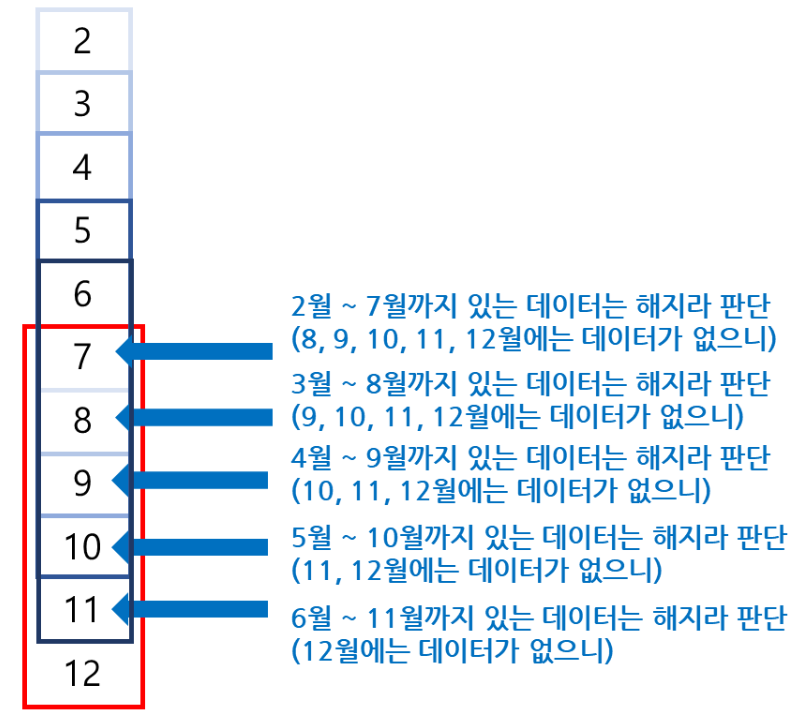

#### 7월 해지, 8월 해지, 9월 해지, 10월 해지, 11월 해지 인 유저 찾은 뒤, churn 데이터에 Y 대입 <br>
6번 중복된 유저들
- 2월 ~ 7월 / 3월 ~ 8월 / 4월 ~ 9월 / 5월 ~ 10월 / 6월 ~ 11월 / 7월 ~ 12월

In [62]:
id_counts = df_not_11['sha2_hash'].value_counts()
id_counts

sha2_hash
205bb54ce6d411652a8b44045a9e96a0921a0e1c5f5a0901d015f773db5fe9be    10
a972ca59c333f7f0896b5397dac6fae24ef9b5929a2d1f089488e94a60049a71    10
f1f2ca7970c03e009781411f975edadc43d4e84e7aae7193c6f0940d998c764d    10
a7ff264e76606613281e8739b34cbe4665893d0f2880b778cd4a5aa86a0b2cb2    10
cdd5a8fc1c0060b43be9a897b05157964d9f0f4bb5da09927e2a0644d4b824fc    10
                                                                    ..
5a65f8dbfdeae43637e42ef6068a927b5e633cf8ee140e6c8bebcadaf77a842f     1
e0a263fbb9f1fce0304d4d866bd9854c9b5b83befcbf54bea8b65a0ad783280a     1
9822ec0f57f18a0c386fa66be45db1ec475aa78eabd32b63236d93151fe9e6bb     1
877a21e4ce357448793b9b7b89bcc030ec180c2ad0a7d9751317da78a07a6b83     1
90e29d444a5d4b9870453e36173948fcb32f022e36dbf526b4f90f2e4d28d0a8     1
Name: count, Length: 262709, dtype: int64

In [63]:
id_06 = id_counts[id_counts == 6].index
id_06

Index(['792251fbdc36feedf71f27854ef1a1fd9c66d4919783cf28b950738521106e8f',
       '93e8ccc640a64c75922baad74baefc8680235742d80d1a320ee4d3f9f1d9f002',
       'f65d7cb3f23e1eb866bc945758197914aac56f6f9348d60e93846f4dc3388099',
       'a03cffabfdede0264222d41b8969c170ee21404c4449ab7bc019cf970505029c',
       '22ba347f8847f9c5bb65eaf99cf8c40ee44183883947dd213b29e8e40f12814e',
       '882c55aaba0db19ee783fe2434fa29c6ad411f348eed416065807af7b48f21a7',
       '0c401612938e954b00fdfb90f517b2265d7e0380e8199a3aad07045e503eb540',
       '0f22e79fbe3685020928ceadba6619f952bda287c5ae7f8102801c7d962c423c',
       '35b94aff15e9c5fcd64d6857f3f93aa89b437d8a4d7bab9d944b9f9517237555',
       'f2a1e96b003bdfef4685f3e6b4ba31fc5785f4c98e16fb87273d301c813ef32c',
       ...
       '6805292c8dd63f1e7bfcde17d2fbc6fb3f0ac63e03274393aba551a68abc4116',
       '06be357f86bc0de7ee4657adf40e6aa5acac2b4f7b6d216ad87a787c45040019',
       '12a818f8fd436a13521e71a48a84a1c3202c4f6db76fb505ef36851020a28f96',
       '8e8666

In [64]:
df_06_counts = df_not_11[df_not_11['sha2_hash'].isin(id_06)].sort_values(by = ['sha2_hash','p_mt'], ascending=[True, True])
df_06_counts

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
142379,00043eef94e14163de52a1da78d25a33136cd2be189b8a1d595b9c98f548bee1,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,O/B,30.0,약정만료후 12개월이상,20150531,3924,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,Y,N,70대,수신,수신,6.29,0.01,0.01,KBS1,0.00,N,N,202302,NaN
388989,00043eef94e14163de52a1da78d25a33136cd2be189b8a1d595b9c98f548bee1,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,O/B,30.0,약정만료후 12개월이상,20150531,3955,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,70대,수신,수신,4.81,1.33,1.33,KBS2,0.00,N,N,202303,NaN
160834,00043eef94e14163de52a1da78d25a33136cd2be189b8a1d595b9c98f548bee1,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,O/B,20.0,약정만료후 12개월이상,20150531,3985,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,70대,수신,수신,4.88,0.02,0.02,KBS2,0.00,N,N,202304,NaN
437499,00043eef94e14163de52a1da78d25a33136cd2be189b8a1d595b9c98f548bee1,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,O/B,20.0,약정만료후 12개월이상,20150531,4016,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,70대,수신,수신,3.78,0.00,0.00,기타,0.00,N,N,202305,NaN
571527,00043eef94e14163de52a1da78d25a33136cd2be189b8a1d595b9c98f548bee1,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,O/B,20.0,약정만료후 12개월이상,20150531,4046,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,70대,수신,수신,2.96,0.00,0.00,KBS1,0.00,N,N,202306,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285785,fffabb732cd2b8f1562f0d8b72372da526c516445255e6d39bf5c6ecea93649f,6개월~12개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,40.0,약정만료전 12개월이상,20250628,275,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,50대,전체거부,전체거부,6.87,0.10,0.10,기타,0.00,N,N,202303,NaN
74912,fffabb732cd2b8f1562f0d8b72372da526c516445255e6d39bf5c6ecea93649f,6개월~12개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,30.0,약정만료전 12개월이상,20250628,305,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,50대,전체거부,전체거부,6.23,0.64,0.64,기타,0.00,N,N,202304,NaN
509250,fffabb732cd2b8f1562f0d8b72372da526c516445255e6d39bf5c6ecea93649f,6개월~12개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,30.0,약정만료전 12개월이상,20250628,336,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,50대,전체거부,전체거부,7.74,1.41,1.41,SBS,0.00,N,N,202305,NaN
672255,fffabb732cd2b8f1562f0d8b72372da526c516445255e6d39bf5c6ecea93649f,12개월~24개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,30.0,약정만료전 12개월이상,20250628,366,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,50대,전체거부,전체거부,7.15,0.89,0.89,tvN,0.00,N,N,202306,NaN


In [65]:
df_highest_month = df_06_counts.loc[df_06_counts.groupby('sha2_hash')['p_mt'].idxmax()]
df_highest_month

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
646527,00043eef94e14163de52a1da78d25a33136cd2be189b8a1d595b9c98f548bee1,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,O/B,10.0,약정만료후 12개월이상,20150531,4077,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,70대,수신,수신,2.46,2.73,2.73,기타,0.00,N,N,202307,NaN
1245675,0005a3d3d86ad715954291739678ce2e40389f7923f61b8c0b21c8f51fdd59d0,6개월미만,UHD,이코노미,N,N,신규,N,0건,0건,I/B,60.0,약정만료전 12개월이상,20260712,171,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,70대,전체거부,전체거부,14.64,2.40,2.40,연합뉴스TV,3.00,N,N,202312,NaN
548338,000af1ab757bf0657e0d31c672c4cf142146726969a6bbe37c006d05c47e8c75,36개월 이상,HD,프리미엄,N,N,약정승계,N,0건,0건,O/B,20.0,약정만료후 12개월이상,20190310,2466,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,70대,수신,수신,4.75,7.94,7.94,기타,0.00,N,N,202307,NaN
1387086,000e622693afac526fada154c90075f2d017f63eaa8d8fac3e2e9a50c5556064,36개월 이상,HD,베이직,N,N,약정승계,N,0건,0건,I/B,60.0,약정만료후 12개월이상,20170623,3477,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,80대,전체거부,수신,13.14,4.66,4.66,EBS,0.00,N,N,202312,NaN
1240799,0012c4d3b94f4f508fefc6285d48f9a6603dcdfa4f2272db58d0b5f843d52fb4,6개월미만,UHD,이코노미,N,N,신규,N,0건,0건,일반상담,0.0,약정만료전 12개월이상,20260707,1534,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,4주일전,N,N,50대,수신,수신,3.18,0.00,0.00,기타,0.00,N,Y,202312,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635846,ffe821b8f0182f19a005a2efaa00db202d3f6352f5fe6456593fa2a48a01f0f4,12개월~24개월미만,HD,이코노미,N,N,신규,N,0건,0건,직영몰,알수없음,약정만료전 12개월이상,20250222,523,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,N,N,30대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202307,NaN
635430,ffef725254e11b234b430ef3c84002e360b2970adacdaa8f849d3ef8aa858afa,12개월~24개월미만,HD,이코노미,N,N,신규,N,0건,0건,I/B,10.0,약정만료전 12개월이상,20250328,2826,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,90대이상,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202307,NaN
532896,ffef849148722572c488189dbc17f2daa0f1082fcd0bbf8b9dbab4473b13b2fe,24개월~ 36개월미만,UHD,베이직,N,Y,신규,Y,0건,0건,현장경로,알수없음,약정만료전 6~9개월,20240425,826,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,3개월내없음,N,N,30대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202307,NaN
1246880,fff4a16072323b2550f0b167f628a60e330ead7f3bd1f8d846572bc6a7684118,6개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,I/B,70.0,약정만료전 12개월이상,20260720,163,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,70대,전체거부,전체거부,15.47,1.07,1.07,기타,0.00,Y,N,202312,NaN


In [66]:
df_highest_month[~df_highest_month['p_mt'].isin([202307, 202308, 202309, 202310, 202311, 202312])]

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn


In [67]:
terminated_accounts = df_highest_month[df_highest_month['p_mt'].isin([202307, 202308, 202309, 202310, 202311])]
terminated_accounts

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
646527,00043eef94e14163de52a1da78d25a33136cd2be189b8a1d595b9c98f548bee1,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,O/B,10.0,약정만료후 12개월이상,20150531,4077,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,70대,수신,수신,2.46,2.73,2.73,기타,0.00,N,N,202307,NaN
548338,000af1ab757bf0657e0d31c672c4cf142146726969a6bbe37c006d05c47e8c75,36개월 이상,HD,프리미엄,N,N,약정승계,N,0건,0건,O/B,20.0,약정만료후 12개월이상,20190310,2466,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,70대,수신,수신,4.75,7.94,7.94,기타,0.00,N,N,202307,NaN
748534,001dbbe8b83529d26a37a1824c9dbdb04d2dd73da7853094f5e3f8d1216ec815,36개월 이상,UHD,베이직,N,N,신규,Y,0건,0건,I/B,알수없음,약정만료후 12개월이상,20200820,2170,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,50대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202307,NaN
637737,00212d63b2b86bb6d9d33fe28ffcab4118bbb47ea26913e08ad1ad8666ec8620,24개월~ 36개월미만,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,20.0,약정만료전 1개월,20230810,1084,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,Y,Y,50대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202307,NaN
552567,00225a416f8dfb201588febf6de4f78acdc637abaad7d3ad7e86f720d93c4d72,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,직영몰,40.0,약정만료 1개월,20230728,1097,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,20대,수신,수신,10.63,3.86,3.86,KBS1,0.00,N,N,202307,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757788,ffe0c5eea9f2b5c79e88e5a5d849614c0f697651bc92d7678b7a2862797de0f1,12개월~24개월미만,HD,베이직,N,Y,약정승계,Y,0건,1건,일반상담,알수없음,약정만료전 12개월이상,20250311,753,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,3개월내없음,N,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202307,NaN
635846,ffe821b8f0182f19a005a2efaa00db202d3f6352f5fe6456593fa2a48a01f0f4,12개월~24개월미만,HD,이코노미,N,N,신규,N,0건,0건,직영몰,알수없음,약정만료전 12개월이상,20250222,523,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,N,N,30대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202307,NaN
635430,ffef725254e11b234b430ef3c84002e360b2970adacdaa8f849d3ef8aa858afa,12개월~24개월미만,HD,이코노미,N,N,신규,N,0건,0건,I/B,10.0,약정만료전 12개월이상,20250328,2826,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,90대이상,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202307,NaN
532896,ffef849148722572c488189dbc17f2daa0f1082fcd0bbf8b9dbab4473b13b2fe,24개월~ 36개월미만,UHD,베이직,N,Y,신규,Y,0건,0건,현장경로,알수없음,약정만료전 6~9개월,20240425,826,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,3개월내없음,N,N,30대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202307,NaN


In [68]:
terminated_accounts[terminated_accounts['p_mt'] == 202307]

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
646527,00043eef94e14163de52a1da78d25a33136cd2be189b8a1d595b9c98f548bee1,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,O/B,10.0,약정만료후 12개월이상,20150531,4077,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,70대,수신,수신,2.46,2.73,2.73,기타,0.00,N,N,202307,NaN
548338,000af1ab757bf0657e0d31c672c4cf142146726969a6bbe37c006d05c47e8c75,36개월 이상,HD,프리미엄,N,N,약정승계,N,0건,0건,O/B,20.0,약정만료후 12개월이상,20190310,2466,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,70대,수신,수신,4.75,7.94,7.94,기타,0.00,N,N,202307,NaN
748534,001dbbe8b83529d26a37a1824c9dbdb04d2dd73da7853094f5e3f8d1216ec815,36개월 이상,UHD,베이직,N,N,신규,Y,0건,0건,I/B,알수없음,약정만료후 12개월이상,20200820,2170,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,50대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202307,NaN
637737,00212d63b2b86bb6d9d33fe28ffcab4118bbb47ea26913e08ad1ad8666ec8620,24개월~ 36개월미만,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,20.0,약정만료전 1개월,20230810,1084,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,Y,Y,50대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202307,NaN
552567,00225a416f8dfb201588febf6de4f78acdc637abaad7d3ad7e86f720d93c4d72,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,직영몰,40.0,약정만료 1개월,20230728,1097,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,20대,수신,수신,10.63,3.86,3.86,KBS1,0.00,N,N,202307,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757788,ffe0c5eea9f2b5c79e88e5a5d849614c0f697651bc92d7678b7a2862797de0f1,12개월~24개월미만,HD,베이직,N,Y,약정승계,Y,0건,1건,일반상담,알수없음,약정만료전 12개월이상,20250311,753,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,3개월내없음,N,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202307,NaN
635846,ffe821b8f0182f19a005a2efaa00db202d3f6352f5fe6456593fa2a48a01f0f4,12개월~24개월미만,HD,이코노미,N,N,신규,N,0건,0건,직영몰,알수없음,약정만료전 12개월이상,20250222,523,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,N,N,30대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202307,NaN
635430,ffef725254e11b234b430ef3c84002e360b2970adacdaa8f849d3ef8aa858afa,12개월~24개월미만,HD,이코노미,N,N,신규,N,0건,0건,I/B,10.0,약정만료전 12개월이상,20250328,2826,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,90대이상,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202307,NaN
532896,ffef849148722572c488189dbc17f2daa0f1082fcd0bbf8b9dbab4473b13b2fe,24개월~ 36개월미만,UHD,베이직,N,Y,신규,Y,0건,0건,현장경로,알수없음,약정만료전 6~9개월,20240425,826,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,3개월내없음,N,N,30대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202307,NaN


In [70]:
df[(df['sha2_hash'] == '001dbbe8b83529d26a37a1824c9dbdb04d2dd73da7853094f5e3f8d1216ec815')].sort_values(by=['p_mt'])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
193352,001dbbe8b83529d26a37a1824c9dbdb04d2dd73da7853094f5e3f8d1216ec815,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,I/B,10.0,약정만료후 12개월이상,20200820,2017,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,50대,수신,수신,5.39,1.92,1.92,기타,0.00,N,N,202302,None
6132221,001dbbe8b83529d26a37a1824c9dbdb04d2dd73da7853094f5e3f8d1216ec815,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,I/B,0.0,약정만료후 12개월이상,20200820,2048,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,50대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202303,None
1323738,001dbbe8b83529d26a37a1824c9dbdb04d2dd73da7853094f5e3f8d1216ec815,36개월 이상,UHD,베이직,N,N,신규,Y,0건,0건,I/B,0.0,약정만료후 12개월이상,20200820,2078,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,50대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202304,None
6419021,001dbbe8b83529d26a37a1824c9dbdb04d2dd73da7853094f5e3f8d1216ec815,36개월 이상,UHD,베이직,N,N,신규,Y,0건,0건,I/B,알수없음,약정만료후 12개월이상,20200820,2109,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,50대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202305,None
7535221,001dbbe8b83529d26a37a1824c9dbdb04d2dd73da7853094f5e3f8d1216ec815,36개월 이상,UHD,베이직,N,N,신규,Y,0건,0건,I/B,알수없음,약정만료후 12개월이상,20200820,2139,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,50대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202306,None
11443067,001dbbe8b83529d26a37a1824c9dbdb04d2dd73da7853094f5e3f8d1216ec815,36개월 이상,UHD,베이직,N,N,신규,Y,0건,0건,I/B,알수없음,약정만료후 12개월이상,20200820,2170,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,50대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202307,None


In [71]:
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202311),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202310),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202309),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202308),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202307),'churn'] = 'Y'

In [72]:
df[df['churn'] == 'Y']

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
8071096,2fe3df005a24f0ff18067cf134aa0c76bc0f2f3919c080c08d53ba2487a25b0c,36개월 이상,UHD,프리미엄,N,N,약정승계,N,0건,0건,현장경로,10.0,약정만료후 9~12개월,20220825,3409,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,50대,수신,수신,2.78,6.64,6.64,기타,0.00,Y,Y,202307,Y
8071375,7cb16b3020d49843e63dc139d8df58e3d066d5df20fe29db3ff2e4ac9a8f8540,36개월 이상,HD,베이직,N,N,재약정,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20171024,4260,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,Y,Y,50대,미응답,미응답,0.00,0.00,0.00,기타,0.00,N,N,202307,Y
8071530,1f77d49e741cdb64dffece2d706f231279c7c3b7519c69cddd3d1d1e0c9d62ac,36개월 이상,HD,스탠다드,N,N,재약정,N,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20170512,3366,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,Y,90대이상,미응답,수신,0.00,0.00,0.00,기타,0.00,N,N,202307,Y
8071568,5cc6a71d6bb074051d3fb017cfe3fe922c15d68c63fd2f95823a7700a3a3dae6,12개월~24개월미만,HD,베이직,N,N,약정승계,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20240926,672,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,50대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202307,Y
8071673,040e27ea758534ae2fc414320a903cdf31fc4afcd40f1dfe2fde8815ab7a260c,36개월 이상,HD,이코노미,N,N,재약정,N,0건,0건,현장경로,20.0,약정만료전 12개월이상,20251018,3981,21.00,0.00,21.00,7.00,0.00,Y,N,N,28.00,일주일내,N,N,30대,수신,수신,4.92,0.20,0.20,기타,0.00,N,N,202307,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22474326,eff881138e842d13cb1e8fc2b35882e086fa7220a646334fd4a5929a85f37ac0,36개월 이상,HD,베이직,N,Y,신규,N,1건,0건,일반상담,10.0,약정만료후 12개월이상,20191005,2611,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일전,Y,N,50대,수신,수신,2.34,8.44,8.44,기타,0.00,N,N,202311,Y
22474652,f660b2ca3af8daf1f8adc1f9de6be5f3992ccdd1703e1f6ab338a88d299d3411,24개월~ 36개월미만,HD,베이직,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20141114,4398,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22474692,b25b6eaac676cc81966066e6f7f34f3e4492c1da49c62604c05f90fccf151a6d,36개월 이상,HD,이코노미,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20211205,3082,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,Y,80대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22475520,f43f2916dce3d59a455d3c3598021a93144e8a3a556aa2ec3837cc8f4b45963c,36개월 이상,HD,스탠다드,N,N,약정승계,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20160616,5211,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,30대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y


In [73]:
df[df['sha2_hash'] == '5cc6a71d6bb074051d3fb017cfe3fe922c15d68c63fd2f95823a7700a3a3dae6'].sort_values(by=['p_mt'])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
2321588,5cc6a71d6bb074051d3fb017cfe3fe922c15d68c63fd2f95823a7700a3a3dae6,12개월~24개월미만,HD,베이직,N,N,약정승계,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20240926,519,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,50대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202302,None
679054,5cc6a71d6bb074051d3fb017cfe3fe922c15d68c63fd2f95823a7700a3a3dae6,12개월~24개월미만,HD,베이직,N,N,약정승계,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20240926,550,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,N,50대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202303,None
3101238,5cc6a71d6bb074051d3fb017cfe3fe922c15d68c63fd2f95823a7700a3a3dae6,12개월~24개월미만,HD,베이직,N,N,약정승계,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20240926,580,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,50대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202304,None
6435422,5cc6a71d6bb074051d3fb017cfe3fe922c15d68c63fd2f95823a7700a3a3dae6,12개월~24개월미만,HD,베이직,N,N,약정승계,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20240926,611,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,N,50대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202305,None
10258828,5cc6a71d6bb074051d3fb017cfe3fe922c15d68c63fd2f95823a7700a3a3dae6,12개월~24개월미만,HD,베이직,N,N,약정승계,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20240926,641,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,50대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202306,None
8071568,5cc6a71d6bb074051d3fb017cfe3fe922c15d68c63fd2f95823a7700a3a3dae6,12개월~24개월미만,HD,베이직,N,N,약정승계,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20240926,672,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,50대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202307,Y


---

#### 6월 해지, 7월 해지, 8월 해지, 9월 해지, 10월 해지, 11월 해지 인 유저 찾은 뒤, churn 데이터에 Y 대입 <br>
5번 중복된 유저들
- 2월 ~ 6월 / 3월 ~ 7월 / 4월 ~ 8월 / 5월 ~ 9월 / 6월 ~ 10월 / 7월 ~ 11월 / 8월 ~ 12월


In [74]:
id_counts = df_not_11['sha2_hash'].value_counts()
id_counts

sha2_hash
205bb54ce6d411652a8b44045a9e96a0921a0e1c5f5a0901d015f773db5fe9be    10
a972ca59c333f7f0896b5397dac6fae24ef9b5929a2d1f089488e94a60049a71    10
f1f2ca7970c03e009781411f975edadc43d4e84e7aae7193c6f0940d998c764d    10
a7ff264e76606613281e8739b34cbe4665893d0f2880b778cd4a5aa86a0b2cb2    10
cdd5a8fc1c0060b43be9a897b05157964d9f0f4bb5da09927e2a0644d4b824fc    10
                                                                    ..
5a65f8dbfdeae43637e42ef6068a927b5e633cf8ee140e6c8bebcadaf77a842f     1
e0a263fbb9f1fce0304d4d866bd9854c9b5b83befcbf54bea8b65a0ad783280a     1
9822ec0f57f18a0c386fa66be45db1ec475aa78eabd32b63236d93151fe9e6bb     1
877a21e4ce357448793b9b7b89bcc030ec180c2ad0a7d9751317da78a07a6b83     1
90e29d444a5d4b9870453e36173948fcb32f022e36dbf526b4f90f2e4d28d0a8     1
Name: count, Length: 262709, dtype: int64

In [75]:
id_05 = id_counts[id_counts == 5].index
id_05

Index(['687e7c40307a17f2842ac19ff24e3b5a4abdd3a19ae0c53fca6506d96a707567',
       'db0bc074dc3491c2d61d41f7b112f333a3e41281d54747c770dc5f2b754c1553',
       '32b7990493d9fdb4f532f9902178ca17f4d0771be6dd9bab2e9c616ba71f3542',
       '0763c5d540c0b334f4891842fe322dc1bbf274aa28328147cbd9a432f8b7bc32',
       'adf105f7f722a593730165d2fb9091e72dcf9b712fb23da5c36ecb61b2c62bf2',
       'bbbd2db0dbc24847e1837d26657003db423e0924df019fda2b5e69dbbe316764',
       '26d64070e676f60f4037c2ef5981adbf2b804d99c50d4a9fa4cebbe90439209c',
       '0674f9d9ba203e4d52f4e28e14d609adf866082d167fee25e596d48b90220468',
       'f37d8d3d06fe9660d9c863ebf6efaf7f714a5c181f21612063333e9dc314f575',
       'b4226b797e81b4681483b7f17c75064540fd0444b66102b58063a71a9b0f26e5',
       ...
       '328182ab384ee2c9154e48995460e0632d9020e40a043234c2227eb42b02c11e',
       '69204f739af26f8425a619e0103a88413c90395dba33897a144a16c0efb2bccd',
       'daa7124108dbea49775570d92e4934c5a03825d4649e77345d930e88073de51b',
       '33cbce

In [76]:
df_05_counts = df_not_11[df_not_11['sha2_hash'].isin(id_05)].sort_values(by = ['sha2_hash','p_mt'], ascending=[True, True])
df_05_counts

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
1098097,0001cc7febb2769a3f1992528464e8e5d7926571c4deee459048424385ca9091,6개월미만,UHD,이코노미,N,Y,신규,Y,0건,0건,I/B,0.0,약정만료전 12개월이상,20260824,6,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,일주일내,Y,N,60대,전체거부,수신,0.07,0.00,0.00,기타,0.00,N,N,202308,NaN
840365,0001cc7febb2769a3f1992528464e8e5d7926571c4deee459048424385ca9091,6개월미만,UHD,이코노미,N,Y,신규,N,0건,0건,I/B,0.0,약정만료전 12개월이상,20260824,36,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,일주일내,Y,N,60대,전체거부,수신,1.81,0.05,0.05,MBN,0.00,Y,N,202309,NaN
964950,0001cc7febb2769a3f1992528464e8e5d7926571c4deee459048424385ca9091,6개월미만,UHD,이코노미,N,Y,신규,N,0건,0건,I/B,0.0,약정만료전 12개월이상,20260824,67,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,일주일내,Y,N,60대,전체거부,수신,1.63,0.02,0.02,기타,0.00,Y,Y,202310,NaN
1304892,0001cc7febb2769a3f1992528464e8e5d7926571c4deee459048424385ca9091,6개월미만,UHD,이코노미,N,Y,신규,N,1건,0건,I/B,10.0,약정만료전 12개월이상,20260824,97,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,일주일내,Y,Y,60대,전체거부,수신,1.82,0.85,0.85,TV조선,1.00,Y,Y,202311,NaN
1259638,0001cc7febb2769a3f1992528464e8e5d7926571c4deee459048424385ca9091,6개월미만,UHD,이코노미,N,Y,신규,N,1건,0건,I/B,10.0,약정만료전 12개월이상,20260824,128,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,일주일내,Y,N,60대,전체거부,수신,2.69,4.42,4.42,KBS2,0.00,Y,Y,202312,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977218,fffcd8dd499cd07a4ffc74055f0ace40ed273eb26a477aef26a61a19948131cb,6개월미만,UHD,베이직,N,N,신규,Y,0건,0건,O/B,0.0,약정만료전 12개월이상,20260825,5,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,Y,N,50대,전체거부,전체거부,5.16,5.18,5.18,KBS1,0.00,N,N,202308,NaN
1043026,fffcd8dd499cd07a4ffc74055f0ace40ed273eb26a477aef26a61a19948131cb,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,O/B,10.0,약정만료전 12개월이상,20260825,35,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,Y,N,50대,전체거부,전체거부,5.19,3.21,3.21,기타,2.00,N,N,202309,NaN
966881,fffcd8dd499cd07a4ffc74055f0ace40ed273eb26a477aef26a61a19948131cb,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,O/B,20.0,약정만료전 12개월이상,20260825,66,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,50대,전체거부,전체거부,6.66,0.82,0.82,기타,0.00,N,N,202310,NaN
1332019,fffcd8dd499cd07a4ffc74055f0ace40ed273eb26a477aef26a61a19948131cb,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,O/B,30.0,약정만료전 12개월이상,20260825,96,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,50대,전체거부,전체거부,6.10,2.99,2.99,MBC,2.00,N,N,202311,NaN


In [77]:
df_highest_month = df_05_counts.loc[df_05_counts.groupby('sha2_hash')['p_mt'].idxmax()]
df_highest_month

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
1259638,0001cc7febb2769a3f1992528464e8e5d7926571c4deee459048424385ca9091,6개월미만,UHD,이코노미,N,Y,신규,N,1건,0건,I/B,10.0,약정만료전 12개월이상,20260824,128,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,일주일내,Y,N,60대,전체거부,수신,2.69,4.42,4.42,KBS2,0.00,Y,Y,202312,NaN
1264451,0006366aa258fd3a462b29198dfddc0f98c1942591f4800ad45ab24e403eed34,6개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,직영몰,50.0,약정만료전 12개월이상,20260820,132,3.00,0.00,3.00,1.00,1.00,Y,Y,N,4.00,일주일내,N,N,40대,전체거부,전체거부,12.35,2.05,2.05,KBS1,2.00,N,Y,202312,NaN
598592,00068c3d48943aaea0361c2615b73ffac5a11b3535c5f1c4fc6befe438251c16,36개월 이상,HD,이코노미,N,N,신규,Y,0건,0건,I/B,알수없음,약정만료 1개월,20230625,1099,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,Y,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202306,NaN
1225945,0007f838acd0faec0184d832e20f2649eb2443bc797acae4379e68e636cf59c1,6개월미만,UHD,프리미엄,N,N,신규,N,0건,0건,현장경로,30.0,약정만료전 12개월이상,20260829,123,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,60대,전체거부,전체거부,7.70,0.65,0.65,KBS1,0.00,N,N,202312,NaN
1267675,0008f7a540c37dd502b93026f2cb5228d45a3aaffbde7e7110be9f1d51a9ccce,6개월미만,HD,베이직,N,Y,신규,N,0건,0건,I/B,20.0,약정만료전 12개월이상,20260820,3494,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,40대,수신,수신,2.38,4.81,4.81,기타,0.00,N,N,202312,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673530,ffe9e3aaded6b39975e9a4945bd14908e878e84c32a006440253b1bcd672472c,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,현장경로,20.0,약정만료 1개월,20230629,1095,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,40대,전체거부,전체거부,4.83,12.08,12.08,기타,2.00,Y,Y,202306,NaN
673512,ffee2bad00048acbbc2c995e856e451b7b4b0f2d54d9e64892301dedced3ea53,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,현장경로,0.0,약정만료후 3~6개월,20230116,1260,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,Y,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202306,NaN
668897,fff2652af82a8419aa79a452943c31c30b603b7a9d3ef5b88106a0e179a75ae3,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,O/B,30.0,약정만료전 6~9개월,20240218,1785,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,일주일내,N,N,70대,전체거부,전체거부,5.40,7.91,7.91,TV조선,0.00,N,N,202306,NaN
475534,fff428e6365ebe667290b3ed44a326f6586fc45c0feeffdf9ef68b409deb2a00,36개월 이상,HD,이코노미,N,Y,신규,Y,0건,0건,현장경로,0.0,약정만료 1개월,20230628,1096,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,80대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202306,NaN


In [78]:
df_highest_month[~df_highest_month['p_mt'].isin([202306, 202307, 202308, 202309, 202310, 202311, 202312])]

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn


In [79]:
terminated_accounts = df_highest_month[df_highest_month['p_mt'].isin([202306, 202307, 202308, 202309, 202310, 202311])]
terminated_accounts

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
598592,00068c3d48943aaea0361c2615b73ffac5a11b3535c5f1c4fc6befe438251c16,36개월 이상,HD,이코노미,N,N,신규,Y,0건,0건,I/B,알수없음,약정만료 1개월,20230625,1099,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,Y,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202306,NaN
450658,0009300e102b76a9900fff8c5e7c86fc01890e16d340791fe5952c81fa59caf1,6개월~12개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20250821,312,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,50대,수신,수신,0.97,0.21,0.21,기타,1.00,N,Y,202306,NaN
649449,000c4cfb077a2d56ed606b2b18a1eb43f22a5fcb1417c31fbe695b44625982d4,36개월 이상,UHD,프리미엄,N,N,약정승계,N,0건,0건,O/B,40.0,약정만료후 12개월이상,20150403,4104,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,70대,수신,수신,10.24,0.56,0.56,기타,0.00,Y,N,202306,NaN
605514,0010af1260a855c58dd671e8426631fa97c0c7874e474ca2dcc96d81a9c1cf64,36개월 이상,HD,베이직,N,Y,약정승계,N,0건,0건,O/B,10.0,약정만료후 12개월이상,20190621,3214,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,Y,Y,80대,수신,수신,1.73,0.00,0.00,기타,0.00,N,N,202306,NaN
661991,0011b28fe8a05bc8c11761478ce3643e0fb0e94b9516eca8c3e62020ae223ee3,6개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,O/B,10.0,약정만료전 12개월이상,20260110,3861,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,50대,수신,전체거부,1.14,0.06,0.06,기타,0.00,N,Y,202306,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443649,ffe8af8c4921ab31cd5031aefb14604117770e3b4773e998c1fe88b3a205e82d,36개월 이상,HD,프리미엄,N,N,재약정,N,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20180421,4221,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202306,NaN
673530,ffe9e3aaded6b39975e9a4945bd14908e878e84c32a006440253b1bcd672472c,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,현장경로,20.0,약정만료 1개월,20230629,1095,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,40대,전체거부,전체거부,4.83,12.08,12.08,기타,2.00,Y,Y,202306,NaN
673512,ffee2bad00048acbbc2c995e856e451b7b4b0f2d54d9e64892301dedced3ea53,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,현장경로,0.0,약정만료후 3~6개월,20230116,1260,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,Y,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202306,NaN
668897,fff2652af82a8419aa79a452943c31c30b603b7a9d3ef5b88106a0e179a75ae3,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,O/B,30.0,약정만료전 6~9개월,20240218,1785,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,일주일내,N,N,70대,전체거부,전체거부,5.40,7.91,7.91,TV조선,0.00,N,N,202306,NaN


In [80]:
terminated_accounts[terminated_accounts['p_mt'] == 202306]

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
598592,00068c3d48943aaea0361c2615b73ffac5a11b3535c5f1c4fc6befe438251c16,36개월 이상,HD,이코노미,N,N,신규,Y,0건,0건,I/B,알수없음,약정만료 1개월,20230625,1099,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,Y,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202306,NaN
450658,0009300e102b76a9900fff8c5e7c86fc01890e16d340791fe5952c81fa59caf1,6개월~12개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20250821,312,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,50대,수신,수신,0.97,0.21,0.21,기타,1.00,N,Y,202306,NaN
649449,000c4cfb077a2d56ed606b2b18a1eb43f22a5fcb1417c31fbe695b44625982d4,36개월 이상,UHD,프리미엄,N,N,약정승계,N,0건,0건,O/B,40.0,약정만료후 12개월이상,20150403,4104,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,70대,수신,수신,10.24,0.56,0.56,기타,0.00,Y,N,202306,NaN
605514,0010af1260a855c58dd671e8426631fa97c0c7874e474ca2dcc96d81a9c1cf64,36개월 이상,HD,베이직,N,Y,약정승계,N,0건,0건,O/B,10.0,약정만료후 12개월이상,20190621,3214,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,Y,Y,80대,수신,수신,1.73,0.00,0.00,기타,0.00,N,N,202306,NaN
661991,0011b28fe8a05bc8c11761478ce3643e0fb0e94b9516eca8c3e62020ae223ee3,6개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,O/B,10.0,약정만료전 12개월이상,20260110,3861,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,50대,수신,전체거부,1.14,0.06,0.06,기타,0.00,N,Y,202306,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443649,ffe8af8c4921ab31cd5031aefb14604117770e3b4773e998c1fe88b3a205e82d,36개월 이상,HD,프리미엄,N,N,재약정,N,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20180421,4221,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202306,NaN
673530,ffe9e3aaded6b39975e9a4945bd14908e878e84c32a006440253b1bcd672472c,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,현장경로,20.0,약정만료 1개월,20230629,1095,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,40대,전체거부,전체거부,4.83,12.08,12.08,기타,2.00,Y,Y,202306,NaN
673512,ffee2bad00048acbbc2c995e856e451b7b4b0f2d54d9e64892301dedced3ea53,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,현장경로,0.0,약정만료후 3~6개월,20230116,1260,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,Y,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202306,NaN
668897,fff2652af82a8419aa79a452943c31c30b603b7a9d3ef5b88106a0e179a75ae3,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,O/B,30.0,약정만료전 6~9개월,20240218,1785,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,일주일내,N,N,70대,전체거부,전체거부,5.40,7.91,7.91,TV조선,0.00,N,N,202306,NaN


In [81]:
df[(df['sha2_hash'] == '0011b28fe8a05bc8c11761478ce3643e0fb0e94b9516eca8c3e62020ae223ee3')].sort_values(by=['p_mt'])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
4651843,0011b28fe8a05bc8c11761478ce3643e0fb0e94b9516eca8c3e62020ae223ee3,6개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,O/B,20.0,약정만료전 12개월이상,20260110,3739,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,Y,N,50대,수신,전체거부,3.04,1.25,1.25,연합뉴스TV,0.00,Y,Y,202302,None
3566561,0011b28fe8a05bc8c11761478ce3643e0fb0e94b9516eca8c3e62020ae223ee3,6개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,O/B,10.0,약정만료전 12개월이상,20260110,3770,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,Y,N,50대,수신,전체거부,2.30,5.50,5.50,기타,0.00,N,Y,202303,None
2659713,0011b28fe8a05bc8c11761478ce3643e0fb0e94b9516eca8c3e62020ae223ee3,6개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,O/B,10.0,약정만료전 12개월이상,20260110,3800,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,50대,수신,전체거부,1.61,0.76,0.76,EBS,0.00,N,Y,202304,None
8030075,0011b28fe8a05bc8c11761478ce3643e0fb0e94b9516eca8c3e62020ae223ee3,6개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,O/B,10.0,약정만료전 12개월이상,20260110,3831,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,50대,수신,전체거부,2.87,2.99,2.99,기타,0.00,N,Y,202305,None
10115461,0011b28fe8a05bc8c11761478ce3643e0fb0e94b9516eca8c3e62020ae223ee3,6개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,O/B,10.0,약정만료전 12개월이상,20260110,3861,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,50대,수신,전체거부,1.14,0.06,0.06,기타,0.00,N,Y,202306,None


In [82]:
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202311),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202310),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202309),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202308),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202307),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202306),'churn'] = 'Y'

In [83]:
df[df['churn'] == 'Y']

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
6627902,3aaf2621f87509ad206e2a251a2f19d401357dfe7d8975f69ad5b5c0e556765d,6개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,I/B,0.0,약정만료후 2개월~3개월,20230401,4014,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,60대,수신,수신,1.89,0.00,0.00,기타,0.00,N,Y,202306,Y
6628051,3aed2244f7ccc1c34f3bfb41b1aaa0fe27f9ca8a1440f75b87c5439169cd829a,36개월 이상,HD,베이직,N,N,재약정,N,1건,0건,I/B,0.0,약정만료후 6~9개월,20221113,2908,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,N,50대,전체거부,수신,0.74,0.00,0.00,기타,0.00,N,N,202306,Y
6628078,ec9f2543b31ad74875dda5dddec818dc418f98b40d2177695ef4090e298c3bad,36개월 이상,HD,베이직,N,N,약정승계,N,0건,0건,현장경로,0.0,약정만료후 12개월이상,20130824,3807,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,90대이상,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202306,Y
6628228,5fc581b38c9f6d189766d42c74cb516cb9e311950c62fd9404b249e4349e565b,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,I/B,40.0,약정만료전 12개월이상,20250328,3692,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,40대,수신,수신,7.49,3.27,3.27,기타,0.00,N,N,202306,Y
6628325,1257a642890cfd04c2f7619edea354422d4c1c96803507298e0d6c988fdf3d62,36개월 이상,HD,프리미엄,N,Y,약정승계,N,0건,0건,O/B,0.0,약정만료후 12개월이상,20191004,2459,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,70대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202306,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22474326,eff881138e842d13cb1e8fc2b35882e086fa7220a646334fd4a5929a85f37ac0,36개월 이상,HD,베이직,N,Y,신규,N,1건,0건,일반상담,10.0,약정만료후 12개월이상,20191005,2611,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일전,Y,N,50대,수신,수신,2.34,8.44,8.44,기타,0.00,N,N,202311,Y
22474652,f660b2ca3af8daf1f8adc1f9de6be5f3992ccdd1703e1f6ab338a88d299d3411,24개월~ 36개월미만,HD,베이직,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20141114,4398,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22474692,b25b6eaac676cc81966066e6f7f34f3e4492c1da49c62604c05f90fccf151a6d,36개월 이상,HD,이코노미,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20211205,3082,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,Y,80대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22475520,f43f2916dce3d59a455d3c3598021a93144e8a3a556aa2ec3837cc8f4b45963c,36개월 이상,HD,스탠다드,N,N,약정승계,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20160616,5211,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,30대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y


In [84]:
df[df['sha2_hash'] == '1257a642890cfd04c2f7619edea354422d4c1c96803507298e0d6c988fdf3d62'].sort_values(by=['p_mt'])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
2289838,1257a642890cfd04c2f7619edea354422d4c1c96803507298e0d6c988fdf3d62,36개월 이상,HD,프리미엄,N,Y,약정승계,N,0건,0건,O/B,0.0,약정만료후 12개월이상,20191004,2337,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,Y,N,70대,수신,수신,1.78,0.00,0.00,JTBC,0.00,N,N,202302,None
6033934,1257a642890cfd04c2f7619edea354422d4c1c96803507298e0d6c988fdf3d62,36개월 이상,HD,프리미엄,N,Y,약정승계,N,0건,0건,O/B,0.0,약정만료후 12개월이상,20191004,2368,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,70대,수신,수신,2.63,0.00,0.00,기타,0.00,N,N,202303,None
5062283,1257a642890cfd04c2f7619edea354422d4c1c96803507298e0d6c988fdf3d62,36개월 이상,HD,프리미엄,N,Y,약정승계,N,0건,0건,O/B,0.0,약정만료후 12개월이상,20191004,2398,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,70대,수신,수신,2.37,0.00,0.00,기타,0.00,N,N,202304,None
6147563,1257a642890cfd04c2f7619edea354422d4c1c96803507298e0d6c988fdf3d62,36개월 이상,HD,프리미엄,N,Y,약정승계,N,0건,0건,O/B,0.0,약정만료후 12개월이상,20191004,2429,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,70대,수신,수신,2.92,0.01,0.01,기타,0.00,N,N,202305,None
6628325,1257a642890cfd04c2f7619edea354422d4c1c96803507298e0d6c988fdf3d62,36개월 이상,HD,프리미엄,N,Y,약정승계,N,0건,0건,O/B,0.0,약정만료후 12개월이상,20191004,2459,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,70대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202306,Y


---

#### 5월 해지, 6월 해지, 7월 해지, 8월 해지, 9월 해지, 10월 해지, 11월 해지 인 유저 찾은 뒤, churn 데이터에 Y 대입 <br>
4번 중복된 유저들
- 2월 ~ 5월 / 3월 ~ 6월 / 4월 ~ 7월 / 5월 ~ 8월 / 6월 ~ 9월 / 7월 ~ 10월 / 8월 ~ 11월 / 9월 ~ 12월

In [85]:
id_counts = df_not_11['sha2_hash'].value_counts()
id_counts

sha2_hash
205bb54ce6d411652a8b44045a9e96a0921a0e1c5f5a0901d015f773db5fe9be    10
a972ca59c333f7f0896b5397dac6fae24ef9b5929a2d1f089488e94a60049a71    10
f1f2ca7970c03e009781411f975edadc43d4e84e7aae7193c6f0940d998c764d    10
a7ff264e76606613281e8739b34cbe4665893d0f2880b778cd4a5aa86a0b2cb2    10
cdd5a8fc1c0060b43be9a897b05157964d9f0f4bb5da09927e2a0644d4b824fc    10
                                                                    ..
5a65f8dbfdeae43637e42ef6068a927b5e633cf8ee140e6c8bebcadaf77a842f     1
e0a263fbb9f1fce0304d4d866bd9854c9b5b83befcbf54bea8b65a0ad783280a     1
9822ec0f57f18a0c386fa66be45db1ec475aa78eabd32b63236d93151fe9e6bb     1
877a21e4ce357448793b9b7b89bcc030ec180c2ad0a7d9751317da78a07a6b83     1
90e29d444a5d4b9870453e36173948fcb32f022e36dbf526b4f90f2e4d28d0a8     1
Name: count, Length: 262709, dtype: int64

In [86]:
id_04 = id_counts[id_counts == 4].index
id_04

Index(['89be370633e2490381db730f2e0a89c150c946aa8aed128b210ad3c6bd449f80',
       '86f6fc64f2c4744beb1b295ec493cead7e9a680fbfad1609b188b884a1202ba2',
       'b3198221fca3475b5fc55b030acd7c28dc5bc8c845a3bbcb2bb98692313fd30b',
       '77966e74c6170a3b0846feb1c4cf08e475238505ad4c3930e5b067fc1dd6a7be',
       'f9ab85d0c9fead5451df80ceff6349b5c89ea9030d330f118d744b34c67abee4',
       '9a00ebcf6c80050e23a10073410505bed0826e517c1b277bd72f65fddac3e441',
       'fb6b6559d56ccbe59ac7976c053a41cdd1dfa33320489ba7401bbfc0c44a9907',
       '780f47591d3e0f76325a2be59102240f1dc422597010cc6c4a32763d0376920e',
       'c676cc4c05532e0964516249519c6f9ee43380a6e266eb575b7f89e9f7cb9f06',
       'e5d1c37056cf206344cfbc2f6876ab835f517d792c46db76dc239817b4d94f39',
       ...
       '4dd76b5fb6a08adfa8a3ff00496966394c9f2719c365c63815c010a147a219ae',
       '3e4c24f50236e569c4bca268dbfd7ca992095e98ca35f30302e24b33912eb6f5',
       'd1723bd7504d4aa558e36fd71a2076c07ead8b12b8b6e9ca193f1c30b5f90df3',
       'deb7e3

In [87]:
df_04_counts = df_not_11[df_not_11['sha2_hash'].isin(id_04)].sort_values(by = ['sha2_hash','p_mt'], ascending=[True, True])
df_04_counts

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
402154,0004301bacc6e3aebd05e7179740237a7627cbafc04f30511dc9d7f8820c5d56,24개월~ 36개월미만,HD,이코노미,N,N,신규,Y,0건,0건,현장경로,0.0,약정만료전 9~12개월,20240129,1411,14.00,0.00,14.00,0.00,0.00,N,N,N,14.00,3개월내없음,N,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202303,NaN
555181,0004301bacc6e3aebd05e7179740237a7627cbafc04f30511dc9d7f8820c5d56,24개월~ 36개월미만,HD,이코노미,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료전 6~9개월,20240129,1533,20.00,0.00,20.00,0.00,0.00,N,N,N,20.00,3개월내없음,Y,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202307,NaN
1412622,0004301bacc6e3aebd05e7179740237a7627cbafc04f30511dc9d7f8820c5d56,24개월~ 36개월미만,HD,이코노미,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료전 2~3개월,20240129,1655,20.00,0.00,20.00,0.00,0.00,N,N,N,20.00,3개월내없음,N,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,NaN
1382282,0004301bacc6e3aebd05e7179740237a7627cbafc04f30511dc9d7f8820c5d56,24개월~ 36개월미만,HD,이코노미,N,N,신규,Y,0건,0건,현장경로,0.0,약정만료전 1개월,20240129,1686,20.00,0.00,20.00,0.00,0.00,N,N,N,20.00,3주일전,N,N,40대,수신,수신,1.65,0.85,0.85,기타,0.00,N,N,202312,NaN
1092607,0005c112ed6ba8791f3453150de47ef77b61bbd4aa898c5549c607fa13881d6c,6개월미만,UHD,이코노미,N,N,신규,Y,0건,0건,I/B,10.0,약정만료전 12개월이상,20260907,22,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,Y,N,50대,전체거부,전체거부,3.10,0.43,0.43,기타,0.00,N,N,202309,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608275,fffa05199e716459cfa0637b2d6f130c29f80ea44b9a3958438bcfb28b8b161e,36개월 이상,HD,프리미엄,N,Y,재약정,N,0건,0건,I/B,알수없음,약정만료전 12개월이상,20250509,3943,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,3개월내없음,Y,N,70대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202305,NaN
366652,fffab26378a0d2e56ac275efa574be084d5533c5fdd0543757576aa669d0de7d,36개월 이상,HD,프리미엄,N,N,약정승계,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20190524,3106,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,3개월내없음,Y,N,80대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202302,NaN
389592,fffab26378a0d2e56ac275efa574be084d5533c5fdd0543757576aa669d0de7d,36개월 이상,HD,프리미엄,N,N,약정승계,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20190524,3137,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,3개월내없음,N,N,80대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202303,NaN
202332,fffab26378a0d2e56ac275efa574be084d5533c5fdd0543757576aa669d0de7d,36개월 이상,HD,프리미엄,N,N,약정승계,Y,0건,0건,O/B,알수없음,약정만료후 12개월이상,20190524,3167,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,3개월내없음,N,N,80대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202304,NaN


In [88]:
df_highest_month = df_04_counts.loc[df_04_counts.groupby('sha2_hash')['p_mt'].idxmax()]
df_highest_month

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
1382282,0004301bacc6e3aebd05e7179740237a7627cbafc04f30511dc9d7f8820c5d56,24개월~ 36개월미만,HD,이코노미,N,N,신규,Y,0건,0건,현장경로,0.0,약정만료전 1개월,20240129,1686,20.00,0.00,20.00,0.00,0.00,N,N,N,20.00,3주일전,N,N,40대,수신,수신,1.65,0.85,0.85,기타,0.00,N,N,202312,NaN
1257838,0005c112ed6ba8791f3453150de47ef77b61bbd4aa898c5549c607fa13881d6c,6개월미만,UHD,이코노미,N,N,신규,N,0건,0건,I/B,30.0,약정만료전 12개월이상,20260907,114,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,50대,전체거부,전체거부,4.70,2.50,2.50,연합뉴스TV,0.00,N,N,202312,NaN
1275175,000759b1a66352134eec656e13d342b7548a6cf714a6b74e37a860f653bb135f,6개월미만,UHD,이코노미,N,N,신규,N,0건,0건,I/B,30.0,약정만료전 12개월이상,20260905,223,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,50대,전체거부,수신,3.95,0.05,0.05,기타,0.00,N,N,202312,NaN
1229486,0008e7035d57cfe1c0041b1568d2843856e50c625e767f21370db5feedb5770d,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,30.0,약정만료전 12개월이상,20260901,120,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,70대,전체거부,수신,7.66,0.48,0.48,KBS1,1.00,N,N,202312,NaN
518053,000a06a0cced150e0176bca874486fae49d75e4f03237349b35485390b1b17f9,36개월 이상,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료 1개월,20230520,1105,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,Y,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202305,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286123,ffefce924d30423b1f8a7c478eef1142f358a888363d757b28c0178497cbe289,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,I/B,30.0,약정만료전 12개월이상,20270913,108,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,50대,전체거부,전체거부,11.30,3.46,3.46,YTN,2.00,N,N,202312,NaN
1382582,fff5e35255fe0ba5d4b324fdc3c303a4a5ba5097b9ebbbe607aacf452f010ed7,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,30.0,약정만료전 12개월이상,20260924,97,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,60대,수신,수신,7.16,1.40,1.40,KBS1,1.00,N,N,202312,NaN
720667,fff72af1ff6f0b2d925608aa4e8b7ca6c766d0b9179c028b15ace9ae0636bb5d,36개월 이상,HD,이코노미,N,N,재약정,N,0건,0건,I/B,0.0,약정만료 1개월,20230519,3323,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일전,Y,Y,60대,수신,수신,0.93,0.06,0.06,기타,0.00,N,N,202305,NaN
608275,fffa05199e716459cfa0637b2d6f130c29f80ea44b9a3958438bcfb28b8b161e,36개월 이상,HD,프리미엄,N,Y,재약정,N,0건,0건,I/B,알수없음,약정만료전 12개월이상,20250509,3943,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,3개월내없음,Y,N,70대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202305,NaN


In [89]:
df_highest_month[~df_highest_month['p_mt'].isin([202305, 202306, 202307, 202308, 202309, 202310, 202311, 202312])]

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn


In [90]:
terminated_accounts = df_highest_month[df_highest_month['p_mt'].isin([202305, 202306, 202307, 202308, 202309, 202310, 202311])]
terminated_accounts

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
518053,000a06a0cced150e0176bca874486fae49d75e4f03237349b35485390b1b17f9,36개월 이상,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료 1개월,20230520,1105,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,Y,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202305,NaN
501751,000d667781f867d8cb7b457d4527ff13b6d86205cdcf9bf7f6720fc3039a728a,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,O/B,20.0,약정만료전 12개월이상,20250717,3411,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,80대,수신,수신,2.59,0.33,0.33,KBS1,0.00,N,N,202305,NaN
703797,000fce110278efeb1c75ccc962fb67fcd11c3c72fc5e1b9d9cbd6965e3af1d03,36개월 이상,HD,이코노미,N,Y,재약정,Y,0건,0건,일반상담,알수없음,약정만료후 3~6개월,20221202,2633,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,3개월내없음,N,N,70대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202305,NaN
695399,0010f9de0628ec7131f391022a750ef516c53ec2b7cded6b7fc25020dcb39728,36개월 이상,HD,프리미엄,N,N,재약정,N,0건,0건,O/B,10.0,약정만료전 12개월이상,20251101,1824,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,N,60대,수신,수신,3.21,0.03,0.03,기타,0.00,N,N,202305,NaN
681363,0011164a803b24bb372b22ad86e0a3b168fd7013ce21b856f64f20929ac6b1c4,36개월 이상,HD,프리미엄,N,N,약정승계,N,0건,0건,O/B,0.0,약정만료 1개월,무약정,3585,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,2주일전,Y,Y,70대,미응답,수신,3.11,11.84,11.84,기타,0.00,N,N,202305,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682189,ffe6d7bcdebd62434ce2c6f38ee8583d591afa468c06d480431f03f531bdf7a9,36개월 이상,HD,베이직,N,N,약정승계,Y,0건,0건,I/B,알수없음,약정만료후 12개월이상,20181122,2746,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202305,NaN
694389,ffeefc8f2496db7c14c48163c63950e9d28b460b1e51a6ece7ba725d9887e951,36개월 이상,HD,베이직,N,N,약정승계,N,0건,0건,O/B,40.0,약정만료후 12개월이상,20191005,2428,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,60대,전체거부,수신,6.07,2.32,2.32,기타,0.00,N,N,202305,NaN
720667,fff72af1ff6f0b2d925608aa4e8b7ca6c766d0b9179c028b15ace9ae0636bb5d,36개월 이상,HD,이코노미,N,N,재약정,N,0건,0건,I/B,0.0,약정만료 1개월,20230519,3323,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일전,Y,Y,60대,수신,수신,0.93,0.06,0.06,기타,0.00,N,N,202305,NaN
608275,fffa05199e716459cfa0637b2d6f130c29f80ea44b9a3958438bcfb28b8b161e,36개월 이상,HD,프리미엄,N,Y,재약정,N,0건,0건,I/B,알수없음,약정만료전 12개월이상,20250509,3943,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,3개월내없음,Y,N,70대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202305,NaN


In [92]:
terminated_accounts[terminated_accounts['p_mt'] == 202308]

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
1158183,02563ff3df9e134bd872e8bb566e807e5ed4598df3f0421f312766bcf4db1a13,6개월미만,HD,이코노미,N,Y,신규,N,0건,0건,O/B,10.0,약정만료전 12개월이상,20260502,988,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,3개월내없음,Y,Y,70대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202308,NaN
991946,05528f9df3b44e9728bd55be229240ddf6dbe40e735baedc1453b35b0a7af328,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,20.0,약정만료전 12개월이상,20260516,106,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,60대,전체거부,전체거부,6.90,4.15,4.15,기타,1.00,N,N,202308,NaN
1118031,07dc6ecadcfc859c0c7a90e4db181f40f96ddb0baba18e439b2fb8e4eccc890d,6개월미만,HD,베이직,N,N,약정승계,N,0건,0건,I/B,10.0,약정만료전 12개월이상,20260530,3335,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,Y,50대,수신,수신,0.92,0.00,0.00,기타,1.00,N,N,202308,NaN
820311,0a5e5498eafd8dc8774a1d589177eba2c805804fdaf679b8a4b48d6e8acb3cd4,6개월미만,HD,이코노미,N,Y,신규,N,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260530,113,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,3개월내없음,Y,N,20대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202308,NaN
977704,0b51db1ee5bfc6cb81099c1f8ba5541e6329269888c969d3c54c45d73d5cb3f9,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260509,113,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,20대,전체거부,전체거부,1.27,0.02,0.02,MBC,0.00,Y,Y,202308,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824551,f2027094cc1ae4f22ff85f9080ed092306ff2238757d178dbd945d827791ee3d,6개월미만,UHD,이코노미,N,N,신규,N,0건,0건,직영몰,10.0,약정만료전 12개월이상,20260529,1584,2.00,0.00,2.00,2.00,1.00,Y,Y,N,4.00,일주일내,N,N,30대,수신,수신,1.49,32.11,32.11,기타,8.00,Y,Y,202308,NaN
1155108,f207934734019145ac8d16bad21f7fe4f2393de5519f566d4937687d955cd443,6개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,일반상담,20.0,약정만료전 6~9개월,20240517,105,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,Y,N,70대,전체거부,수신,4.15,0.57,0.57,기타,1.00,N,N,202308,NaN
818420,f5f717969e3fe75ac26ad518e9abbf0e6f37174f9558c599720ff0de9d157b04,6개월미만,UHD,프리미엄,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20260507,115,2.00,0.00,2.00,2.00,2.00,Y,Y,N,4.00,3개월내없음,N,N,20대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202308,NaN
815811,f768528348737decaca9b2d109039b1bd73dbaa8e694adc347b414c8db18b6d2,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,60.0,약정만료전 12개월이상,20270501,121,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,Y,Y,50대,전체거부,전체거부,10.94,2.46,2.46,기타,0.00,Y,Y,202308,NaN


### 🚩
갑자기! 이상치를 찾음!<br>
p_mt의 값이 일정하게 오르지 않는 행임!<br>
일단, churn값은 대입하고 나중에 처리

In [93]:
df[(df['sha2_hash'] == '0421b315fd57d803e7091f9dbe46ce960454594da2765913f76e641933d7c52d')].sort_values(by=['p_mt'])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
1275063,0421b315fd57d803e7091f9dbe46ce960454594da2765913f76e641933d7c52d,12개월~24개월미만,HD,이코노미,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20240709,660,11.00,0.00,11.00,2.00,0.00,Y,N,N,13.00,3개월내없음,N,N,50대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202304,None
7088218,0421b315fd57d803e7091f9dbe46ce960454594da2765913f76e641933d7c52d,12개월~24개월미만,HD,이코노미,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20240709,721,11.00,0.00,11.00,2.00,0.00,Y,N,N,13.00,3개월내없음,N,N,50대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202306,None
12049787,0421b315fd57d803e7091f9dbe46ce960454594da2765913f76e641933d7c52d,24개월~ 36개월미만,HD,이코노미,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료전 9~12개월,20240709,752,11.00,0.00,11.00,2.00,0.00,Y,N,N,13.00,3개월내없음,N,N,50대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202307,None
22324830,0421b315fd57d803e7091f9dbe46ce960454594da2765913f76e641933d7c52d,24개월~ 36개월미만,HD,이코노미,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료전 6~9개월,20240709,874,11.00,0.00,11.00,2.00,0.00,Y,N,N,13.00,3개월내없음,N,N,50대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,None


In [97]:
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202311),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202310),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202309),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202308),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202307),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202306),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202305),'churn'] = 'Y'

In [98]:
df[df['churn'] == 'Y']

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
6147531,166cda435cad0afb0177f1b1e81c1ab9b2402af3e6993e10f687b0d66ca7c78e,36개월 이상,HD,프리미엄,N,N,약정승계,N,0건,0건,O/B,알수없음,약정만료후 12개월이상,20181026,2729,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,80대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202305,Y
6147677,6e58c1d160417a867750d6b54401b69770428b227bbec8c91e50045a83e3fb5d,6개월~12개월미만,HD,이코노미,N,Y,신규,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20250919,3592,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,60대,수신,수신,0.97,7.34,7.34,연합뉴스TV,0.00,N,N,202305,Y
6147862,ef9a932ff73cfe26e64aaf68be11c6e39c26fd9a4da8100e3093fc91b36a2865,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,I/B,60.0,약정만료후 12개월이상,20170501,3731,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,Y,60대,수신,수신,10.25,0.40,0.40,tvN,0.00,N,N,202305,Y
6147961,2213261d51fae7f95ccaa082565002574c71759bc88a307039336ca5797eb919,36개월 이상,HD,이코노미,N,N,약정승계,N,0건,0건,직영몰,30.0,약정만료후 12개월이상,20200130,3780,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,70대,수신,수신,5.26,1.12,1.12,KBS1,0.00,N,N,202305,Y
6148076,3d3b568d0cd3b1475acdcbcff269fcdd99ef340db85e52234a6500edd6d0a486,6개월~12개월미만,HD,이코노미,N,N,약정승계,Y,0건,1건,I/B,알수없음,약정만료후 12개월이상,20190124,2655,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,40대,미응답,수신,0.00,0.00,0.00,기타,0.00,N,N,202305,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22474326,eff881138e842d13cb1e8fc2b35882e086fa7220a646334fd4a5929a85f37ac0,36개월 이상,HD,베이직,N,Y,신규,N,1건,0건,일반상담,10.0,약정만료후 12개월이상,20191005,2611,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일전,Y,N,50대,수신,수신,2.34,8.44,8.44,기타,0.00,N,N,202311,Y
22474652,f660b2ca3af8daf1f8adc1f9de6be5f3992ccdd1703e1f6ab338a88d299d3411,24개월~ 36개월미만,HD,베이직,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20141114,4398,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22474692,b25b6eaac676cc81966066e6f7f34f3e4492c1da49c62604c05f90fccf151a6d,36개월 이상,HD,이코노미,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20211205,3082,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,Y,80대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22475520,f43f2916dce3d59a455d3c3598021a93144e8a3a556aa2ec3837cc8f4b45963c,36개월 이상,HD,스탠다드,N,N,약정승계,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20160616,5211,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,30대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y


In [100]:
df[df['sha2_hash'] == '2213261d51fae7f95ccaa082565002574c71759bc88a307039336ca5797eb919'].sort_values(by=['p_mt'])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
5663180,2213261d51fae7f95ccaa082565002574c71759bc88a307039336ca5797eb919,36개월 이상,HD,이코노미,N,N,약정승계,N,0건,0건,직영몰,30.0,약정만료후 12개월이상,20200130,3688,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,70대,수신,수신,5.00,1.27,1.27,기타,0.00,N,N,202302,None
3689295,2213261d51fae7f95ccaa082565002574c71759bc88a307039336ca5797eb919,36개월 이상,HD,이코노미,N,N,약정승계,N,0건,0건,직영몰,30.0,약정만료후 12개월이상,20200130,3719,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,70대,수신,수신,5.19,1.22,1.22,기타,0.00,N,N,202303,None
2925696,2213261d51fae7f95ccaa082565002574c71759bc88a307039336ca5797eb919,36개월 이상,HD,이코노미,N,N,약정승계,N,0건,0건,직영몰,30.0,약정만료후 12개월이상,20200130,3749,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,Y,N,70대,수신,수신,5.88,0.41,0.41,기타,0.00,N,N,202304,None
6147961,2213261d51fae7f95ccaa082565002574c71759bc88a307039336ca5797eb919,36개월 이상,HD,이코노미,N,N,약정승계,N,0건,0건,직영몰,30.0,약정만료후 12개월이상,20200130,3780,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,70대,수신,수신,5.26,1.12,1.12,KBS1,0.00,N,N,202305,Y


---

#### 4월 해지, 5월 해지, 6월 해지, 7월 해지, 8월 해지, 9월 해지, 10월 해지, 11월 해지 인 유저 찾은 뒤, churn 데이터에 Y 대입 <br>
3번 중복된 유저들
- 2월 ~ 4월 / 3월 ~ 5월 / 4월 ~ 6월 / 5월 ~ 7월 / 6월 ~ 8월 / 7월 ~ 9월 / 8월 ~ 10월 / 9월 ~ 11월 / 10월 ~ 12월

In [101]:
id_counts = df_not_11['sha2_hash'].value_counts()
id_counts

sha2_hash
205bb54ce6d411652a8b44045a9e96a0921a0e1c5f5a0901d015f773db5fe9be    10
a972ca59c333f7f0896b5397dac6fae24ef9b5929a2d1f089488e94a60049a71    10
f1f2ca7970c03e009781411f975edadc43d4e84e7aae7193c6f0940d998c764d    10
a7ff264e76606613281e8739b34cbe4665893d0f2880b778cd4a5aa86a0b2cb2    10
cdd5a8fc1c0060b43be9a897b05157964d9f0f4bb5da09927e2a0644d4b824fc    10
                                                                    ..
5a65f8dbfdeae43637e42ef6068a927b5e633cf8ee140e6c8bebcadaf77a842f     1
e0a263fbb9f1fce0304d4d866bd9854c9b5b83befcbf54bea8b65a0ad783280a     1
9822ec0f57f18a0c386fa66be45db1ec475aa78eabd32b63236d93151fe9e6bb     1
877a21e4ce357448793b9b7b89bcc030ec180c2ad0a7d9751317da78a07a6b83     1
90e29d444a5d4b9870453e36173948fcb32f022e36dbf526b4f90f2e4d28d0a8     1
Name: count, Length: 262709, dtype: int64

In [102]:
id_03 = id_counts[id_counts == 3].index
id_03

Index(['1bd3f4bdefb2d04db8ceaf2013e7e471a34302a79f3df05064fdef457ce44e4b',
       'c6125e3a48a42f65eefeb21cd95ec2010dc17b16f59e7e405a56b8dbf6eae1ca',
       'aaed734ceae051c50518fe822fdbd531dfcc768e24e152083a3a876f218f3777',
       '0c4f3dbd03e479d27338e9d36fef41bd711c40f02a272903d10c78f96aeb9856',
       'ab3dc760745e0959e22b72f1362df191c6d89b6b93bc6e56b8ba05ac72551b58',
       '43b2d9a823129c3b27fa4badfbc50b6ce4d028e2630e8baade1984696bf24f21',
       '0a56b479dd584b68093a277e992511d3ae11ea3cee8d5a03f3d2d7265a8da47c',
       'df1fcccd57dba97c4d137c2f7d933ba76498ed721535e1fad42d1f8389e73d80',
       'd48eea488d9ba37c9b6f7cef80b4f9c15b6da30672819fecd1e63d958936ee67',
       '8f562da26eccc25f1818a891127801d63aac5feb168b61f5192fa9dbabd1352a',
       ...
       '4dc138d3bb0d3c847d0e5095c9839e1589d9698bbcbc27b8183e7658840aff33',
       'dad6d2e5e9ba8d7bd7d1499f967a4f428331b5fe207966293190704bd4571a7f',
       'e9f8dc4830782ad451ef0e214fcda6404b3caacaa7ce0d5637d6facf86d0b6d2',
       '375a89

In [103]:
df_03_counts = df_not_11[df_not_11['sha2_hash'].isin(id_03)].sort_values(by = ['sha2_hash','p_mt'], ascending=[True, True])
df_03_counts

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
1149691,00025086d582b6305b2e427822505d414a5e3920385be6638203ed14913c0a96,6개월미만,UHD,프리미엄,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20261026,4,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,Y,N,20대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202310,NaN
1415485,00025086d582b6305b2e427822505d414a5e3920385be6638203ed14913c0a96,6개월미만,UHD,프리미엄,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20261026,34,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,N,N,20대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,NaN
1257912,00025086d582b6305b2e427822505d414a5e3920385be6638203ed14913c0a96,6개월미만,UHD,프리미엄,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20261026,65,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,N,N,20대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202312,NaN
19217,00078cbac6b0175773b9297d488a82b3387387ac8f82631edbf1c03ebb65a5ec,24개월~ 36개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료전 6~9개월,20230925,885,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,30대,수신,수신,1.00,0.00,0.00,기타,1.00,N,Y,202302,NaN
384741,00078cbac6b0175773b9297d488a82b3387387ac8f82631edbf1c03ebb65a5ec,24개월~ 36개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,0.0,약정만료전 3~6개월,20230925,916,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,30대,수신,수신,0.93,0.00,0.00,기타,0.00,N,Y,202303,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286817,ffe16b3ed7937a716dd35104d0d3694ccf907204e840e4b8b435baf2c3535c23,36개월 이상,HD,이코노미,N,N,신규,N,0건,0건,현장경로,10.0,약정만료후 12개월이상,20160805,3524,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,N,50대,수신,수신,0.93,0.01,0.01,KBS2,0.00,N,N,202303,NaN
74564,ffe16b3ed7937a716dd35104d0d3694ccf907204e840e4b8b435baf2c3535c23,36개월 이상,HD,이코노미,N,N,신규,N,0건,0건,현장경로,0.0,약정만료후 12개월이상,20160805,3554,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,50대,수신,수신,0.51,0.64,0.64,tvN,0.00,N,N,202304,NaN
1132271,fff25f56c01e67a634b5f23757c5f6613345e1299c4c76d413d54dc6fa51548e,6개월미만,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,20261013,17,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,60대,전체거부,전체거부,6.74,0.52,0.52,JTBC,0.00,N,N,202310,NaN
1212741,fff25f56c01e67a634b5f23757c5f6613345e1299c4c76d413d54dc6fa51548e,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20261013,47,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,60대,전체거부,전체거부,6.41,1.09,1.09,연합뉴스TV,0.00,N,Y,202311,NaN


In [104]:
df_highest_month = df_03_counts.loc[df_03_counts.groupby('sha2_hash')['p_mt'].idxmax()]
df_highest_month

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
1257912,00025086d582b6305b2e427822505d414a5e3920385be6638203ed14913c0a96,6개월미만,UHD,프리미엄,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20261026,65,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,N,N,20대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202312,NaN
91588,00078cbac6b0175773b9297d488a82b3387387ac8f82631edbf1c03ebb65a5ec,24개월~ 36개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,0.0,약정만료전 3~6개월,20230925,946,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,30대,수신,수신,0.96,18.02,18.02,기타,0.00,N,Y,202304,NaN
1223579,000b5b99fffd58fddccc392427acc7eaa13006b1a2f4706d068b4222e6fb5759,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,I/B,40.0,약정만료전 12개월이상,20261005,86,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,40대,전체거부,전체거부,9.66,2.03,2.03,SBS,2.00,N,Y,202312,NaN
109484,000c7a65c5bd5e1f0b219cd208b57316c617ac7ea127474ea5a425c6dd8c513d,6개월미만,UHD,베이직,N,N,재약정,N,0건,0건,현장경로,30.0,약정만료전 12개월이상,20260402,2701,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,Y,80대,수신,수신,6.05,2.39,2.39,기타,0.00,N,N,202304,NaN
1295423,001150c9c36708d5f6193093ccc5ec1867846103be30aaa196c320837a5e0c33,6개월~12개월미만,HD,이코노미,N,N,신규,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20260627,2504,29.00,0.00,29.00,2.00,0.00,Y,N,N,31.00,일주일내,N,N,60대,전체거부,전체거부,1.90,0.06,0.06,기타,0.00,N,N,202312,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175305,ffd1569e995a01e84fd841acf57e30707dc9acb6da1a6c2fac262de3114ad7ff,6개월~12개월미만,HD,베이직,N,Y,약정승계,N,0건,0건,I/B,0.0,약정만료전 12개월이상,20240926,582,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,60대,전체거부,전체거부,0.80,0.70,0.70,기타,0.00,N,N,202304,NaN
220471,ffd4d5f0e05245363dfac74e901135f497655ce4db1d31abc50ced26d3ef2726,6개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,현장경로,40.0,약정만료전 12개월이상,20260205,3626,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,Y,N,70대,전체거부,전체거부,3.35,0.20,0.20,tvN,1.00,N,N,202304,NaN
169889,ffde5ccb749fb51f70f7bbe4a5d5e92e8d2416d17b01d2593c0417e96660d549,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,현장경로,20.0,약정만료 1개월,20230423,1101,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,30대,수신,수신,3.11,0.98,0.98,기타,0.00,Y,Y,202304,NaN
74564,ffe16b3ed7937a716dd35104d0d3694ccf907204e840e4b8b435baf2c3535c23,36개월 이상,HD,이코노미,N,N,신규,N,0건,0건,현장경로,0.0,약정만료후 12개월이상,20160805,3554,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,50대,수신,수신,0.51,0.64,0.64,tvN,0.00,N,N,202304,NaN


In [105]:
df_highest_month[~df_highest_month['p_mt'].isin([202304, 202305, 202306, 202307, 202308, 202309, 202310, 202311, 202312])]

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn


In [106]:
terminated_accounts = df_highest_month[df_highest_month['p_mt'].isin([202304, 202305, 202306, 202307, 202308, 202309, 202310, 202311])]
terminated_accounts

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
91588,00078cbac6b0175773b9297d488a82b3387387ac8f82631edbf1c03ebb65a5ec,24개월~ 36개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,0.0,약정만료전 3~6개월,20230925,946,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,30대,수신,수신,0.96,18.02,18.02,기타,0.00,N,Y,202304,NaN
109484,000c7a65c5bd5e1f0b219cd208b57316c617ac7ea127474ea5a425c6dd8c513d,6개월미만,UHD,베이직,N,N,재약정,N,0건,0건,현장경로,30.0,약정만료전 12개월이상,20260402,2701,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,Y,80대,수신,수신,6.05,2.39,2.39,기타,0.00,N,N,202304,NaN
99810,001669a21354add4994c04fa088d6f19961dccfcdd4a81ca02637ad6f2870a55,12개월~24개월미만,UHD,프리미엄,N,N,신규,Y,0건,0건,현장경로,10.0,약정만료전 12개월이상,20250406,388,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,N,N,30대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202304,NaN
103671,002871356631f68d12ddf28ed6c92fd4421739c08fab290d30163fad667f4ca4,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,현장경로,30.0,약정만료 1개월,20230427,1719,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일전,Y,Y,50대,수신,수신,6.47,1.77,1.77,기타,0.00,Y,N,202304,NaN
173750,002963ee82eb9aeb6952a36be445e06e0af27ec51cc25a4a24e211b9e0e54c38,36개월 이상,HD,베이직,N,N,신규,N,0건,0건,O/B,10.0,약정만료후 12개월이상,20200524,2166,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,50대,수신,수신,3.45,0.01,0.01,KBS2,0.00,N,N,202304,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114784,ffd00c9b3443f90e2dbd8cb0901b3c119225e74a8dcd724008115d5cf27c0496,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,O/B,알수없음,약정만료전 1개월,20230521,3873,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,Y,80대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202304,NaN
175305,ffd1569e995a01e84fd841acf57e30707dc9acb6da1a6c2fac262de3114ad7ff,6개월~12개월미만,HD,베이직,N,Y,약정승계,N,0건,0건,I/B,0.0,약정만료전 12개월이상,20240926,582,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,60대,전체거부,전체거부,0.80,0.70,0.70,기타,0.00,N,N,202304,NaN
220471,ffd4d5f0e05245363dfac74e901135f497655ce4db1d31abc50ced26d3ef2726,6개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,현장경로,40.0,약정만료전 12개월이상,20260205,3626,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,Y,N,70대,전체거부,전체거부,3.35,0.20,0.20,tvN,1.00,N,N,202304,NaN
169889,ffde5ccb749fb51f70f7bbe4a5d5e92e8d2416d17b01d2593c0417e96660d549,36개월 이상,UHD,베이직,N,N,신규,N,0건,0건,현장경로,20.0,약정만료 1개월,20230423,1101,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,30대,수신,수신,3.11,0.98,0.98,기타,0.00,Y,Y,202304,NaN


In [107]:
terminated_accounts[terminated_accounts['p_mt'] == 202305]

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
722488,053f746b9bb356b56758244ff3f56be2c6e5a4f486e61792f001971ca4705663,6개월미만,HD,이코노미,N,Y,신규,N,0건,0건,일반상담,0.0,약정만료전 12개월이상,20260316,2816,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,60대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202305,NaN
686115,06c7fd0bdf02d1edf62873718be8ee6330328493e30652247d75e9e5ad1258f7,36개월 이상,HD,이코노미,N,N,재약정,N,0건,0건,현장경로,50.0,약정만료전 12개월이상,20260510,3509,12.00,0.00,12.00,12.00,0.00,Y,N,N,24.00,일주일내,Y,Y,60대,수신,수신,12.02,3.12,3.12,YTN,0.00,N,N,202305,NaN
432226,06feb1fa0fa154b39c22b1819eab9f7d318a92a3364784c7c021e46a26536d15,6개월미만,HD,이코노미,N,N,신규,N,0건,0건,I/B,20.0,약정만료 1개월,무약정,5875,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,Y,N,70대,전체거부,수신,4.24,4.65,4.65,KBS1,2.00,N,N,202305,NaN
407164,07df8b5cf9136409fc520e1f4c974f8e13dffd99a49019f99cc45aaad86ea9fd,6개월미만,HD,이코노미,N,N,신규,N,0건,0건,I/B,0.0,약정만료 1개월,무약정,70,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,2주일전,Y,Y,60대,전체거부,전체거부,1.48,8.55,8.55,기타,0.00,N,N,202305,NaN
531135,08bf629ba03798957f333c0e1ecd9658fb44ddd4b49ab1feba934e146608c14a,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260317,3994,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,Y,N,40대,전체거부,전체거부,1.31,0.00,0.00,기타,0.00,Y,Y,202305,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614015,f6d5c9935a464c393a61303f075c088bc2401ff33414c072c4c0f6fa092533d0,6개월미만,UHD,이코노미,N,N,약정승계,N,0건,0건,I/B,40.0,약정만료전 12개월이상,20260309,82,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,N,70대,전체거부,전체거부,14.52,1.73,1.73,기타,0.00,N,N,202305,NaN
611137,fa53a0e4f49525bf5994434e4f90aed8fe62ff8991ae3a1ebbec9e3025b1c726,6개월미만,HD,이코노미,N,N,신규,Y,0건,0건,I/B,알수없음,약정만료전 12개월이상,20260328,2023,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,3개월내없음,Y,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202305,NaN
724044,fb8381502fbbc7fa6a79cdea565e5791685e997615c11a0f55e02ba0b3e7e773,6개월미만,UHD,프리미엄,N,N,약정승계,N,2건,0건,일반상담,40.0,약정만료전 12개월이상,20240722,3639,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,Y,N,40대,수신,수신,3.24,0.71,0.71,기타,0.00,Y,N,202305,NaN
687095,fc48bb14d7082f5f8c9d544f76579f49bc922f8b25909f67f43d4c644f7cc8cc,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,직영몰,10.0,약정만료전 12개월이상,20260308,83,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,Y,50대,전체거부,전체거부,3.78,0.47,0.47,JTBC,0.00,Y,N,202305,NaN


In [108]:
df[(df['sha2_hash'] == '07df8b5cf9136409fc520e1f4c974f8e13dffd99a49019f99cc45aaad86ea9fd')].sort_values(by=['p_mt'])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
3614579,07df8b5cf9136409fc520e1f4c974f8e13dffd99a49019f99cc45aaad86ea9fd,6개월미만,HD,이코노미,N,N,신규,Y,0건,0건,I/B,0.0,약정만료 1개월,무약정,9,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,Y,N,60대,전체거부,전체거부,1.15,0.63,0.63,기타,0.00,N,N,202303,None
2842167,07df8b5cf9136409fc520e1f4c974f8e13dffd99a49019f99cc45aaad86ea9fd,6개월미만,HD,이코노미,N,N,신규,N,0건,0건,I/B,0.0,약정만료 1개월,무약정,39,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,60대,전체거부,전체거부,2.02,0.06,0.06,기타,0.00,N,N,202304,None
6155265,07df8b5cf9136409fc520e1f4c974f8e13dffd99a49019f99cc45aaad86ea9fd,6개월미만,HD,이코노미,N,N,신규,N,0건,0건,I/B,0.0,약정만료 1개월,무약정,70,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,2주일전,Y,Y,60대,전체거부,전체거부,1.48,8.55,8.55,기타,0.00,N,N,202305,None


In [109]:
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202311),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202310),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202309),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202308),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202307),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202306),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202305),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202304),'churn'] = 'Y'

In [110]:
df[df['churn'] == 'Y']

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
961697,e9a9b090c215c32dd9abd8d58a7507d084c1bc639816cf46c733fc5a022676e2,36개월 이상,HD,베이직,N,N,신규,N,0건,0건,I/B,20.0,약정만료후 12개월이상,20181101,2736,3.00,0.00,3.00,1.00,1.00,Y,Y,N,4.00,일주일내,N,N,60대,수신,수신,3.57,25.10,25.10,기타,0.00,N,N,202304,Y
961920,2e1c36fa671a006185fec7733c3c761e6a7526244629cc51b4b971b03d023fb7,36개월 이상,UHD,베이직,N,Y,재약정,N,0건,2건,현장경로,0.0,약정만료전 12개월이상,20260312,2428,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,Y,N,60대,수신,수신,2.13,0.01,0.01,기타,0.00,N,N,202304,Y
962397,91f2ffe5846bbdbfcb09ec75b4a0fdd491f87c49db73d6da6eea6d0b2153e8f1,36개월 이상,HD,베이직,N,N,약정승계,N,0건,0건,현장경로,40.0,약정만료후 12개월이상,20150103,4134,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일전,Y,Y,40대,수신,수신,6.39,2.74,2.74,기타,0.00,N,N,202304,Y
962437,6d5fc9318aec4a4650dce614aeff6cd47036e24db631c25a1ee1927f8c71d4e0,36개월 이상,HD,프리미엄,N,N,약정승계,N,0건,0건,O/B,40.0,약정만료후 12개월이상,20170929,2284,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,70대,전체거부,수신,4.81,4.09,4.09,TV조선2,0.00,N,N,202304,Y
963008,612f6154d26fbff371457400866807557bb467e193a58b5cedec49b19389d50c,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,현장경로,20.0,약정만료후 12개월이상,20160125,3746,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,60대,전체거부,전체거부,3.72,0.22,0.22,기타,0.00,N,N,202304,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22474326,eff881138e842d13cb1e8fc2b35882e086fa7220a646334fd4a5929a85f37ac0,36개월 이상,HD,베이직,N,Y,신규,N,1건,0건,일반상담,10.0,약정만료후 12개월이상,20191005,2611,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일전,Y,N,50대,수신,수신,2.34,8.44,8.44,기타,0.00,N,N,202311,Y
22474652,f660b2ca3af8daf1f8adc1f9de6be5f3992ccdd1703e1f6ab338a88d299d3411,24개월~ 36개월미만,HD,베이직,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20141114,4398,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22474692,b25b6eaac676cc81966066e6f7f34f3e4492c1da49c62604c05f90fccf151a6d,36개월 이상,HD,이코노미,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20211205,3082,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,Y,80대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22475520,f43f2916dce3d59a455d3c3598021a93144e8a3a556aa2ec3837cc8f4b45963c,36개월 이상,HD,스탠다드,N,N,약정승계,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20160616,5211,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,30대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y


In [111]:
df[df['sha2_hash'] == '6d5fc9318aec4a4650dce614aeff6cd47036e24db631c25a1ee1927f8c71d4e0'].sort_values(by=['p_mt'])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
2114506,6d5fc9318aec4a4650dce614aeff6cd47036e24db631c25a1ee1927f8c71d4e0,36개월 이상,HD,프리미엄,N,N,약정승계,N,0건,0건,O/B,50.0,약정만료후 12개월이상,20170929,2223,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,70대,전체거부,수신,8.73,2.19,2.19,KBS1,1.00,N,N,202302,None
594626,6d5fc9318aec4a4650dce614aeff6cd47036e24db631c25a1ee1927f8c71d4e0,36개월 이상,HD,프리미엄,N,N,약정승계,N,0건,0건,O/B,40.0,약정만료후 12개월이상,20170929,2254,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,70대,전체거부,수신,5.90,2.03,2.03,KBS2,0.00,N,N,202303,None
962437,6d5fc9318aec4a4650dce614aeff6cd47036e24db631c25a1ee1927f8c71d4e0,36개월 이상,HD,프리미엄,N,N,약정승계,N,0건,0건,O/B,40.0,약정만료후 12개월이상,20170929,2284,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,70대,전체거부,수신,4.81,4.09,4.09,TV조선2,0.00,N,N,202304,Y


---

#### 3월 해지, 4월 해지, 5월 해지, 6월 해지, 7월 해지, 8월 해지, 9월 해지, 10월 해지, 11월 해지 인 유저 찾은 뒤, churn 데이터에 Y 대입 <br>
2번 중복된 유저들
- 2월 ~ 3월 / 3월 ~ 4월 / 4월 ~ 5월 / 5월 ~ 6월 / 6월 ~ 7월 / 7월 ~ 8월 / 8월 ~ 9월 / 9월 ~ 10월 / 10월 ~ 11월 / 11월 ~ 12월

In [112]:
id_counts = df_not_11['sha2_hash'].value_counts()
id_counts

sha2_hash
205bb54ce6d411652a8b44045a9e96a0921a0e1c5f5a0901d015f773db5fe9be    10
a972ca59c333f7f0896b5397dac6fae24ef9b5929a2d1f089488e94a60049a71    10
f1f2ca7970c03e009781411f975edadc43d4e84e7aae7193c6f0940d998c764d    10
a7ff264e76606613281e8739b34cbe4665893d0f2880b778cd4a5aa86a0b2cb2    10
cdd5a8fc1c0060b43be9a897b05157964d9f0f4bb5da09927e2a0644d4b824fc    10
                                                                    ..
5a65f8dbfdeae43637e42ef6068a927b5e633cf8ee140e6c8bebcadaf77a842f     1
e0a263fbb9f1fce0304d4d866bd9854c9b5b83befcbf54bea8b65a0ad783280a     1
9822ec0f57f18a0c386fa66be45db1ec475aa78eabd32b63236d93151fe9e6bb     1
877a21e4ce357448793b9b7b89bcc030ec180c2ad0a7d9751317da78a07a6b83     1
90e29d444a5d4b9870453e36173948fcb32f022e36dbf526b4f90f2e4d28d0a8     1
Name: count, Length: 262709, dtype: int64

In [113]:
id_02 = id_counts[id_counts == 2].index
id_02

Index(['8075b17c657a87a7906e8cdd547f0cc771e3c590a5c300d8fe597491aa6d6c8c',
       'a15d91a17abee94f91855741d6954f81f57fd455040f06adfc2aa7392ee9d870',
       '4f7ecfadae3df355858afe1787171d0e12a944dfbfd35ab7e6775b12f4853967',
       '009ab7ea8999cbe0eff99708af5018fa6883b13b744fb1a931fe8d877b4a8c29',
       '85cf1f8a72d99325bb71d3b8b74e297c2809e48753fbf9ad08aecd3886978039',
       '8c07050be45c9a62dd30c54ec1fc5121dda0697101cd10ee24c1df634b68a8e8',
       '5db95d739b5c005b88cf7776c0a0c7caefa2d21f080a57d82d80a9d304a38a6a',
       '55a80cb58ea14fe4659629f05d61f958146d7ef7325c4e4f9d517f9ced87bd70',
       '2c1cd7906423160037805374e94f8abf684d49c7b978641b027a65114cf469a9',
       'b145bbde689baa25d7c3509a5b52d7047bfd30a16e610fb4320831286ab9552e',
       ...
       'fd92e7564eec6fadb84edaf88d98109a07ee7b4e6a3e4127050e38e7dbce849f',
       '3d99a258c01e6880f11b9dd4b4c7c96e9357623d3ca768ff0f0355a95c867d9c',
       '58da225feb174798d2de571a7c043ac28dba288c773ec6d9497e490a833c38df',
       '59b4bb

In [114]:
df_02_counts = df_not_11[df_not_11['sha2_hash'].isin(id_02)].sort_values(by = ['sha2_hash','p_mt'], ascending=[True, True])
df_02_counts

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
1309459,000172b9ec31457abb7b26aa1be065f8c3aa3da42ececd0f4d9fa4f564cd4948,6개월미만,HD,이코노미,N,Y,신규,Y,0건,0건,I/B,알수없음,약정만료전 12개월이상,20261117,1137,3.00,0.00,3.00,1.00,1.00,Y,Y,N,4.00,일주일전,Y,N,50대,전체거부,전체거부,1.46,0.00,0.00,기타,0.00,N,N,202311,NaN
1243093,000172b9ec31457abb7b26aa1be065f8c3aa3da42ececd0f4d9fa4f564cd4948,6개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,알수없음,약정만료전 12개월이상,20261117,1168,3.00,0.00,3.00,1.00,1.00,Y,Y,N,4.00,3개월내없음,N,N,50대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202312,NaN
1307467,0004cc91ae6b8819567f6ea175544f219e0e8394d2cf24d5f8abd6fa593248ec,6개월미만,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,20.0,약정만료전 12개월이상,20261031,29,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,전체거부,전체거부,9.55,0.25,0.25,기타,1.00,N,Y,202311,NaN
1374294,0004cc91ae6b8819567f6ea175544f219e0e8394d2cf24d5f8abd6fa593248ec,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,30.0,약정만료전 12개월이상,20261031,60,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,전체거부,전체거부,10.23,0.48,0.48,KBS2,1.00,N,Y,202312,NaN
1333487,0005c97b43ae4afde92f28f57b368026c919f741f0f5d02851c5170342f763a8,6개월미만,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,20261127,2,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,60대,전체거부,수신,1.39,43.65,43.65,YTN,0.00,N,Y,202311,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268502,fffc736c3c5d7ad804ba5b9356722bd161cdaafa4493f34b45dff92ad3b86d7f,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,일반상담,0.0,약정만료전 12개월이상,20250901,3712,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,60대,수신,수신,1.90,0.26,0.26,tvN,0.00,N,N,202303,NaN
1426977,fffe8d7e5a58fdd2137b24156feccb91dff1904f877b617f0a01707b402d6a3d,36개월 이상,UHD,베이직,N,N,재약정,Y,0건,0건,현장경로,10.0,약정만료전 12개월이상,20261109,3576,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,Y,Y,60대,수신,수신,5.42,2.17,2.17,KBS1,0.00,N,N,202311,NaN
1255582,fffe8d7e5a58fdd2137b24156feccb91dff1904f877b617f0a01707b402d6a3d,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,현장경로,20.0,약정만료전 12개월이상,20261109,3607,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,60대,수신,수신,6.57,3.44,3.44,기타,0.00,N,N,202312,NaN
129838,ffff2f4cd93de1400bf12b1c97680dd6e87eeb64b7effd67a9a9afbf43c3c103,6개월~12개월미만,HD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20250811,200,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일전,Y,N,50대,전체거부,전체거부,2.64,0.00,0.00,기타,0.00,N,N,202302,NaN


In [115]:
df_highest_month = df_02_counts.loc[df_02_counts.groupby('sha2_hash')['p_mt'].idxmax()]
df_highest_month

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
1243093,000172b9ec31457abb7b26aa1be065f8c3aa3da42ececd0f4d9fa4f564cd4948,6개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,알수없음,약정만료전 12개월이상,20261117,1168,3.00,0.00,3.00,1.00,1.00,Y,Y,N,4.00,3개월내없음,N,N,50대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202312,NaN
1374294,0004cc91ae6b8819567f6ea175544f219e0e8394d2cf24d5f8abd6fa593248ec,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,30.0,약정만료전 12개월이상,20261031,60,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,전체거부,전체거부,10.23,0.48,0.48,KBS2,1.00,N,Y,202312,NaN
1229734,0005c97b43ae4afde92f28f57b368026c919f741f0f5d02851c5170342f763a8,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,0.0,약정만료전 12개월이상,20261127,33,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일전,N,N,60대,전체거부,수신,1.28,0.00,0.00,기타,0.00,N,Y,202312,NaN
1379718,000856b5096277975ea421e2e568664832a2c08fc4152a983f2e3681a0f9c563,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,I/B,0.0,약정만료전 12개월이상,20261120,40,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,N,40대,전체거부,수신,1.64,4.06,4.06,기타,0.00,N,Y,202312,NaN
277828,000e4228ba6f9672953c9d0230f13c2d80a788b1a01dfff68fb96438f309e1bf,24개월~ 36개월미만,UHD,프리미엄,N,N,신규,N,0건,0건,현장경로,30.0,약정만료전 1개월,20230413,3859,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,Y,60대,전체거부,전체거부,4.80,5.50,5.50,기타,0.00,N,Y,202303,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382840,fffbe6f4b081db6635d28b73af80d8ddb69885eebe84624267d2bf6ad3b614f5,36개월 이상,HD,이코노미,N,N,신규,N,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20170606,3219,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,50대,미응답,수신,0.00,0.00,0.00,기타,0.00,N,N,202303,NaN
1277835,fffc5d8afdff0559a90f2011219c8cc7c453ae4f52c52a41bb0e5d0551e56d1c,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,0.0,약정만료전 12개월이상,20261128,32,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일전,Y,N,40대,전체거부,수신,3.05,0.00,0.00,기타,0.00,N,N,202312,NaN
268502,fffc736c3c5d7ad804ba5b9356722bd161cdaafa4493f34b45dff92ad3b86d7f,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,일반상담,0.0,약정만료전 12개월이상,20250901,3712,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,60대,수신,수신,1.90,0.26,0.26,tvN,0.00,N,N,202303,NaN
1255582,fffe8d7e5a58fdd2137b24156feccb91dff1904f877b617f0a01707b402d6a3d,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,현장경로,20.0,약정만료전 12개월이상,20261109,3607,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,60대,수신,수신,6.57,3.44,3.44,기타,0.00,N,N,202312,NaN


In [116]:
df_highest_month[~df_highest_month['p_mt'].isin([202303, 202304, 202305, 202306, 202307, 202308, 202309, 202310, 202311, 202312])]

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn


In [117]:
terminated_accounts = df_highest_month[df_highest_month['p_mt'].isin([202303, 202304, 202305, 202306, 202307, 202308, 202309, 202310, 202311])]
terminated_accounts

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
277828,000e4228ba6f9672953c9d0230f13c2d80a788b1a01dfff68fb96438f309e1bf,24개월~ 36개월미만,UHD,프리미엄,N,N,신규,N,0건,0건,현장경로,30.0,약정만료전 1개월,20230413,3859,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,Y,60대,전체거부,전체거부,4.80,5.50,5.50,기타,0.00,N,Y,202303,NaN
55764,000faed3426c6c05807a5da8d3529b44fbe56505ae4120ed64b81c79bc5aaf04,36개월 이상,HD,프리미엄,N,N,재약정,N,0건,0건,O/B,30.0,약정만료후 12개월이상,20190721,3278,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,50대,수신,수신,7.96,3.26,3.26,기타,0.00,N,N,202303,NaN
269691,001514af54991c5bca732a7399a7e091404645c77b06c6cc9dc14da2f01e90dc,6개월~12개월미만,HD,이코노미,N,Y,신규,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20250429,517,3.00,0.00,3.00,2.00,1.00,Y,Y,N,5.00,3개월내없음,Y,Y,20대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202303,NaN
278912,001a5a526a2f0fb5f77119b58df8601d5b03fef1dce1411b785d49d4861fb2c3,36개월 이상,HD,이코노미,N,Y,신규,N,0건,0건,현장경로,0.0,약정만료후 1개월~2개월,20230205,1149,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,3개월내없음,Y,N,70대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202303,NaN
245736,001d85f56ccf0e1b02a27adf3ca00de60f879bb65a5fc4e2c2904f06016c37dd,24개월~ 36개월미만,UHD,베이직,N,N,신규,N,0건,0건,직영몰,알수없음,약정만료전 1개월,20230421,1073,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,30대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202303,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382294,fff864353ec11d939f92850b8f72e3e2540577484edf59b36a7878dd3230d12c,6개월미만,HD,베이직,N,Y,신규,N,0건,0건,현장경로,20.0,약정만료전 12개월이상,20251124,3681,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일전,Y,Y,50대,수신,수신,4.66,0.11,0.11,기타,0.00,N,N,202303,NaN
280424,fff86acee3160c8df744981f1accc7b9bb452dcc859323943e469fa282aecec0,12개월~24개월미만,UHD,이코노미,N,N,약정승계,N,0건,0건,직영몰,알수없음,약정만료전 12개월이상,20250311,384,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,3개월내없음,Y,Y,30대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202303,NaN
382840,fffbe6f4b081db6635d28b73af80d8ddb69885eebe84624267d2bf6ad3b614f5,36개월 이상,HD,이코노미,N,N,신규,N,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20170606,3219,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,50대,미응답,수신,0.00,0.00,0.00,기타,0.00,N,N,202303,NaN
268502,fffc736c3c5d7ad804ba5b9356722bd161cdaafa4493f34b45dff92ad3b86d7f,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,일반상담,0.0,약정만료전 12개월이상,20250901,3712,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,60대,수신,수신,1.90,0.26,0.26,tvN,0.00,N,N,202303,NaN


In [118]:
terminated_accounts[terminated_accounts['p_mt'] == 202304]

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
105235,020773c2e89183035c3efd2b0a80fe6ebc223c45925a322073d3c0575df31854,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20260316,44,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,50대,전체거부,전체거부,3.88,3.32,3.32,연합뉴스TV,2.00,Y,N,202304,NaN
202871,03290745730a09bb181d3d20601866c1a77ac009aac6f9a91e100254d9fbcf62,6개월미만,UHD,이코노미,N,N,신규,N,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260324,36,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일전,Y,Y,30대,전체거부,전체거부,3.84,2.50,2.50,기타,0.00,N,Y,202304,NaN
64797,05dda8fba270c5f4c78f26e624bc2f480f723b6af88a2c6e0e7312b9bf732301,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,I/B,0.0,약정만료전 12개월이상,20260313,47,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,Y,Y,50대,전체거부,전체거부,1.29,14.64,14.64,기타,0.00,N,Y,202304,NaN
165660,0662c91a2585166fb3a01c1487a66b14865ded0104352fa55b194b4440dc1f76,36개월 이상,HD,이코노미,N,N,재약정,Y,0건,0건,현장경로,알수없음,약정만료후 6~9개월,20221024,3428,5.00,0.00,5.00,2.00,0.00,Y,N,N,7.00,3개월내없음,N,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202304,NaN
201569,089302c85a2b1db400cd7b3b1c3073b8140a95e4e204653f6d17a0d6e51c55dc,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,임직원,0.0,약정만료전 12개월이상,20260316,44,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,30대,전체거부,전체거부,0.53,0.00,0.00,tvN,4.00,Y,Y,202304,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188518,f754b364aea6a9f3678a7c0062c4f2f08d04efd0a62f4e6ee29343ea9d5c3486,36개월 이상,HD,이코노미,N,N,신규,N,0건,0건,현장경로,0.0,약정만료후 12개월이상,20210928,2649,10.00,0.00,10.00,1.00,0.00,Y,N,N,11.00,일주일전,N,N,80대,수신,수신,2.41,2.65,2.65,기타,0.00,N,N,202304,NaN
106830,faba0bd72b21b46f129a749fb6e9662adf2ce9ce8dd672670e1549e81142906d,36개월 이상,HD,이코노미,N,N,신규,N,0건,0건,현장경로,0.0,약정만료후 12개월이상,20210928,2649,10.00,0.00,10.00,1.00,0.00,Y,N,N,11.00,일주일내,N,N,80대,수신,수신,0.51,0.00,0.00,KBS1,1.00,N,N,202304,NaN
165137,fd5176e4be3b8f60abf08684305dbd3940666a8d46407daf28c07cbdd3476f84,24개월~ 36개월미만,HD,이코노미,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료전 9~12개월,20240409,2249,10.00,0.00,10.00,0.00,0.00,N,N,N,10.00,3개월내없음,N,N,40대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202304,NaN
87105,fe79c2ee4edac331012f3f14ab02e850887f9eebcfdbfb4f8e443b5818089f28,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20260316,44,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,50대,전체거부,전체거부,7.53,4.26,4.26,KBS2,0.00,Y,Y,202304,NaN


In [119]:
df[(df['sha2_hash'] == 'fe79c2ee4edac331012f3f14ab02e850887f9eebcfdbfb4f8e443b5818089f28')].sort_values(by=['p_mt'])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
3921687,fe79c2ee4edac331012f3f14ab02e850887f9eebcfdbfb4f8e443b5818089f28,6개월미만,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260316,14,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,50대,전체거부,전체거부,5.77,0.92,0.92,SBS,2.00,Y,Y,202303,None
1316358,fe79c2ee4edac331012f3f14ab02e850887f9eebcfdbfb4f8e443b5818089f28,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료전 12개월이상,20260316,44,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,50대,전체거부,전체거부,7.53,4.26,4.26,KBS2,0.00,Y,Y,202304,None


In [120]:
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202311),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202310),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202309),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202308),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202307),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202306),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202305),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202304),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202303),'churn'] = 'Y'

In [121]:
df[df['churn'] == 'Y']

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
480853,37ffe959148882a989e62a47a7f253f57231c249c2b2ad7ba4010d37ab1d12d3,36개월 이상,HD,베이직,N,N,신규,Y,0건,0건,O/B,0.0,약정만료후 12개월이상,20170717,3178,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,80대,미응답,수신,0.00,0.00,0.00,기타,0.00,N,N,202303,Y
481002,33d2ed862e6adf4f7c67e0a79a70f8b0fa4ec4769885c45760bfe6f3901914cb,36개월 이상,HD,프리미엄,N,N,재약정,Y,0건,0건,O/B,0.0,약정만료전 12개월이상,20251123,2957,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,2주일전,N,N,80대,수신,수신,1.42,0.00,0.00,기타,0.00,N,N,202303,Y
481150,3944d272d510cf6cdc90c19785fbb1aebadd31075b5e539082f3abcc19d73313,6개월미만,HD,이코노미,N,N,약정승계,Y,0건,0건,I/B,알수없음,약정만료전 9~12개월,20240317,3670,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,3개월내없음,Y,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202303,Y
481276,425137b8849a5863781ba1bada32fc73b0b38be823b06e571c009319929a503f,36개월 이상,HD,베이직,N,N,신규,N,0건,0건,일반상담,20.0,약정만료후 12개월이상,20160911,3718,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,Y,Y,40대,전체거부,전체거부,3.31,0.00,0.00,기타,0.00,N,N,202303,Y
481876,f8f328ed3384416a6efe6a7657645d6a088abe2495de34bf23ada51561136816,36개월 이상,HD,이코노미,N,N,약정승계,N,0건,0건,일반상담,알수없음,약정만료후 12개월이상,20180525,2298,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,30대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202303,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22474326,eff881138e842d13cb1e8fc2b35882e086fa7220a646334fd4a5929a85f37ac0,36개월 이상,HD,베이직,N,Y,신규,N,1건,0건,일반상담,10.0,약정만료후 12개월이상,20191005,2611,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일전,Y,N,50대,수신,수신,2.34,8.44,8.44,기타,0.00,N,N,202311,Y
22474652,f660b2ca3af8daf1f8adc1f9de6be5f3992ccdd1703e1f6ab338a88d299d3411,24개월~ 36개월미만,HD,베이직,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20141114,4398,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22474692,b25b6eaac676cc81966066e6f7f34f3e4492c1da49c62604c05f90fccf151a6d,36개월 이상,HD,이코노미,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20211205,3082,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,Y,80대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22475520,f43f2916dce3d59a455d3c3598021a93144e8a3a556aa2ec3837cc8f4b45963c,36개월 이상,HD,스탠다드,N,N,약정승계,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20160616,5211,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,30대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y


In [122]:
df[df['sha2_hash'] == '425137b8849a5863781ba1bada32fc73b0b38be823b06e571c009319929a503f'].sort_values(by=['p_mt'])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
4794978,425137b8849a5863781ba1bada32fc73b0b38be823b06e571c009319929a503f,36개월 이상,HD,베이직,N,N,신규,N,0건,0건,일반상담,20.0,약정만료후 12개월이상,20160911,3687,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,40대,전체거부,전체거부,4.53,0.00,0.00,기타,0.00,N,N,202302,None
481276,425137b8849a5863781ba1bada32fc73b0b38be823b06e571c009319929a503f,36개월 이상,HD,베이직,N,N,신규,N,0건,0건,일반상담,20.0,약정만료후 12개월이상,20160911,3718,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,Y,Y,40대,전체거부,전체거부,3.31,0.00,0.00,기타,0.00,N,N,202303,Y


#### 2월 해지, 3월 해지, 4월 해지, 5월 해지, 6월 해지, 7월 해지, 8월 해지, 9월 해지, 10월 해지, 11월 해지인 유저 찾은 뒤, churn 데이터에 Y 대입 <br>
1번만 나타난 유저들
- 2월 ,3월, 4월, 5월, 6월, 7월, 8월, 9월, 10월, 11월

In [123]:
id_counts = df_not_11['sha2_hash'].value_counts()
id_counts

sha2_hash
205bb54ce6d411652a8b44045a9e96a0921a0e1c5f5a0901d015f773db5fe9be    10
a972ca59c333f7f0896b5397dac6fae24ef9b5929a2d1f089488e94a60049a71    10
f1f2ca7970c03e009781411f975edadc43d4e84e7aae7193c6f0940d998c764d    10
a7ff264e76606613281e8739b34cbe4665893d0f2880b778cd4a5aa86a0b2cb2    10
cdd5a8fc1c0060b43be9a897b05157964d9f0f4bb5da09927e2a0644d4b824fc    10
                                                                    ..
5a65f8dbfdeae43637e42ef6068a927b5e633cf8ee140e6c8bebcadaf77a842f     1
e0a263fbb9f1fce0304d4d866bd9854c9b5b83befcbf54bea8b65a0ad783280a     1
9822ec0f57f18a0c386fa66be45db1ec475aa78eabd32b63236d93151fe9e6bb     1
877a21e4ce357448793b9b7b89bcc030ec180c2ad0a7d9751317da78a07a6b83     1
90e29d444a5d4b9870453e36173948fcb32f022e36dbf526b4f90f2e4d28d0a8     1
Name: count, Length: 262709, dtype: int64

In [124]:
id_01 = id_counts[id_counts == 1].index
id_01

Index(['2888306f818e98d5bd223e2e07939311b6249b7c4db67f2709d3c79a79c501df',
       '9a5d5518edff2f2a535fb5d6157b7f04fc74e22bb64a5be877352bbb59c813cf',
       '30bcfa5ef62608e1fdf2112c96e165e5cb7a49a1742b62ec3cedac66d0e8fbee',
       'dd2e2dcf1f511539d7b8ba3dab5cf5c4d91c127c3f6052c3b615edc0e550c533',
       '4321ea447f1e51f2534e667c3cc614dba16f8f4305a70ae292236467f29df949',
       '811a48845203da5abff77d7492e50731f3711cd3d45c160ad2acdb5719b05964',
       '2c1f17ac56884b716be7d9379670d513437590e9c3d35f3fc2d4130cae844c49',
       '416fcd79814167075cc406b512cf07af28c76520035459d9aa5957ebd092b304',
       'd4ff45f0255bce0b7b2a6be27200270ac582d248fc5d803781eb004b8c56f68f',
       '40cedaec0f77cd78a41631e0c1677c51ee3b51e81338799a51c754216f56b9e0',
       ...
       'f8c6baf31bca8dfb2229272dbb02c7557d2e407a7927a568b1981dbbfbeb4da8',
       '2eb7f01e45204a42ab4da191534580472f6fdfda67fc66c3304a7183cc19346f',
       '8d9587834fea649299fed4acb98fee870909c4f2c7647cc90a8c6644c69c10fd',
       'e9f7e8

In [125]:
df_01_counts = df_not_11[df_not_11['sha2_hash'].isin(id_01)].sort_values(by = ['sha2_hash','p_mt'], ascending=[True, True])
df_01_counts

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
308954,00045178e82902c7ea810c83925de83ece3abf2a4f2c2a9a87ca1f5dd0d085ab,36개월 이상,HD,이코노미,N,Y,약정승계,N,0건,0건,I/B,30.0,약정만료후 12개월이상,20201214,2105,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,60대,수신,수신,6.00,2.04,2.04,연합뉴스TV,0.00,N,N,202302,NaN
1370389,000830f7e49b2ba6d02fe8861ce2fda65ef015539c3e8b535802d0ba453e9b9f,6개월미만,UHD,베이직,N,N,약정승계,Y,0건,0건,I/B,0.0,약정만료전 12개월이상,20261226,4309,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,일주일내,Y,N,60대,수신,수신,6.58,0.06,0.06,기타,0.00,N,N,202312,NaN
372922,0009e12f2d37aeb9b77d8e866e62bdc01f539fc814246c37a556da6161fe5985,24개월~ 36개월미만,UHD,프리미엄,N,N,신규,N,0건,0건,I/B,0.0,약정만료전 1개월,20230311,1083,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,50대,수신,수신,1.17,0.01,0.01,기타,0.00,N,N,202302,NaN
1366105,000a504490afa7de9dc9eef7aeb66bb6e6c260d52f8485a7da69b8308aab1b98,6개월미만,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,20261226,4,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,70대,전체거부,전체거부,0.43,0.80,0.80,기타,0.00,N,N,202312,NaN
1373770,000b97a98c01e824660192e8c4abb50d7fe8cff3d2d153dba7d95ffdc6c567df,6개월미만,UHD,이코노미,N,N,신규,Y,0건,0건,직영몰,알수없음,약정만료전 12개월이상,20261222,8,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,Y,N,50대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202312,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383868,fffb5929bb08d9e4b35d2f0f5d95c3072e23c507956f85ce2596c572ae0c8692,6개월미만,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20261229,1,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,40대,전체거부,전체거부,7.29,0.00,0.00,MBC,0.00,N,N,202312,NaN
1244681,fffc1d621f6e81c84e026eb73cfb6e564a1deb3223e33fe7e0897561c123e5b1,6개월미만,UHD,이코노미,N,N,신규,Y,0건,0건,현장경로,10.0,약정만료전 12개월이상,20261212,18,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일전,Y,N,80대,전체거부,전체거부,14.69,0.68,0.68,기타,0.00,N,N,202312,NaN
228098,fffd11765d5ab229f79b152857181e9f35497d6e7f0225d5dc9927466a7534fa,12개월~24개월미만,HD,이코노미,N,N,신규,Y,0건,0건,O/B,알수없음,약정만료전 12개월이상,20241014,501,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,30대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202302,NaN
411171,fffea35fc5d88b89a8031befccb61a4f34b03b6d8e5e1f2e8f18747a73eab8db,6개월미만,UHD,프리미엄,N,N,신규,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260519,11,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,50대,전체거부,전체거부,3.49,0.65,0.65,기타,0.00,Y,Y,202305,NaN


In [126]:
df_highest_month = df_01_counts.loc[df_01_counts.groupby('sha2_hash')['p_mt'].idxmax()]
df_highest_month

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
308954,00045178e82902c7ea810c83925de83ece3abf2a4f2c2a9a87ca1f5dd0d085ab,36개월 이상,HD,이코노미,N,Y,약정승계,N,0건,0건,I/B,30.0,약정만료후 12개월이상,20201214,2105,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,60대,수신,수신,6.00,2.04,2.04,연합뉴스TV,0.00,N,N,202302,NaN
1370389,000830f7e49b2ba6d02fe8861ce2fda65ef015539c3e8b535802d0ba453e9b9f,6개월미만,UHD,베이직,N,N,약정승계,Y,0건,0건,I/B,0.0,약정만료전 12개월이상,20261226,4309,3.00,0.00,3.00,0.00,0.00,N,N,N,3.00,일주일내,Y,N,60대,수신,수신,6.58,0.06,0.06,기타,0.00,N,N,202312,NaN
372922,0009e12f2d37aeb9b77d8e866e62bdc01f539fc814246c37a556da6161fe5985,24개월~ 36개월미만,UHD,프리미엄,N,N,신규,N,0건,0건,I/B,0.0,약정만료전 1개월,20230311,1083,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,50대,수신,수신,1.17,0.01,0.01,기타,0.00,N,N,202302,NaN
1366105,000a504490afa7de9dc9eef7aeb66bb6e6c260d52f8485a7da69b8308aab1b98,6개월미만,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,20261226,4,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,70대,전체거부,전체거부,0.43,0.80,0.80,기타,0.00,N,N,202312,NaN
1373770,000b97a98c01e824660192e8c4abb50d7fe8cff3d2d153dba7d95ffdc6c567df,6개월미만,UHD,이코노미,N,N,신규,Y,0건,0건,직영몰,알수없음,약정만료전 12개월이상,20261222,8,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,Y,N,50대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202312,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383868,fffb5929bb08d9e4b35d2f0f5d95c3072e23c507956f85ce2596c572ae0c8692,6개월미만,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20261229,1,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,40대,전체거부,전체거부,7.29,0.00,0.00,MBC,0.00,N,N,202312,NaN
1244681,fffc1d621f6e81c84e026eb73cfb6e564a1deb3223e33fe7e0897561c123e5b1,6개월미만,UHD,이코노미,N,N,신규,Y,0건,0건,현장경로,10.0,약정만료전 12개월이상,20261212,18,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일전,Y,N,80대,전체거부,전체거부,14.69,0.68,0.68,기타,0.00,N,N,202312,NaN
228098,fffd11765d5ab229f79b152857181e9f35497d6e7f0225d5dc9927466a7534fa,12개월~24개월미만,HD,이코노미,N,N,신규,Y,0건,0건,O/B,알수없음,약정만료전 12개월이상,20241014,501,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,30대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202302,NaN
411171,fffea35fc5d88b89a8031befccb61a4f34b03b6d8e5e1f2e8f18747a73eab8db,6개월미만,UHD,프리미엄,N,N,신규,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260519,11,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,50대,전체거부,전체거부,3.49,0.65,0.65,기타,0.00,Y,Y,202305,NaN


In [127]:
df_highest_month[~df_highest_month['p_mt'].isin([202302, 202303, 202304, 202305, 202306, 202307, 202308, 202309, 202310, 202311, 202312])]

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn


In [128]:
terminated_accounts = df_highest_month[df_highest_month['p_mt'].isin([202302, 202303, 202304, 202305, 202306, 202307, 202308, 202309, 202310, 202311])]
terminated_accounts

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
308954,00045178e82902c7ea810c83925de83ece3abf2a4f2c2a9a87ca1f5dd0d085ab,36개월 이상,HD,이코노미,N,Y,약정승계,N,0건,0건,I/B,30.0,약정만료후 12개월이상,20201214,2105,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,60대,수신,수신,6.00,2.04,2.04,연합뉴스TV,0.00,N,N,202302,NaN
372922,0009e12f2d37aeb9b77d8e866e62bdc01f539fc814246c37a556da6161fe5985,24개월~ 36개월미만,UHD,프리미엄,N,N,신규,N,0건,0건,I/B,0.0,약정만료전 1개월,20230311,1083,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,50대,수신,수신,1.17,0.01,0.01,기타,0.00,N,N,202302,NaN
147691,000e92226c0cbed3fb93c4ebb0752792f000a6e36b4c7a8a35455690775500c9,36개월 이상,HD,이코노미,N,Y,신규,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20200430,2154,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,2주일전,N,N,80대,수신,수신,0.13,0.00,0.00,기타,0.00,N,N,202302,NaN
310424,0011d6dc8b69b3344bfe41627b5d686ef2e3f0be8bf7a369314e393bb3b87e1e,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,I/B,50.0,약정만료후 12개월이상,20181214,2204,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,Y,50대,수신,수신,11.97,0.54,0.54,기타,0.00,N,N,202302,NaN
343206,0012cbf739a164f4d3a8ef8ba2b9512c185b526fef29c1c8bb52df6bd4b4773f,36개월 이상,HD,베이직,N,N,약정승계,N,0건,0건,현장경로,0.0,약정만료후 12개월이상,20210513,1751,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일전,Y,N,50대,전체거부,전체거부,1.94,0.00,0.00,기타,0.00,N,N,202302,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229147,ffeffd44309366dc6b5565e6a780f6c93f9d99461fb5b052dbe0bf6993c958ac,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,현장경로,0.0,약정만료전 12개월이상,20250517,2469,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,50대,수신,수신,3.28,9.48,9.48,기타,0.00,N,Y,202302,NaN
22329,fff130c13d14c1995ce8c029757dca658e2139a6f70045648ec25fbdd03010b6,36개월 이상,HD,프리미엄,N,N,재약정,N,0건,0건,O/B,알수없음,약정만료전 12개월이상,20240426,2115,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,N,70대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202302,NaN
228098,fffd11765d5ab229f79b152857181e9f35497d6e7f0225d5dc9927466a7534fa,12개월~24개월미만,HD,이코노미,N,N,신규,Y,0건,0건,O/B,알수없음,약정만료전 12개월이상,20241014,501,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,30대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202302,NaN
411171,fffea35fc5d88b89a8031befccb61a4f34b03b6d8e5e1f2e8f18747a73eab8db,6개월미만,UHD,프리미엄,N,N,신규,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260519,11,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,N,50대,전체거부,전체거부,3.49,0.65,0.65,기타,0.00,Y,Y,202305,NaN


In [129]:
terminated_accounts[terminated_accounts['p_mt'] == 202306]

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
572871,01c20101326b359860260000dd52de1745ab69adb53a6de05b228f885583ff3c,6개월미만,UHD,베이직,N,N,신규,Y,0건,0건,일반상담,0.0,약정만료전 12개월이상,20260619,2730,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,Y,N,60대,수신,수신,0.01,0.00,0.00,KBS2,0.00,N,N,202306,NaN
472432,021f7d55354f2958a0f03359187a23b47d832e9c83ccc7c79a0d35a73cdbcd72,6개월미만,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260622,7,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,N,90대이상,전체거부,전체거부,7.28,0.34,0.34,KBS1,0.00,N,N,202306,NaN
476732,057de3bf258342aead88dfd37b6d7d02487616e7d815b22928aaf9f112ba7a8b,6개월미만,HD,이코노미,N,N,신규,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260623,3258,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,Y,N,70대,수신,수신,0.94,0.00,0.00,YTN,0.00,N,N,202306,NaN
596294,089ca73b7ac0301c531434e3094de9d7061be1f4b0427c4521de5d8ea44ae6f2,6개월미만,HD,이코노미,N,Y,신규,Y,0건,0건,I/B,0.0,약정만료전 12개월이상,20260611,3405,3.00,0.00,3.00,1.00,0.00,Y,N,N,4.00,일주일내,Y,N,60대,수신,수신,1.96,0.01,0.01,기타,1.00,N,N,202306,NaN
457256,096c714998cc080a379873229d37ecec1eb8288d3161592c225c303bbfa75b72,6개월미만,HD,이코노미,N,Y,신규,Y,0건,0건,I/B,0.0,약정만료전 12개월이상,20260618,1781,9.00,0.00,9.00,2.00,0.00,Y,N,N,11.00,일주일전,Y,Y,70대,수신,수신,1.40,0.00,0.00,기타,0.00,N,N,202306,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583322,f487ead63695567b68e908a6868e601d5ca9f628826c867ec231fabe68a4d92e,6개월미만,UHD,프리미엄,N,N,신규,Y,0건,0건,현장경로,10.0,약정만료전 12개월이상,20260610,19,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,Y,50대,전체거부,전체거부,5.89,2.14,2.14,기타,0.00,N,Y,202306,NaN
495364,f640d55be7094b4161da7283bf20767ec472f4ceffd7212ebc99a9ff6ca86b8a,6개월미만,UHD,베이직,N,N,약정승계,Y,0건,0건,일반상담,10.0,약정만료후 12개월이상,20200929,2099,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,Y,N,40대,수신,수신,9.24,0.67,0.67,기타,0.00,N,Y,202306,NaN
482515,f7a19fea66cc307892cb65fc3eb0440690195f35876bd40395719d5bc45515c7,6개월미만,UHD,베이직,N,N,신규,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260627,2,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,Y,Y,60대,전체거부,전체거부,2.64,0.00,0.00,MBC,0.00,N,N,202306,NaN
599112,f7adc6b4ea2551026693761edda88b424b42ef7c4448c83c518b04164d87da18,6개월미만,UHD,베이직,N,N,신규,Y,0건,0건,I/B,0.0,약정만료전 12개월이상,20260613,1505,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일전,Y,Y,60대,수신,수신,0.73,0.05,0.05,기타,1.00,N,Y,202306,NaN


In [130]:
df[(df['sha2_hash'] == 'ffa8b55cc00fb082938b7cb85aa0dfb22f54c666ed99c12458d203649277adcc')]

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
7296919,ffa8b55cc00fb082938b7cb85aa0dfb22f54c666ed99c12458d203649277adcc,6개월미만,UHD,베이직,N,N,신규,Y,0건,0건,I/B,0.0,약정만료전 12개월이상,20260606,23,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일전,Y,Y,60대,전체거부,수신,0.04,0.00,0.00,기타,0.00,N,N,202306,None


In [131]:
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202311),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202310),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202309),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202308),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202307),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202306),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202305),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202304),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202303),'churn'] = 'Y'
df.loc[(df['sha2_hash'].isin(terminated_accounts['sha2_hash'].values)) & (df['p_mt'] == 202302),'churn'] = 'Y'

In [132]:
df[df['churn'] == 'Y']

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
134,448982709bcdca1ad3a97e3fe690482617cf681fd0d48e42d6ef847d06248cc0,36개월 이상,HD,프리미엄,N,Y,약정승계,N,0건,0건,O/B,40.0,약정만료후 12개월이상,20170425,3702,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,N,N,50대,수신,수신,10.78,1.04,1.04,YTN,0.00,N,N,202302,Y
233,e7cecfd507bdcd49ae3d06954bb2f38adb641ceedc84bf0291435d451e3d98d0,36개월 이상,HD,베이직,N,Y,약정승계,N,0건,0건,O/B,알수없음,약정만료후 12개월이상,20200602,4388,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3개월내없음,N,N,80대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202302,Y
511,893e928c8c0efb542d4a0913c0fd35277d12f988c09723b9ba571d94d95b3198,36개월 이상,HD,프리미엄,N,N,재약정,N,0건,0건,일반상담,30.0,약정만료후 12개월이상,20180322,4838,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,50대,전체거부,전체거부,10.51,0.74,0.74,기타,0.00,N,N,202302,Y
538,beaae137f0019a6eace95543b61787666f96716f9863f82e7b59f7d1f5689ce2,36개월 이상,HD,베이직,N,Y,재약정,Y,0건,0건,I/B,알수없음,약정만료후 12개월이상,20211127,3267,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,3개월내없음,N,N,40대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202302,Y
566,12be817eaf363fc0782eaab0bf9a6ac5b8e0e243cb3f3deb07c3a5aeaa0ad46e,36개월 이상,UHD,프리미엄,N,N,약정승계,N,0건,0건,O/B,50.0,약정만료후 12개월이상,20210821,3869,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일전,Y,Y,60대,수신,수신,10.03,1.09,1.09,기타,0.00,N,N,202302,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22474326,eff881138e842d13cb1e8fc2b35882e086fa7220a646334fd4a5929a85f37ac0,36개월 이상,HD,베이직,N,Y,신규,N,1건,0건,일반상담,10.0,약정만료후 12개월이상,20191005,2611,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일전,Y,N,50대,수신,수신,2.34,8.44,8.44,기타,0.00,N,N,202311,Y
22474652,f660b2ca3af8daf1f8adc1f9de6be5f3992ccdd1703e1f6ab338a88d299d3411,24개월~ 36개월미만,HD,베이직,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20141114,4398,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22474692,b25b6eaac676cc81966066e6f7f34f3e4492c1da49c62604c05f90fccf151a6d,36개월 이상,HD,이코노미,N,N,약정승계,N,0건,0건,I/B,알수없음,약정만료후 12개월이상,20211205,3082,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,Y,Y,80대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,Y
22475520,f43f2916dce3d59a455d3c3598021a93144e8a3a556aa2ec3837cc8f4b45963c,36개월 이상,HD,스탠다드,N,N,약정승계,Y,0건,0건,현장경로,알수없음,약정만료후 12개월이상,20160616,5211,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,3개월내없음,N,N,30대,전체거부,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,Y


In [133]:
df[df['sha2_hash'] == '893e928c8c0efb542d4a0913c0fd35277d12f988c09723b9ba571d94d95b3198'].sort_values(by=['p_mt'])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
511,893e928c8c0efb542d4a0913c0fd35277d12f988c09723b9ba571d94d95b3198,36개월 이상,HD,프리미엄,N,N,재약정,N,0건,0건,일반상담,30.0,약정만료후 12개월이상,20180322,4838,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,50대,전체거부,전체거부,10.51,0.74,0.74,기타,0.00,N,N,202302,Y


In [134]:
df

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
0,51175d7ce1286145a8b27e1c9788a2cb607913d8f93dac9e023462cbb7c9ed1d,36개월 이상,HD,이코노미,N,N,재약정,N,0건,0건,일반상담,40.0,약정만료전 12개월이상,20251206,3512,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,Y,N,70대,수신,수신,8.17,2.18,2.18,JTBC,0.00,N,N,202302,None
1,ce25661b90c0d8075330d8c047322d18216a19be0296b95e6e731ecf6353102f,6개월미만,HD,이코노미,N,Y,신규,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260212,3205,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,Y,N,50대,미응답,수신,2.41,1.18,1.18,JTBC,0.00,N,N,202302,None
2,aad009544e7dc30f2330020c4807762de52d0a5088d6027fbb5e7e491438f4a6,36개월 이상,HD,프리미엄,N,N,약정승계,N,0건,0건,O/B,0.0,약정만료후 12개월이상,20150902,2667,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일전,N,N,80대,수신,수신,0.85,0.00,0.00,기타,0.00,N,N,202302,None
3,330f70ca9214537fd4e908c548fe36b5ad4b927e45cb81388c8f40689e7e5249,6개월~12개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,10.0,약정만료전 12개월이상,20250301,3704,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,60대,수신,수신,2.92,4.62,4.62,tvN,1.00,N,N,202302,None
4,501b04447cdb8fd36db50bba0b5338bca230b455a653cd8d557ce0ea9e25c1d0,36개월 이상,UHD,프리미엄,N,Y,약정승계,N,0건,0건,O/B,0.0,약정만료후 12개월이상,20200828,3609,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3주일전,N,N,80대,수신,수신,1.37,0.00,0.00,기타,0.00,N,N,202302,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22476020,e7a628be2a0a9e8ccb0c1d89de83087a3c86b536fa09b2a119ca7cbccc1fcadf,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,현장경로,0.0,약정만료 1개월,20231122,2617,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일전,N,N,80대,수신,수신,1.12,0.02,0.02,기타,0.00,N,N,202311,None
22476021,9b68812caa75dfe2617013a62f197b31bf9e96e0e25d08e348f1e0b2b804f0c0,24개월~ 36개월미만,HD,이코노미,N,N,신규,N,0건,0건,현장경로,10.0,약정만료전 6~9개월,20240826,3440,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,60대,전체거부,수신,2.65,0.00,0.00,tvN,0.00,N,N,202311,None
22476022,52341a22285b377dc084d334ed6a324732ce5c2d10c0d0762b5b8ddae156fa52,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,현장경로,20.0,약정만료후 12개월이상,20200518,2831,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,50대,수신,수신,4.72,1.81,1.81,기타,0.00,N,N,202311,None
22476023,b44e54b63e7bb348282e0b17299b827908bb5abffc4296a8fd854adef378c3d5,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,현장경로,40.0,약정만료전 9~12개월,20241020,2714,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,70대,수신,수신,8.82,0.07,0.07,KBS1,2.00,N,N,202311,None


### 이제, df의 churn 컬럼에서 Y를 제외한 모든 행에 N을 대입

In [135]:
df['churn'] = df['churn'].apply(lambda x: 'N' if x != 'Y' else 'Y')

In [137]:
df.sort_values(by=['sha2_hash','p_mt'], ascending=[True, True])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
463933,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,12개월~24개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,10.0,약정만료전 12개월이상,20240325,733,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,3개월내없음,N,N,60대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202302,N
6030331,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,N,Y,신규,Y,0건,0건,I/B,0.0,약정만료전 9~12개월,20240325,764,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,Y,N,60대,수신,수신,6.72,3.33,3.33,JTBC,0.00,N,N,202303,N
1365865,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,10.0,약정만료전 9~12개월,20240325,794,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,3주일전,N,N,60대,수신,수신,9.86,3.71,3.71,기타,0.00,N,N,202304,N
10367037,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,10.0,약정만료전 9~12개월,20240325,825,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,4주일전,N,N,60대,수신,수신,5.95,3.57,3.57,기타,0.00,N,N,202305,N
8804023,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,24개월~ 36개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,0.0,약정만료전 6~9개월,20240325,855,2.00,0.00,2.00,1.00,1.00,Y,Y,N,3.00,일주일내,N,N,60대,수신,수신,4.03,6.51,6.51,기타,0.00,N,N,202306,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15170760,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료후 12개월이상,20200405,2338,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,50대,수신,수신,2.03,0.01,0.01,KBS1,0.00,N,N,202308,N
12846834,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료후 12개월이상,20200405,2368,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,50대,수신,수신,2.91,0.00,0.00,기타,1.00,N,N,202309,N
15411104,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,N,N,신규,N,0건,0건,현장경로,10.0,약정만료후 12개월이상,20200405,2399,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,2주일전,Y,N,50대,수신,수신,1.97,0.19,0.19,기타,0.00,N,N,202310,N
21074130,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,36개월 이상,HD,베이직,N,N,신규,N,0건,0건,현장경로,0.0,약정만료후 12개월이상,20200405,2429,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,3개월내없음,N,N,50대,수신,수신,0.00,0.00,0.00,기타,0.00,N,N,202311,N


#### 데이터를 확인하던중, 같은 sha2_hash임에도 불구하고, Y가 여러 개 있는 행들이 존재했다.
위에서 만드는 도중에 만들어졌나보다.

###### 해당 데이터들은 p_mt의 최댓값에서만 Y를 대입, 나머지는 N을 대입

In [141]:
y_churn_data = df[df['churn'] == 'Y']
duplicated_sha2 = y_churn_data[y_churn_data['sha2_hash'].duplicated(keep=False)]
duplicated_sha2.sort_values('sha2_hash')

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
8906548,00198b4a59e40318259ffd6b279a2007c00ca2f51aaea29ba56323af8e2c6b36,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,직영몰,10.0,약정만료전 12개월이상,20260515,45,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,50대,전체거부,전체거부,6.60,1.29,1.29,기타,3.00,Y,Y,202306,Y
9566635,00198b4a59e40318259ffd6b279a2007c00ca2f51aaea29ba56323af8e2c6b36,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,직영몰,30.0,약정만료전 12개월이상,20260515,76,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,50대,전체거부,전체거부,7.81,0.78,0.78,기타,1.00,Y,Y,202307,Y
12519054,00198b4a59e40318259ffd6b279a2007c00ca2f51aaea29ba56323af8e2c6b36,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,직영몰,40.0,약정만료전 12개월이상,20260515,107,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,N,N,50대,전체거부,전체거부,8.00,0.50,0.50,기타,0.00,Y,Y,202308,Y
13024702,00198b4a59e40318259ffd6b279a2007c00ca2f51aaea29ba56323af8e2c6b36,6개월미만,UHD,베이직,N,N,신규,N,0건,0건,직영몰,40.0,약정만료전 12개월이상,20260515,137,1.00,0.00,1.00,1.00,0.00,Y,N,N,2.00,일주일내,Y,Y,50대,전체거부,전체거부,8.87,1.06,1.06,기타,4.00,Y,Y,202309,Y
12330275,0023861cb4517d9a23f1b5bb27b2906b99bd68e3803976cbfd23eade8ee38896,36개월 이상,HD,이코노미,N,N,재약정,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20260824,1129,8.00,0.00,8.00,0.00,0.00,N,N,N,8.00,3개월내없음,Y,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202308,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16317841,ffd0db79dd6bfac8e6aab6d06dc1ebe67d928deecd9569750aa0fedb9b2e559b,6개월~12개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,일반상담,10.0,약정만료전 12개월이상,20260327,186,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,60대,전체거부,전체거부,5.31,0.76,0.76,기타,0.00,N,N,202309,Y
17188360,ffd0db79dd6bfac8e6aab6d06dc1ebe67d928deecd9569750aa0fedb9b2e559b,6개월미만,UHD,베이직,N,N,약정승계,N,0건,0건,일반상담,10.0,약정만료전 12개월이상,20260327,156,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,60대,전체거부,전체거부,3.48,0.45,0.45,SBS,0.00,N,N,202308,Y
13452757,ffda809126ed8d2476de8c7e2cb7f215ec67654ca4691cb5b3355ab2026ba70a,6개월~12개월미만,UHD,이코노미,N,N,신규,N,0건,0건,I/B,0.0,약정만료전 12개월이상,20260416,197,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일전,Y,Y,30대,전체거부,전체거부,0.95,0.00,0.00,기타,0.00,Y,N,202310,Y
16328057,ffda809126ed8d2476de8c7e2cb7f215ec67654ca4691cb5b3355ab2026ba70a,6개월미만,UHD,이코노미,N,N,신규,N,0건,0건,I/B,0.0,약정만료전 12개월이상,20260416,166,1.00,0.00,1.00,1.00,1.00,Y,Y,N,2.00,일주일내,N,N,30대,전체거부,전체거부,1.29,0.11,0.11,기타,0.00,Y,Y,202309,Y


In [142]:
df[(df['sha2_hash'] == '0023861cb4517d9a23f1b5bb27b2906b99bd68e3803976cbfd23eade8ee38896')].sort_values(by=['p_mt'])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
12330275,0023861cb4517d9a23f1b5bb27b2906b99bd68e3803976cbfd23eade8ee38896,36개월 이상,HD,이코노미,N,N,재약정,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20260824,1129,8.00,0.00,8.00,0.00,0.00,N,N,N,8.00,3개월내없음,Y,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202308,Y
16681829,0023861cb4517d9a23f1b5bb27b2906b99bd68e3803976cbfd23eade8ee38896,36개월 이상,HD,이코노미,N,N,재약정,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260824,1159,8.00,0.00,8.00,0.00,0.00,N,N,N,8.00,3주일전,Y,N,60대,전체거부,전체거부,0.65,0.00,0.00,기타,1.00,N,N,202309,Y
13378459,0023861cb4517d9a23f1b5bb27b2906b99bd68e3803976cbfd23eade8ee38896,36개월 이상,HD,이코노미,N,N,재약정,N,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260824,1190,8.00,0.00,8.00,0.00,0.00,N,N,N,8.00,3개월내없음,N,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202310,Y
20942314,0023861cb4517d9a23f1b5bb27b2906b99bd68e3803976cbfd23eade8ee38896,36개월 이상,HD,이코노미,N,N,재약정,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260824,1220,8.00,0.00,8.00,0.00,0.00,N,N,N,8.00,3개월내없음,N,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,Y


In [143]:
for sha2 in duplicated_sha2['sha2_hash'].unique():
    # duplicated_sha2에서 sha2_hash 데이터를 추출
    sha2_data = duplicated_sha2[duplicated_sha2['sha2_hash'] == sha2]
    
    # p_mt가 가장 큰 값의 인덱스를 가져오기 (202302~202305면 202305을 가지고 있는 행의 인덱스를 데려옴)
    max_p_mt_idx = sha2_data['p_mt'].idxmax()
    
    # 모든 행의 churn을 'N'으로 설정
    df.loc[sha2_data.index, 'churn'] = 'N'
    
    # p_mt가 가장 큰 값의 churn을 'Y'로 설정
    df.loc[max_p_mt_idx, 'churn'] = 'Y'

In [144]:
df[df['sha2_hash'] == '0023861cb4517d9a23f1b5bb27b2906b99bd68e3803976cbfd23eade8ee38896'].sort_values(by=['p_mt'])

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
12330275,0023861cb4517d9a23f1b5bb27b2906b99bd68e3803976cbfd23eade8ee38896,36개월 이상,HD,이코노미,N,N,재약정,Y,0건,0건,현장경로,알수없음,약정만료전 12개월이상,20260824,1129,8.00,0.00,8.00,0.00,0.00,N,N,N,8.00,3개월내없음,Y,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202308,N
16681829,0023861cb4517d9a23f1b5bb27b2906b99bd68e3803976cbfd23eade8ee38896,36개월 이상,HD,이코노미,N,N,재약정,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260824,1159,8.00,0.00,8.00,0.00,0.00,N,N,N,8.00,3주일전,Y,N,60대,전체거부,전체거부,0.65,0.00,0.00,기타,1.00,N,N,202309,N
13378459,0023861cb4517d9a23f1b5bb27b2906b99bd68e3803976cbfd23eade8ee38896,36개월 이상,HD,이코노미,N,N,재약정,N,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260824,1190,8.00,0.00,8.00,0.00,0.00,N,N,N,8.00,3개월내없음,N,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202310,N
20942314,0023861cb4517d9a23f1b5bb27b2906b99bd68e3803976cbfd23eade8ee38896,36개월 이상,HD,이코노미,N,N,재약정,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260824,1220,8.00,0.00,8.00,0.00,0.00,N,N,N,8.00,3개월내없음,N,N,60대,전체거부,전체거부,0.00,0.00,0.00,기타,0.00,N,N,202311,Y


### churn 데이터 완성

In [145]:
df

,sha2_hash,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,TV_SCRB,ANALOG_SCRB,DIGITAL_SCRB,TOTAL_INTERNET_SCRB,GIGA_INTERNET_SCRB,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_25_RATIO_MONTH1,CH_25_RATIO_MEAN_3MM,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,p_mt,churn
0,51175d7ce1286145a8b27e1c9788a2cb607913d8f93dac9e023462cbb7c9ed1d,36개월 이상,HD,이코노미,N,N,재약정,N,0건,0건,일반상담,40.0,약정만료전 12개월이상,20251206,3512,2.00,0.00,2.00,1.00,0.00,Y,N,N,3.00,일주일내,Y,N,70대,수신,수신,8.17,2.18,2.18,JTBC,0.00,N,N,202302,N
1,ce25661b90c0d8075330d8c047322d18216a19be0296b95e6e731ecf6353102f,6개월미만,HD,이코노미,N,Y,신규,Y,0건,0건,현장경로,0.0,약정만료전 12개월이상,20260212,3205,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,Y,N,50대,미응답,수신,2.41,1.18,1.18,JTBC,0.00,N,N,202302,N
2,aad009544e7dc30f2330020c4807762de52d0a5088d6027fbb5e7e491438f4a6,36개월 이상,HD,프리미엄,N,N,약정승계,N,0건,0건,O/B,0.0,약정만료후 12개월이상,20150902,2667,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일전,N,N,80대,수신,수신,0.85,0.00,0.00,기타,0.00,N,N,202302,N
3,330f70ca9214537fd4e908c548fe36b5ad4b927e45cb81388c8f40689e7e5249,6개월~12개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,10.0,약정만료전 12개월이상,20250301,3704,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,60대,수신,수신,2.92,4.62,4.62,tvN,1.00,N,N,202302,N
4,501b04447cdb8fd36db50bba0b5338bca230b455a653cd8d557ce0ea9e25c1d0,36개월 이상,UHD,프리미엄,N,Y,약정승계,N,0건,0건,O/B,0.0,약정만료후 12개월이상,20200828,3609,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,3주일전,N,N,80대,수신,수신,1.37,0.00,0.00,기타,0.00,N,N,202302,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22476020,e7a628be2a0a9e8ccb0c1d89de83087a3c86b536fa09b2a119ca7cbccc1fcadf,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,현장경로,0.0,약정만료 1개월,20231122,2617,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일전,N,N,80대,수신,수신,1.12,0.02,0.02,기타,0.00,N,N,202311,N
22476021,9b68812caa75dfe2617013a62f197b31bf9e96e0e25d08e348f1e0b2b804f0c0,24개월~ 36개월미만,HD,이코노미,N,N,신규,N,0건,0건,현장경로,10.0,약정만료전 6~9개월,20240826,3440,1.00,0.00,1.00,0.00,0.00,N,N,N,1.00,일주일내,N,N,60대,전체거부,수신,2.65,0.00,0.00,tvN,0.00,N,N,202311,N
22476022,52341a22285b377dc084d334ed6a324732ce5c2d10c0d0762b5b8ddae156fa52,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,현장경로,20.0,약정만료후 12개월이상,20200518,2831,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,50대,수신,수신,4.72,1.81,1.81,기타,0.00,N,N,202311,N
22476023,b44e54b63e7bb348282e0b17299b827908bb5abffc4296a8fd854adef378c3d5,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,현장경로,40.0,약정만료전 9~12개월,20241020,2714,2.00,0.00,2.00,0.00,0.00,N,N,N,2.00,일주일내,N,N,70대,수신,수신,8.82,0.07,0.07,KBS1,2.00,N,N,202311,N


In [148]:
# N과 Y의 개수와 비율 계산
churn_counts = df['churn'].value_counts(normalize=True) * 100  # 비율 계산 (퍼센트로 변환)

# 결과 출력
print("N과 Y의 비율 (%):")
print(churn_counts)

N과 Y의 비율 (%):
churn
N   99.37
Y    0.63
Name: proportion, dtype: float64


In [147]:
# 데이터 빼내기
df.to_csv('data/full_data/TPS_cancel_data_preprocessing2.csv', index=False)